In [62]:
import json
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import tifffile
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, Normalize, RandomCrop, Compose
from einops import rearrange
from kmeans_pytorch import kmeans

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import multiplex_imaging_pipeline.utils as utils
from vit_pytorch import ViT, MAE
from vit_pytorch.slide_mae import SlideMAE, SlideMAEV2


In [5]:
metadata = json.load(open('../data/test_registration/HT397B1_v2/registered/metadata.json'))
metadata

{'downsample_scaler': 0.1,
 'phenocycler_pixels_per_micron': 1.9604911906033102,
 'order': ['HT397B1-S1H3A1U1',
  'HT397B1-S1H3A1U2',
  'HT397B1-S1H3A1U12',
  'HT397B1-S1H3A1U21',
  'HT397B1-S1H3A1U22',
  'HT397B1-S1H3A1U31'],
 'data_type': ['visium', 'codex', 'codex', 'visium', 'codex', 'codex'],
 'slices': ['s0', 's1', 's2', 's3', 's4', 's5']}

In [7]:
fps = sorted(utils.listfiles('/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered',
                     regex='[0-9].h5ad$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s0.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s3.h5ad']

In [168]:
pct_expression = .02
pool = []
for fp in fps:
    a = sc.read_h5ad(fp)
    
    spot_count = (a.X.toarray()>0).sum(0)
    mask = spot_count > pct_expression * a.shape[0]
    a = a[:, mask]

    pool += a.var.index.to_list()
counts = Counter(pool)
channels = sorted([c for c, count in counts.items() if count==len(fps)])
len(channels), channels[:5]

(11630, ['A1BG', 'A2M', 'A4GALT', 'AAAS', 'AACS'])

In [243]:
slide_to_adata = {}
for fp in fps:
    sample = fp.split('/')[-1].replace('.h5ad', '')
    a = sc.read_h5ad(fp)
    label_to_barcode = {i+1:x for i, x in enumerate(a.obs.index)}
    barcode_to_label = {v:k for k, v in label_to_barcode.items()}
    a.uns['label_to_barcode'] = label_to_barcode
    a.uns['barcode_to_label'] = barcode_to_label
    a.obsm['spatial_scaled'] = (a.obsm['spatial'] * scale).astype(np.int32)
    
    a = a[:, channels]
    sc.pp.log1p(a)
    
    slide_to_adata[sample] = a
slide_to_adata.keys()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


dict_keys(['s0', 's3'])

In [244]:
a = next(iter(slide_to_adata.values()))
a

AnnData object with n_obs × n_vars = 3058 × 11630
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial', 'label_to_barcode', 'barcode_to_label', 'log1p'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original', 'spatial_scaled'

In [310]:
def format_expression(tile, adata, patch_size):
    tile = rearrange(tile, '(ph h) (pw w) -> h w (ph pw)', ph=patch_size, pw=patch_size)
    x = torch.unique(tile, dim=-1)

    to_return = torch.zeros(x.shape[0], x.shape[1], adata.shape[1], dtype=torch.float32)
    l2b = adata.uns['label_to_barcode']
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            labels = x[i, j]
            labels = labels[labels!=0]
            if len(labels):
                barcodes = [l2b[l.item()] for l in labels]
                to_return[i, j] = torch.tensor(adata[barcodes].X.mean(0))
    return rearrange(to_return, 'h w c -> c h w')

def get_slide_to_labeled(slide_to_adata, crop=True):
    slide_to_labeled = {}
    for s, a in slide_to_adata.items():
        labeled_locations = np.zeros(
            (np.asarray(a.uns['he_rescaled_warped'].shape[:2]) * scale).astype(int), dtype=int)
        for barcode, (c, r) in zip(a.obs.index, a.obsm['spatial_scaled']):
            labeled_locations[r, c] = a.uns['barcode_to_label'][barcode]

        if crop:
            min_c, min_r = a.obsm['spatial_scaled'].min(0)
            max_c, max_r = a.obsm['spatial_scaled'].max(0)
        else:
            min_r, min_c = 0, 0
            max_r, max_c = labeled_locations.shape
        labeled_locations = labeled_locations[min_r:max_r, min_c:max_c]
        slide_to_labeled[s] = torch.tensor(labeled_locations)
    return slide_to_labeled

class MAETransformVisium(object):
    def __init__(self, size=(256, 256), patch_size=32, normalize=None):
        self.size = size
        self.patch_size = patch_size
        self.transforms = Compose([
            RandomCrop(size, padding_mode='reflect'),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
        ])

        self.normalize = normalize if normalize is not None else nn.Identity()

    def __call__(self, x, adata):
        tile = self.transforms(x).squeeze()
        tile = format_expression(tile, adata, patch_size=self.patch_size)
        tile = self.normalize(tile)
        return tile
        
    
class InferenceTransformVisium(object):
    def __init__(self, size=(256, 256), patch_size=32, normalize=None):
        self.size = size
        self.patch_size = patch_size
        self.normalize = normalize if normalize is not None else nn.Identity()

    def __call__(self, x, adata):
        tile = x.squeeze()
        tile = format_expression(tile, adata, patch_size=self.patch_size)
        tile = self.normalize(tile)
        return tile

    
class SlideDatasetVisium(Dataset):
    def __init__(self, slide_to_adata, transform=None, scale=.1, crop=True):
        self.scale = scale
        self.slides = sorted(slide_to_adata.keys())
        self.slide_to_adata = slide_to_adata
        
        self.slide_to_labeled = get_slide_to_labeled(slide_to_adata, crop=crop)
        
        self.transform = transform if transform is not None else nn.Identity()

    def __len__(self):
        return np.iinfo(np.int64).max # make infinite

    def __getitem__(self, idx):
        slide = np.random.choice(self.slides)
        idx = self.slides.index(slide)
        a = slide_to_adata[slide]
        return {
            'slide_idx': idx,
            'img': transform(self.slide_to_labeled[slide].unsqueeze(0), a)
        }
    
    
class InferenceSlideDatasetVisium(Dataset):
    def __init__(self, slide_to_img, size=(256, 256), transform=None, crop=False):
        """"""
        self.size = size
        self.scale = scale
        self.slides = sorted(slide_to_adata.keys())
        self.slide_to_adata = slide_to_adata
        
        self.slide_to_labeled = get_slide_to_labeled(slide_to_adata, crop=crop)
        
        # tiles are (ph pw c h w)
        self.slide_to_tiles = {s:self.to_tiles(x.unsqueeze(0)) for s, x in self.slide_to_labeled.items()}
        self.pw, self.ph = self.slide_to_tiles[self.slides[0]].shape[:2]
        
        self.n_tiles_per_image = self.pw * self.ph
        outs = torch.stack(torch.meshgrid(
            torch.arange(len(self.slides)),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[0]),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[1])
        ))
        self.idx_to_coord = rearrange(
            outs, 'b n_slides n_rows n_cols -> (n_slides n_rows n_cols) b',
            n_slides=len(self.slides), n_rows=self.ph, n_cols=self.pw, b=3)


        self.transform = transform if transform is not None else nn.Identity()
        
    def to_tiles(self, x):
        pad_h, pad_w = self.size[-2] - x.shape[-2] % self.size[-2], self.size[-1] - x.shape[-1] % self.size[-1]
        # left, top, right and bottom
        x = TF.pad(x, [pad_w // 2, pad_h // 2, pad_w // 2 + pad_w % 2, pad_h // 2 + pad_h % 2])
        x = x.unfold(-2, self.size[-2], self.size[-2] // 2)
        x = x.unfold(-2, self.size[-1], self.size[-1] // 2)
        x = rearrange(x, 'c ph pw h w -> ph pw c h w')
        return x

    def image_from_tiles(self, x, to_expression=False, adata=None):
        pad_h, pad_w = x.shape[-2] // 4, x.shape[-1] // 4
        x = x[..., pad_h:-pad_h, pad_w:-pad_w]
        
        if to_expression:
            ps = self.transform.patch_size
            new = torch.zeros(x.shape[0], x.shape[1], adata.shape[1], x.shape[-2] // ps, x.shape[-1] // ps,
                             dtype=torch.float32)
            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    new[i, j] = format_expression(x[i, j, 0], adata, ps)
            x = new
        x = rearrange(x, 'ph pw c h w -> c (ph h) (pw w)')
        return x
        
    
    def slide_from_tiles(self, x, slide_idx, size=None):
        """
        x - (n c h w)
        """
        size = size if size is not None else self.size
        mask = self.idx_to_coord[:, 0]==slide_idx
        tiles = x[mask]
        ph, pw = self.idx_to_coord[mask, 1].max() + 1, self.idx_to_coord[mask, 2].max() + 1
        
        out = torch.zeros(ph, pw, x.shape[1], size[0], size[1])
        for idx, (_, r, c) in enumerate(self.idx_to_coord[mask]):
            out[r, c] = tiles[idx]
            
        return self.image_from_tiles(out)

    def __len__(self):
        return self.idx_to_coord.shape[0]

    def __getitem__(self, idx):
        slide_idx, row_idx, col_idx = self.idx_to_coord[idx]
        slide = self.slides[slide_idx]
        return {
            'slide_idx': slide_idx,
            'row_idx': row_idx,
            'col_idx': col_idx,
            'img': transform(self.slide_to_tiles[slide][row_idx, col_idx], self.slide_to_adata[slide])
        }

In [246]:
means = np.vstack([a.X.toarray().mean(0) for a in slide_to_adata.values()]).mean(0)
stds = np.vstack([a.X.toarray().std(0) for a in slide_to_adata.values()]).mean(0)
means, stds

(array([0.07061682, 0.740736  , 0.3551708 , ..., 0.10346225, 0.8791211 ,
        0.3001014 ], dtype=float32),
 array([0.22072354, 0.68211377, 0.4929828 , ..., 0.26021695, 0.7395437 ,
        0.4433579 ], dtype=float32))

In [247]:
size = (256, 256)
patch_size = 32

normalize = Normalize(means, stds)
transform = MAETransformVisium(normalize=normalize, size=size, patch_size=patch_size)
ds = SlideDatasetVisium(slide_to_adata, transform=transform, scale=scale)

In [248]:
d = ds[0]

In [249]:
d['img'].shape

torch.Size([11630, 8, 8])

In [250]:
dl = DataLoader(ds, batch_size=32, num_workers=1)

In [251]:
b = next(iter(dl))
b.keys()

dict_keys(['slide_idx', 'img'])

In [252]:
b['img'].shape

torch.Size([32, 11630, 8, 8])

In [262]:
v = ViT(
    image_size = b['img'].shape[-1],
    patch_size = 1,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    channels=len(channels),
)

In [263]:
mae = SlideMAEV2(
    encoder = v,
    n_slides = len(slide_to_adata),
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

In [264]:
v = v.cuda()
mae = mae.cuda()

In [265]:
iters = 50000
lr = 1e-4
opt = torch.optim.Adam(mae.parameters(), lr=lr)

In [266]:
!mkdir -p ../data/mae_v5

In [267]:
channel_idx = channels.index('EPCAM')
channel_idx

3131

In [268]:
dl = DataLoader(ds, batch_size=32, num_workers=10)

0 tensor(1.2660, device='cuda:0', grad_fn=<MseLossBackward0>)


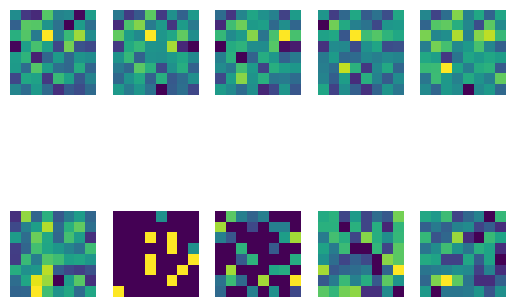

10 tensor(0.7168, device='cuda:0', grad_fn=<MseLossBackward0>)


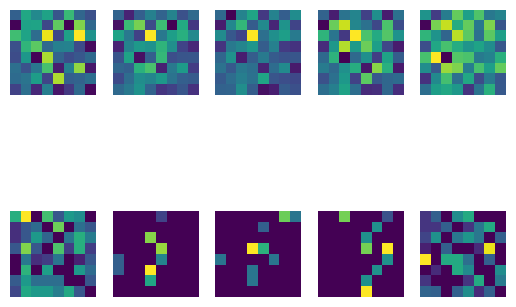

20 tensor(0.4625, device='cuda:0', grad_fn=<MseLossBackward0>)


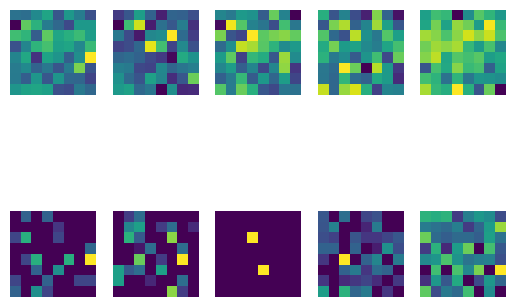

30 tensor(0.4491, device='cuda:0', grad_fn=<MseLossBackward0>)


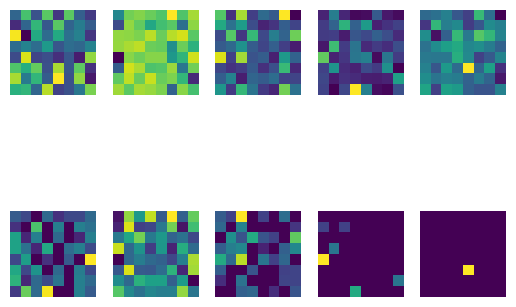

40 tensor(0.3942, device='cuda:0', grad_fn=<MseLossBackward0>)


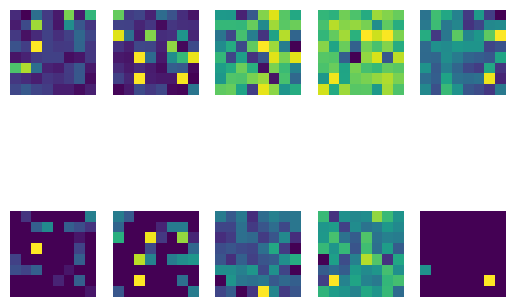

50 tensor(0.3486, device='cuda:0', grad_fn=<MseLossBackward0>)


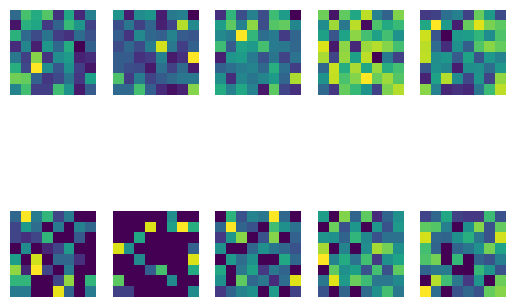

60 tensor(0.3442, device='cuda:0', grad_fn=<MseLossBackward0>)


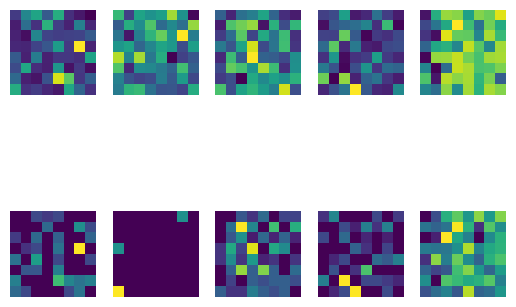

70 tensor(0.3154, device='cuda:0', grad_fn=<MseLossBackward0>)


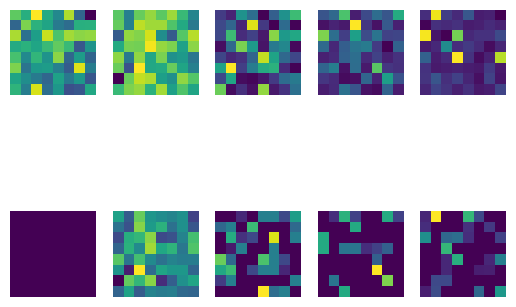

80 tensor(0.4463, device='cuda:0', grad_fn=<MseLossBackward0>)


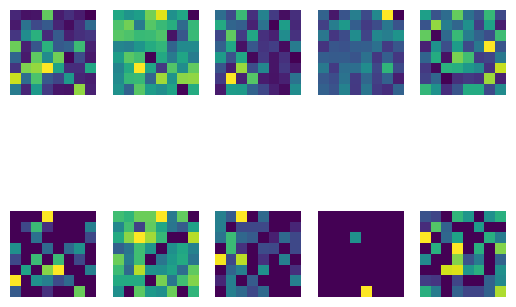

90 tensor(0.3476, device='cuda:0', grad_fn=<MseLossBackward0>)


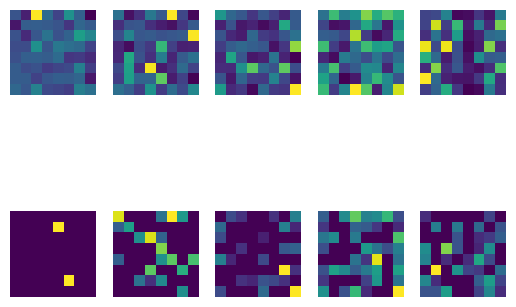

100 tensor(0.3280, device='cuda:0', grad_fn=<MseLossBackward0>)


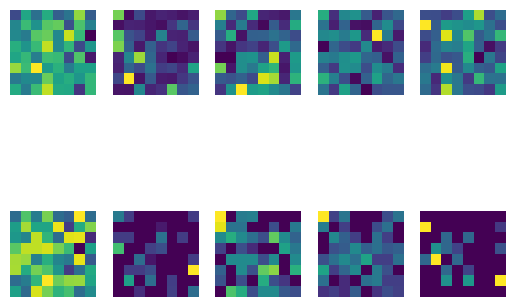

110 tensor(0.3848, device='cuda:0', grad_fn=<MseLossBackward0>)


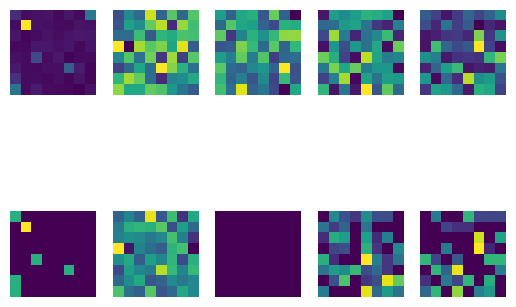

120 tensor(0.3485, device='cuda:0', grad_fn=<MseLossBackward0>)


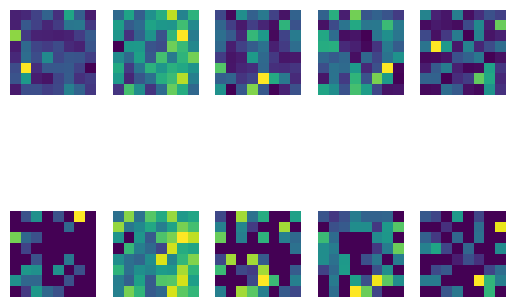

130 tensor(0.3391, device='cuda:0', grad_fn=<MseLossBackward0>)


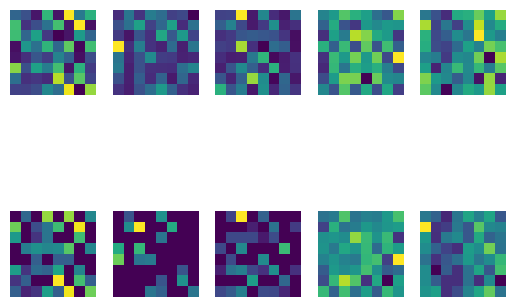

140 tensor(0.3912, device='cuda:0', grad_fn=<MseLossBackward0>)


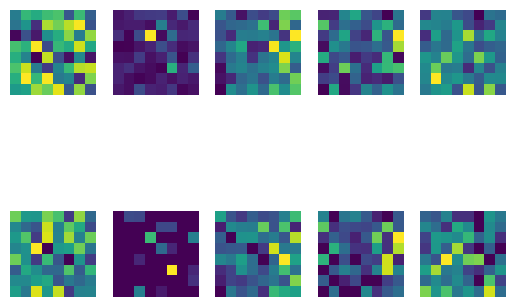

150 tensor(0.3075, device='cuda:0', grad_fn=<MseLossBackward0>)


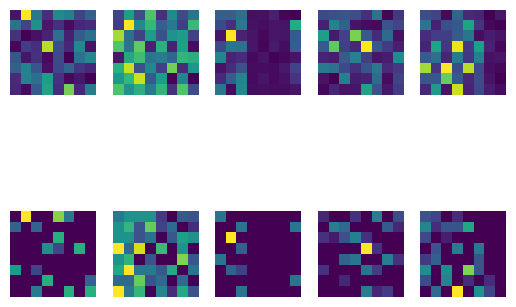

160 tensor(0.3239, device='cuda:0', grad_fn=<MseLossBackward0>)


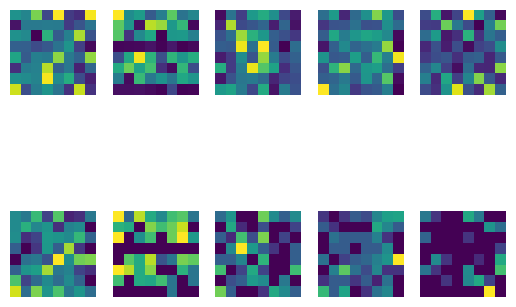

170 tensor(0.2711, device='cuda:0', grad_fn=<MseLossBackward0>)


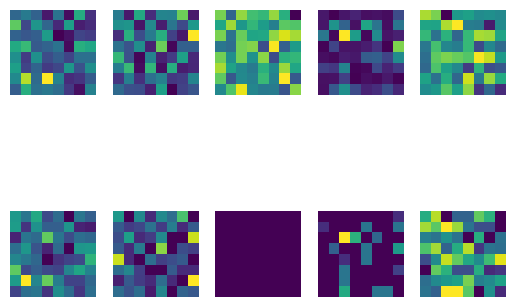

180 tensor(0.3693, device='cuda:0', grad_fn=<MseLossBackward0>)


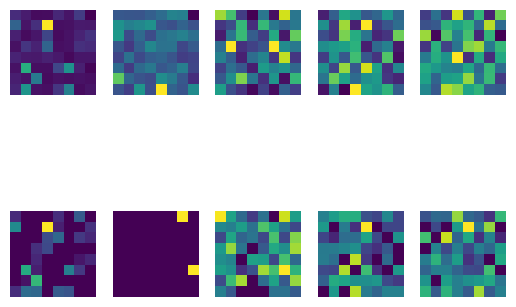

190 tensor(0.2912, device='cuda:0', grad_fn=<MseLossBackward0>)


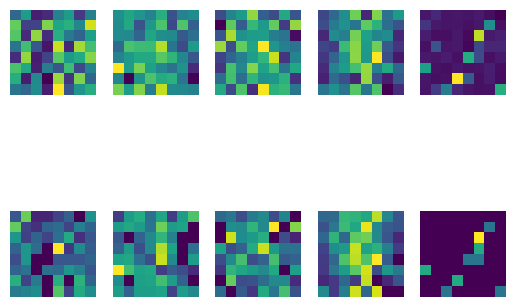

200 tensor(0.3538, device='cuda:0', grad_fn=<MseLossBackward0>)


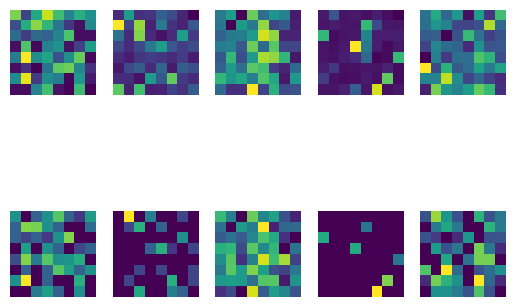

210 tensor(0.3351, device='cuda:0', grad_fn=<MseLossBackward0>)


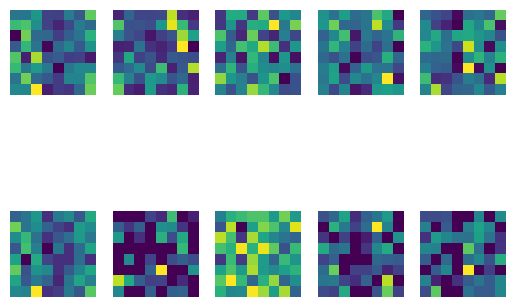

220 tensor(0.3606, device='cuda:0', grad_fn=<MseLossBackward0>)


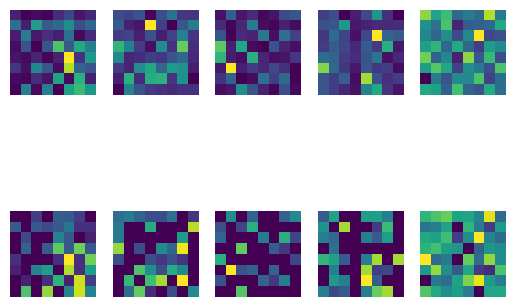

230 tensor(0.2902, device='cuda:0', grad_fn=<MseLossBackward0>)


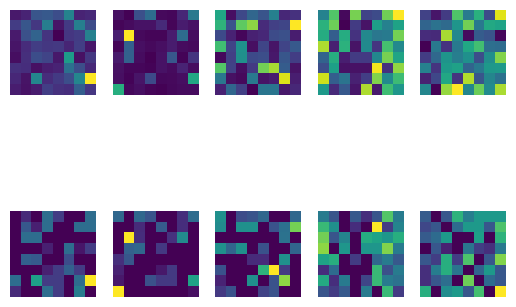

240 tensor(0.3226, device='cuda:0', grad_fn=<MseLossBackward0>)


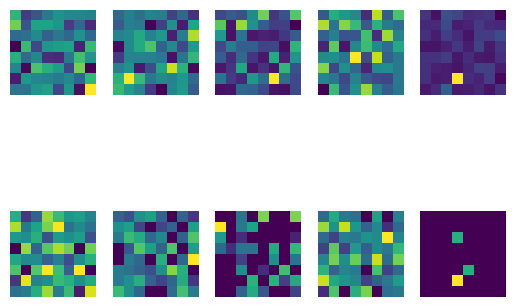

250 tensor(0.2877, device='cuda:0', grad_fn=<MseLossBackward0>)


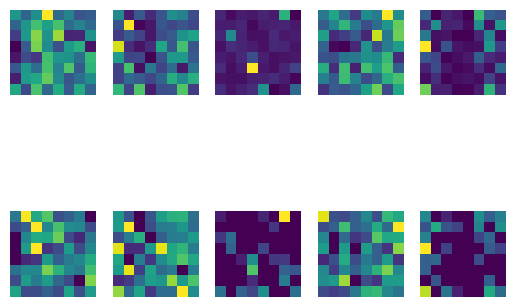

260 tensor(0.3090, device='cuda:0', grad_fn=<MseLossBackward0>)


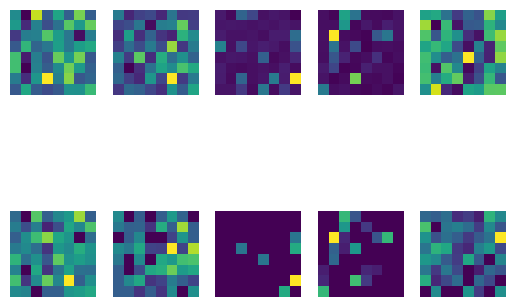

270 tensor(0.3389, device='cuda:0', grad_fn=<MseLossBackward0>)


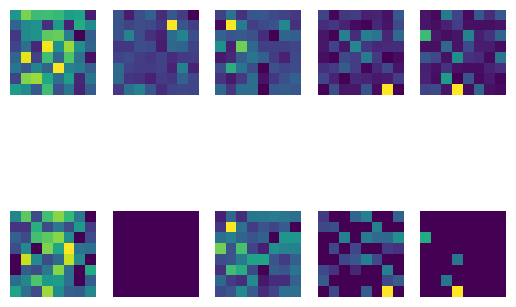

280 tensor(0.3183, device='cuda:0', grad_fn=<MseLossBackward0>)


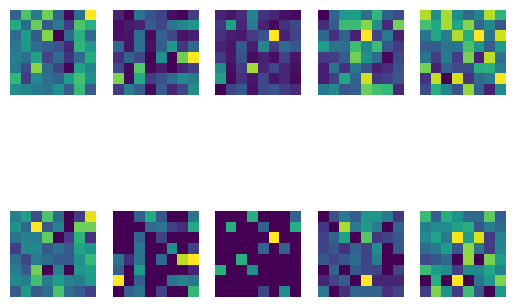

290 tensor(0.3651, device='cuda:0', grad_fn=<MseLossBackward0>)


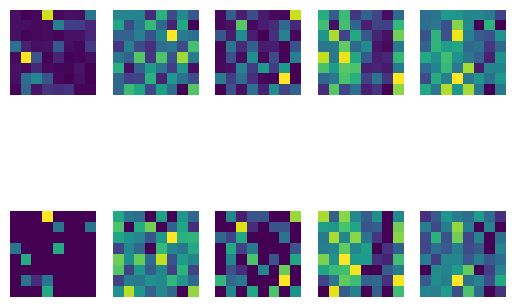

300 tensor(0.2433, device='cuda:0', grad_fn=<MseLossBackward0>)


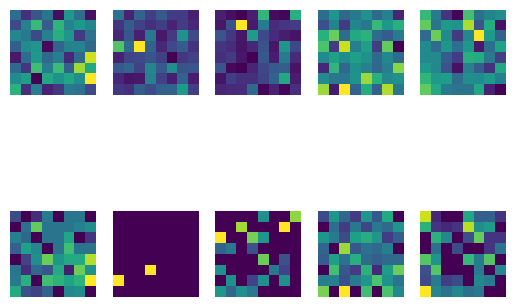

310 tensor(0.2899, device='cuda:0', grad_fn=<MseLossBackward0>)


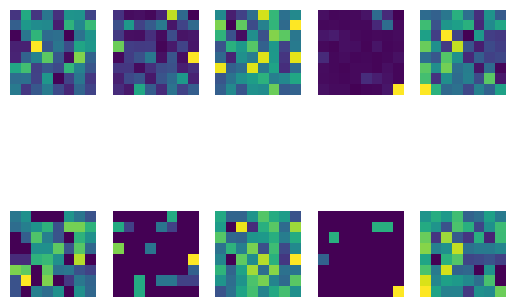

320 tensor(0.3086, device='cuda:0', grad_fn=<MseLossBackward0>)


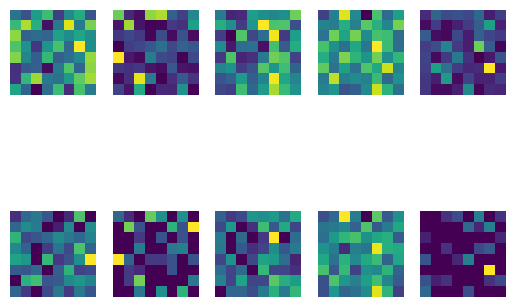

330 tensor(0.3478, device='cuda:0', grad_fn=<MseLossBackward0>)


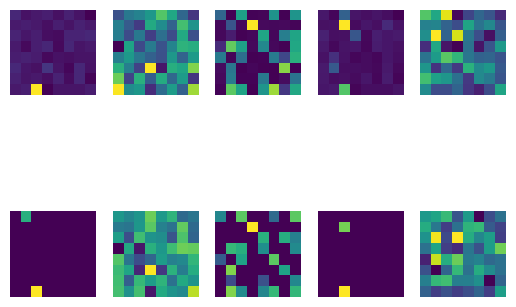

340 tensor(0.3141, device='cuda:0', grad_fn=<MseLossBackward0>)


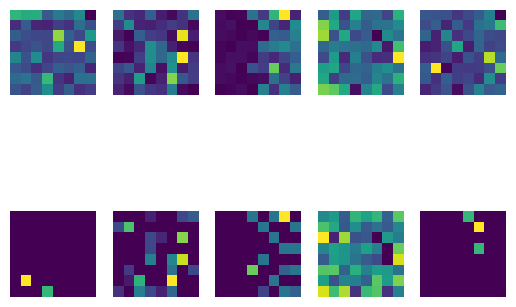

350 tensor(0.3561, device='cuda:0', grad_fn=<MseLossBackward0>)


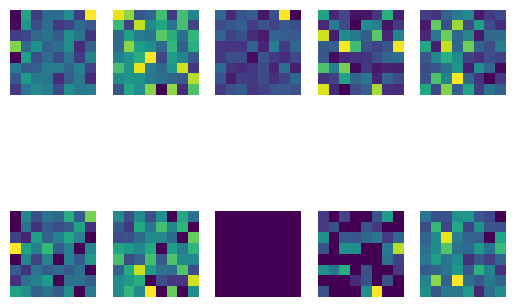

360 tensor(0.3697, device='cuda:0', grad_fn=<MseLossBackward0>)


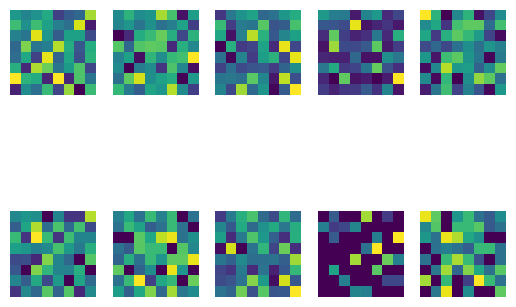

370 tensor(0.3034, device='cuda:0', grad_fn=<MseLossBackward0>)


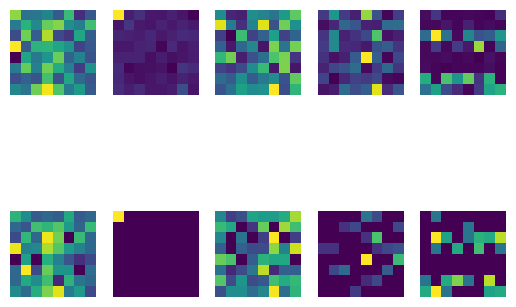

380 tensor(0.3006, device='cuda:0', grad_fn=<MseLossBackward0>)


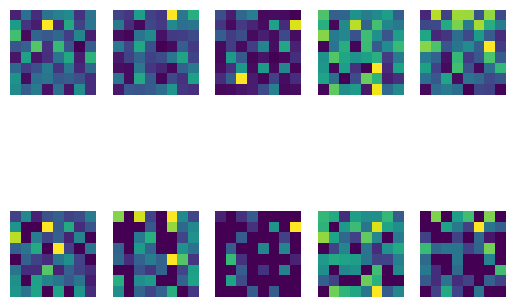

390 tensor(0.2706, device='cuda:0', grad_fn=<MseLossBackward0>)


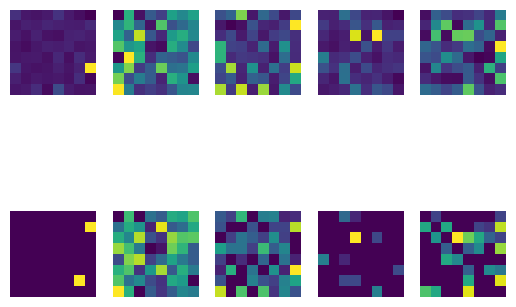

400 tensor(0.3581, device='cuda:0', grad_fn=<MseLossBackward0>)


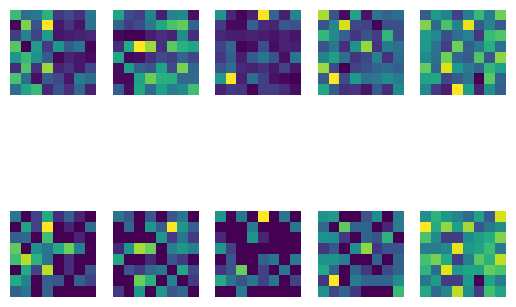

410 tensor(0.3192, device='cuda:0', grad_fn=<MseLossBackward0>)


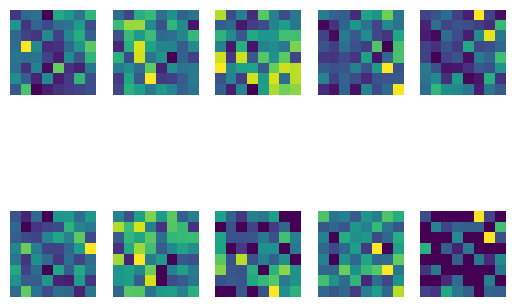

420 tensor(0.3525, device='cuda:0', grad_fn=<MseLossBackward0>)


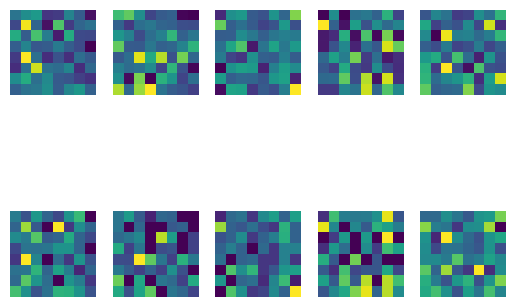

430 tensor(0.3272, device='cuda:0', grad_fn=<MseLossBackward0>)


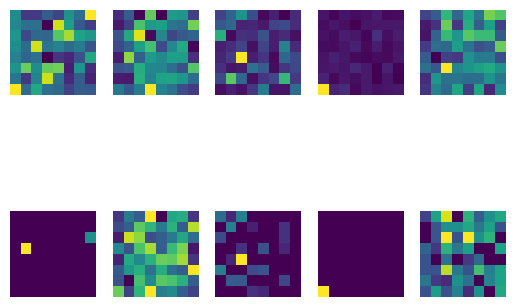

440 tensor(0.3483, device='cuda:0', grad_fn=<MseLossBackward0>)


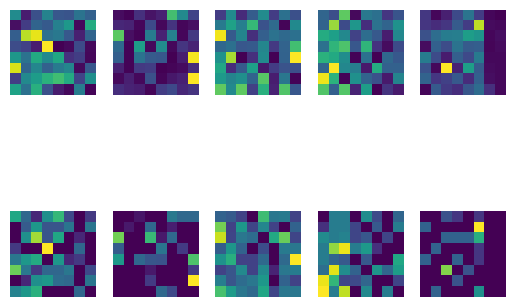

450 tensor(0.3159, device='cuda:0', grad_fn=<MseLossBackward0>)


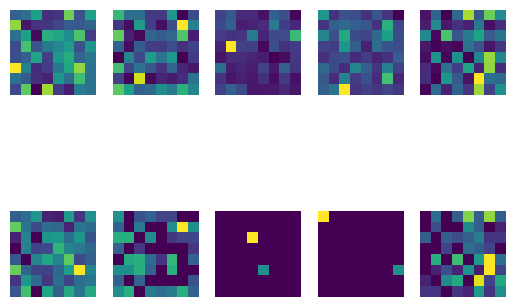

460 tensor(0.3525, device='cuda:0', grad_fn=<MseLossBackward0>)


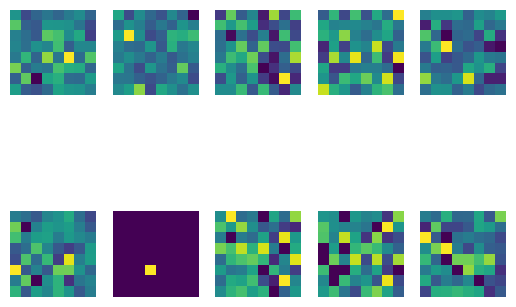

470 tensor(0.3243, device='cuda:0', grad_fn=<MseLossBackward0>)


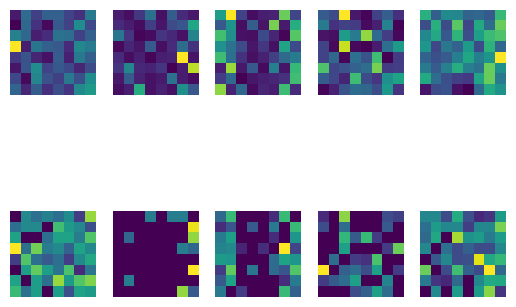

480 tensor(0.2837, device='cuda:0', grad_fn=<MseLossBackward0>)


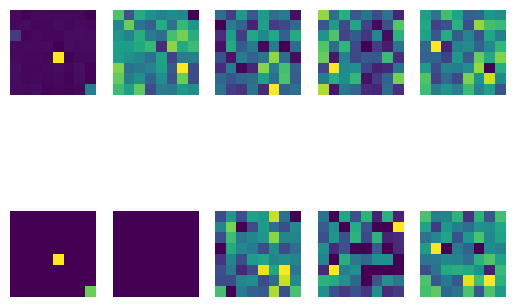

490 tensor(0.3560, device='cuda:0', grad_fn=<MseLossBackward0>)


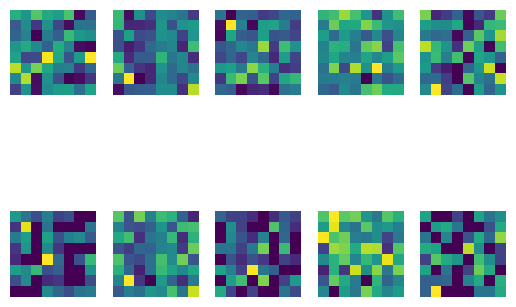

500 tensor(0.3537, device='cuda:0', grad_fn=<MseLossBackward0>)


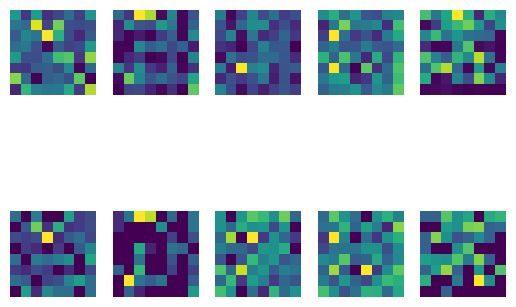

510 tensor(0.3570, device='cuda:0', grad_fn=<MseLossBackward0>)


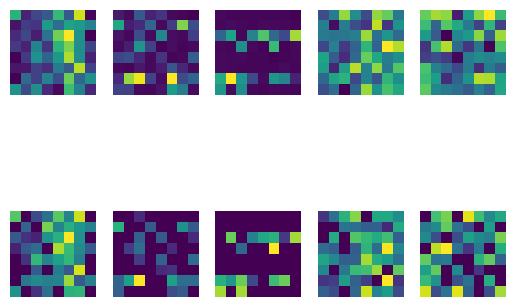

520 tensor(0.3040, device='cuda:0', grad_fn=<MseLossBackward0>)


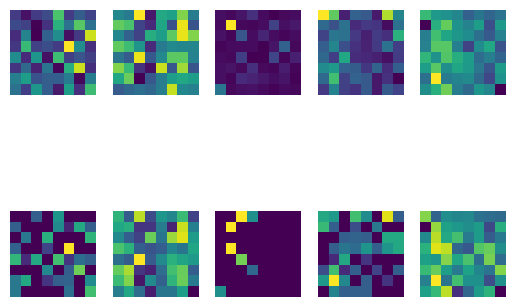

530 tensor(0.3305, device='cuda:0', grad_fn=<MseLossBackward0>)


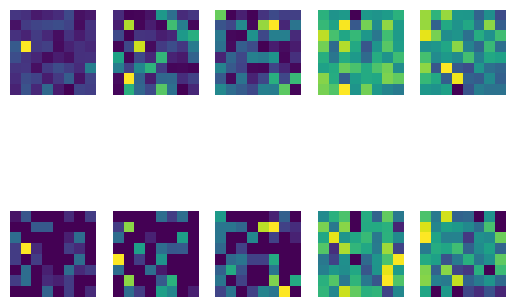

540 tensor(0.3150, device='cuda:0', grad_fn=<MseLossBackward0>)


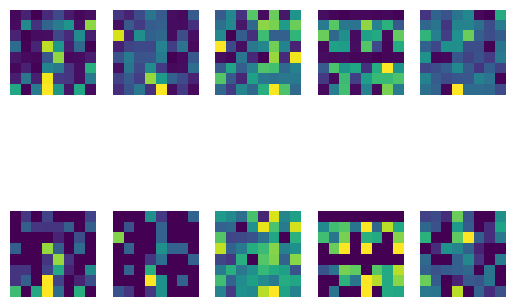

550 tensor(0.3032, device='cuda:0', grad_fn=<MseLossBackward0>)


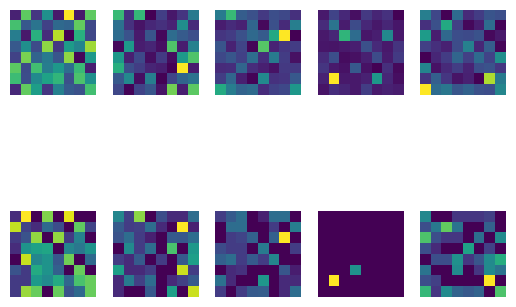

560 tensor(0.2830, device='cuda:0', grad_fn=<MseLossBackward0>)


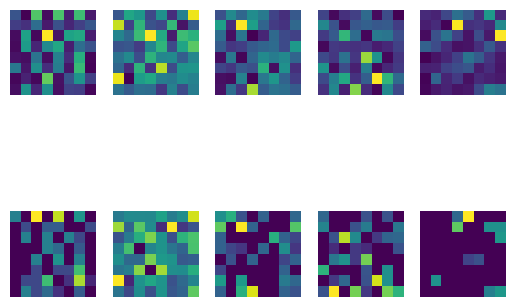

570 tensor(0.3298, device='cuda:0', grad_fn=<MseLossBackward0>)


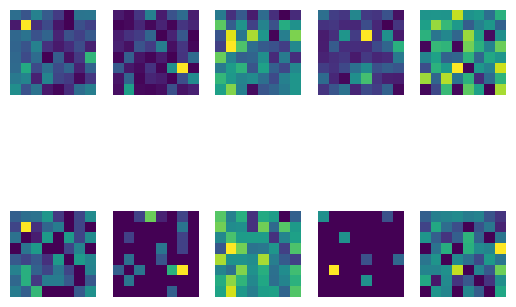

580 tensor(0.3903, device='cuda:0', grad_fn=<MseLossBackward0>)


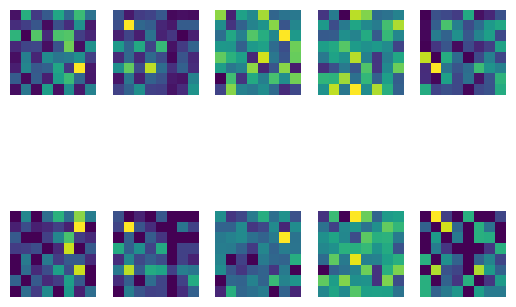

590 tensor(0.3436, device='cuda:0', grad_fn=<MseLossBackward0>)


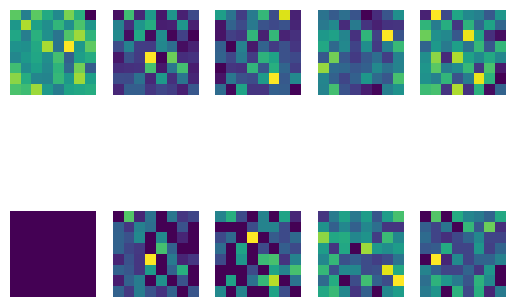

600 tensor(0.3322, device='cuda:0', grad_fn=<MseLossBackward0>)


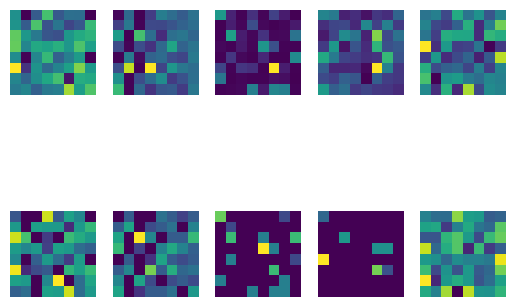

610 tensor(0.3171, device='cuda:0', grad_fn=<MseLossBackward0>)


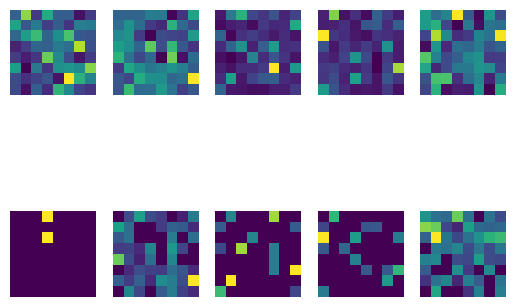

620 tensor(0.2737, device='cuda:0', grad_fn=<MseLossBackward0>)


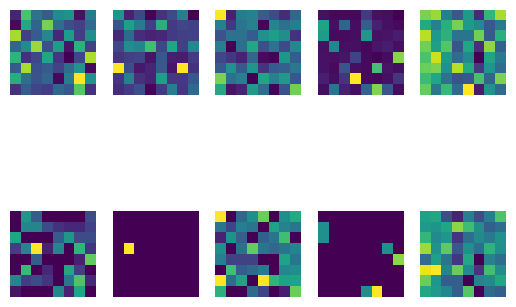

630 tensor(0.3210, device='cuda:0', grad_fn=<MseLossBackward0>)


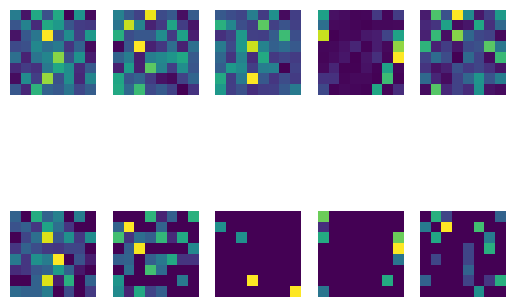

640 tensor(0.3267, device='cuda:0', grad_fn=<MseLossBackward0>)


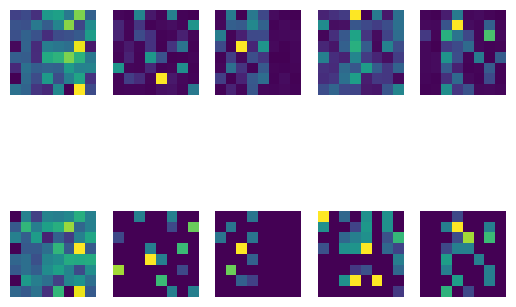

650 tensor(0.3158, device='cuda:0', grad_fn=<MseLossBackward0>)


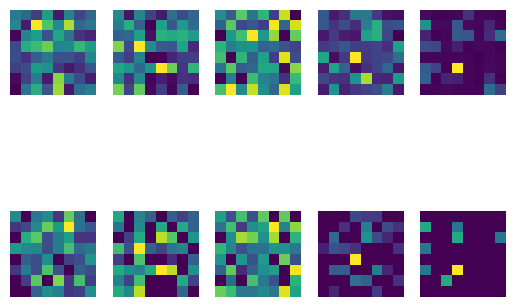

660 tensor(0.3354, device='cuda:0', grad_fn=<MseLossBackward0>)


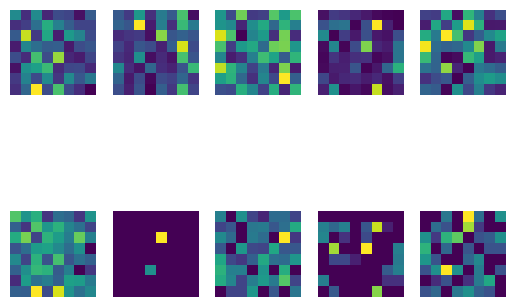

670 tensor(0.2700, device='cuda:0', grad_fn=<MseLossBackward0>)


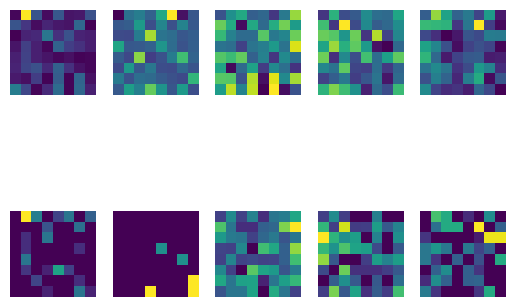

680 tensor(0.2835, device='cuda:0', grad_fn=<MseLossBackward0>)


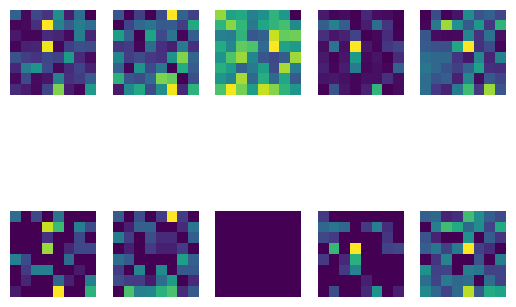

690 tensor(0.3450, device='cuda:0', grad_fn=<MseLossBackward0>)


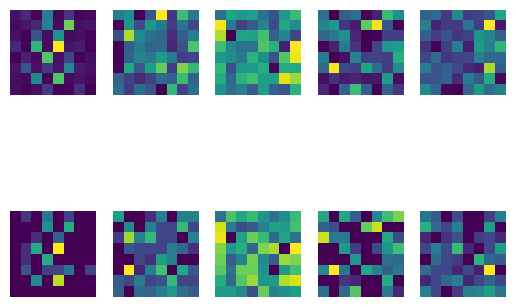

700 tensor(0.3163, device='cuda:0', grad_fn=<MseLossBackward0>)


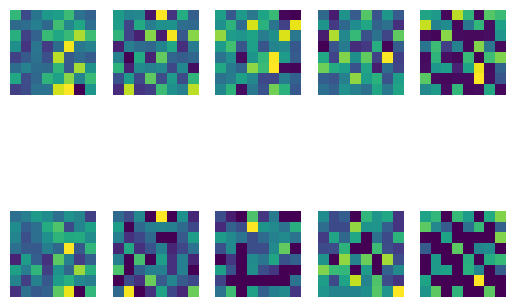

710 tensor(0.2185, device='cuda:0', grad_fn=<MseLossBackward0>)


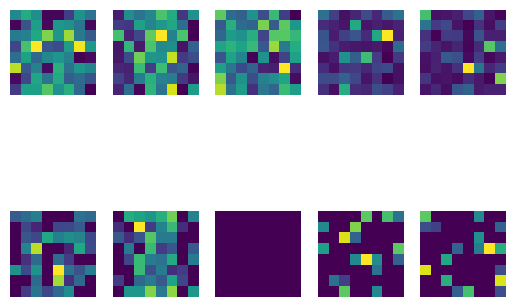

720 tensor(0.3134, device='cuda:0', grad_fn=<MseLossBackward0>)


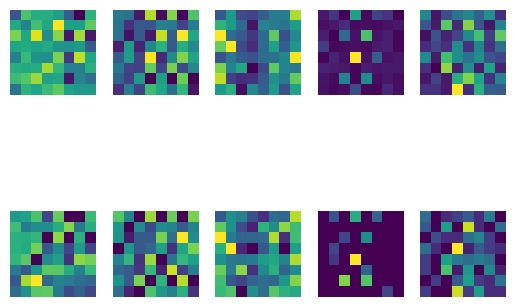

730 tensor(0.2824, device='cuda:0', grad_fn=<MseLossBackward0>)


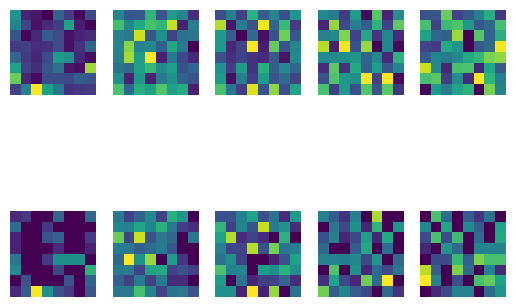

740 tensor(0.2689, device='cuda:0', grad_fn=<MseLossBackward0>)


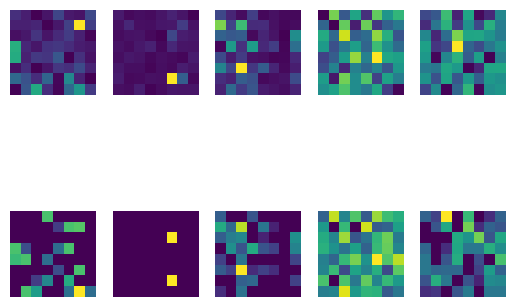

750 tensor(0.2702, device='cuda:0', grad_fn=<MseLossBackward0>)


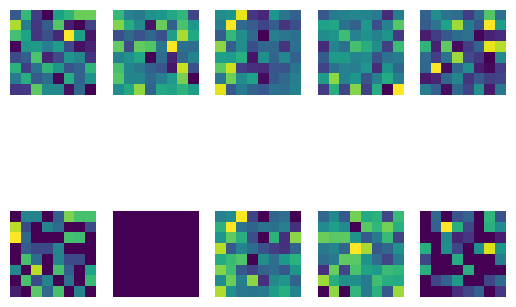

760 tensor(0.3108, device='cuda:0', grad_fn=<MseLossBackward0>)


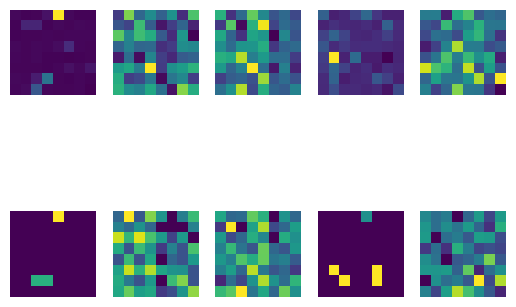

770 tensor(0.2818, device='cuda:0', grad_fn=<MseLossBackward0>)


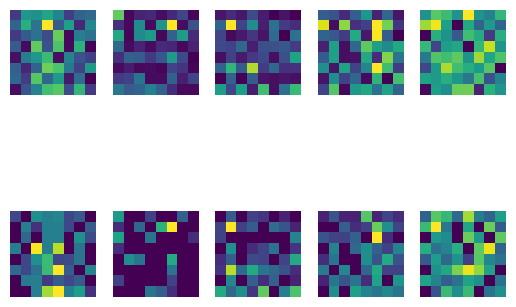

780 tensor(0.3003, device='cuda:0', grad_fn=<MseLossBackward0>)


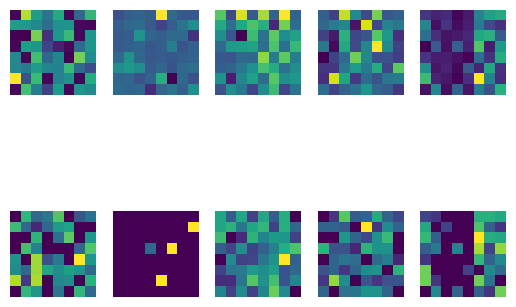

790 tensor(0.2703, device='cuda:0', grad_fn=<MseLossBackward0>)


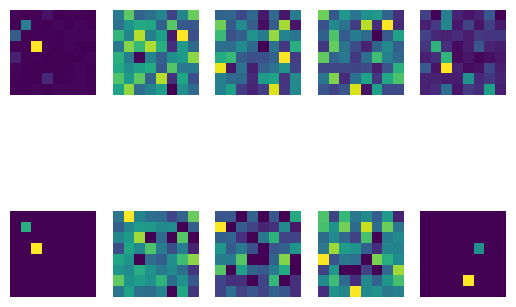

800 tensor(0.3155, device='cuda:0', grad_fn=<MseLossBackward0>)


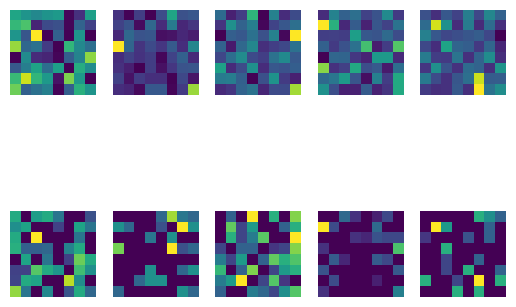

810 tensor(0.2645, device='cuda:0', grad_fn=<MseLossBackward0>)


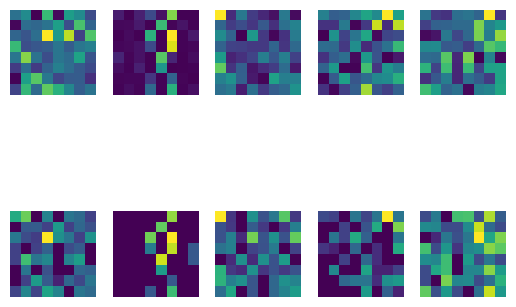

820 tensor(0.3651, device='cuda:0', grad_fn=<MseLossBackward0>)


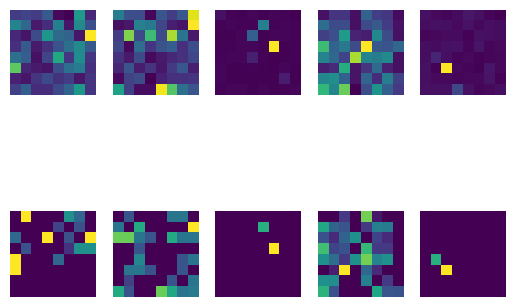

830 tensor(0.3019, device='cuda:0', grad_fn=<MseLossBackward0>)


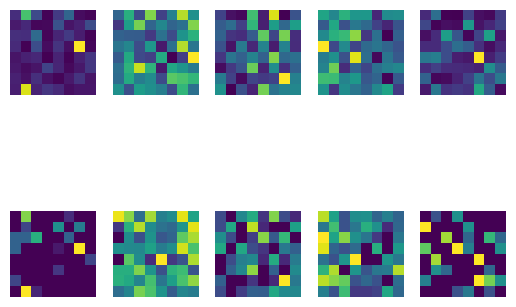

840 tensor(0.2820, device='cuda:0', grad_fn=<MseLossBackward0>)


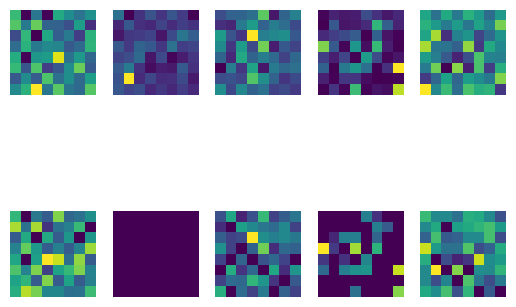

850 tensor(0.2520, device='cuda:0', grad_fn=<MseLossBackward0>)


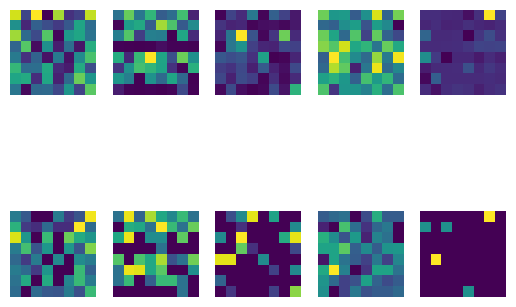

860 tensor(0.2841, device='cuda:0', grad_fn=<MseLossBackward0>)


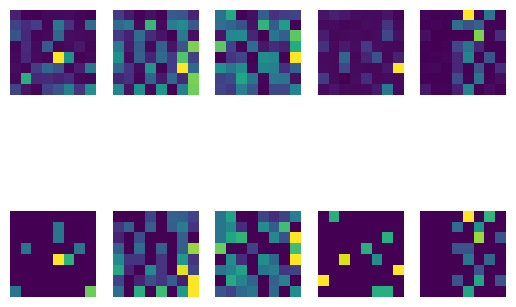

870 tensor(0.3212, device='cuda:0', grad_fn=<MseLossBackward0>)


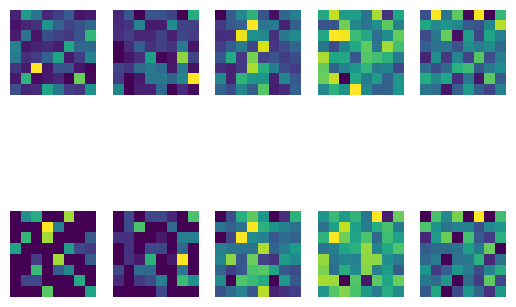

880 tensor(0.3369, device='cuda:0', grad_fn=<MseLossBackward0>)


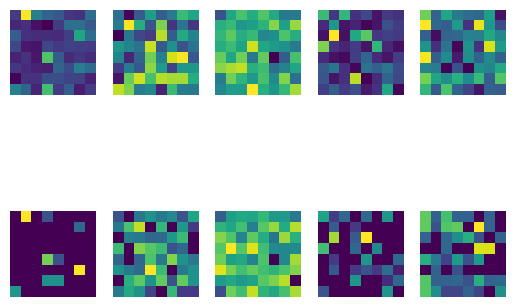

890 tensor(0.3361, device='cuda:0', grad_fn=<MseLossBackward0>)


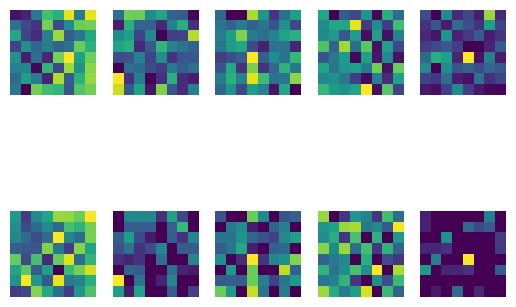

900 tensor(0.3335, device='cuda:0', grad_fn=<MseLossBackward0>)


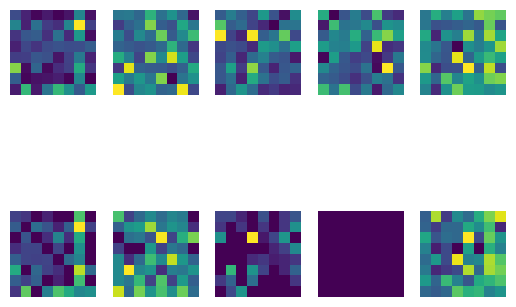

910 tensor(0.2874, device='cuda:0', grad_fn=<MseLossBackward0>)


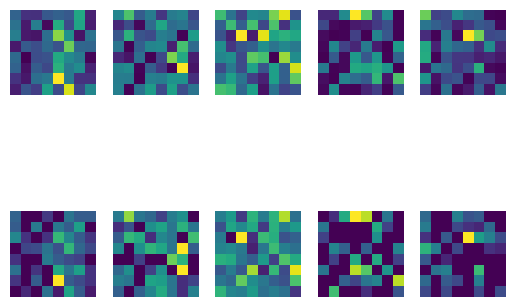

920 tensor(0.3079, device='cuda:0', grad_fn=<MseLossBackward0>)


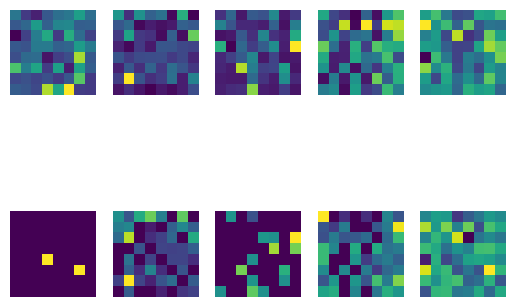

930 tensor(0.2909, device='cuda:0', grad_fn=<MseLossBackward0>)


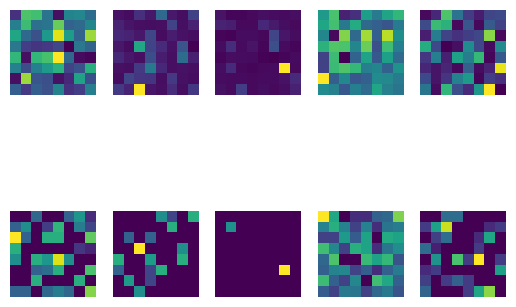

940 tensor(0.2920, device='cuda:0', grad_fn=<MseLossBackward0>)


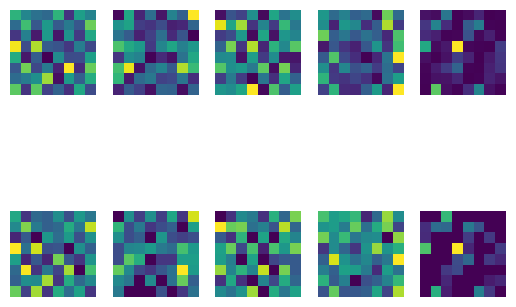

950 tensor(0.2708, device='cuda:0', grad_fn=<MseLossBackward0>)


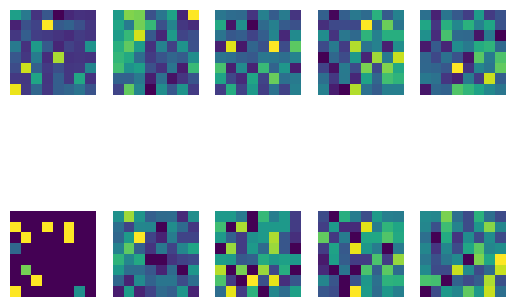

960 tensor(0.3068, device='cuda:0', grad_fn=<MseLossBackward0>)


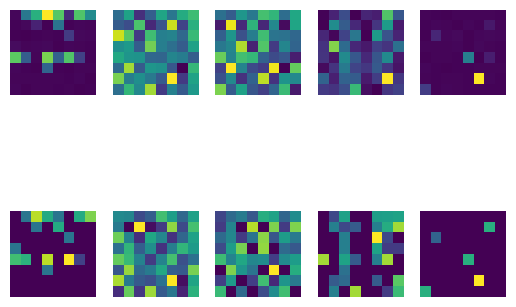

970 tensor(0.3065, device='cuda:0', grad_fn=<MseLossBackward0>)


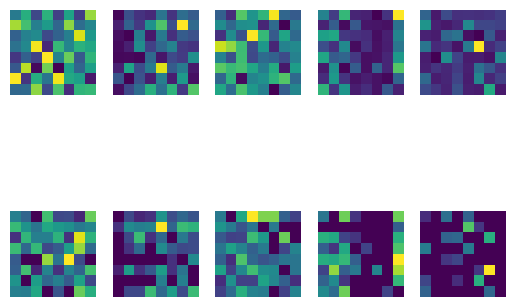

980 tensor(0.2604, device='cuda:0', grad_fn=<MseLossBackward0>)


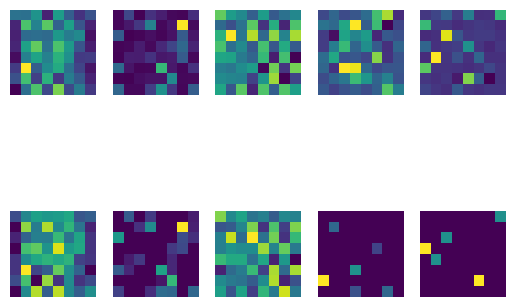

990 tensor(0.2830, device='cuda:0', grad_fn=<MseLossBackward0>)


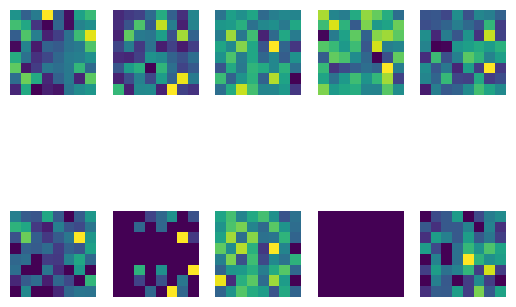

1000 tensor(0.3024, device='cuda:0', grad_fn=<MseLossBackward0>)


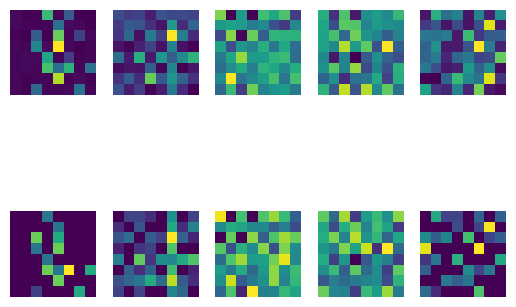

1010 tensor(0.3137, device='cuda:0', grad_fn=<MseLossBackward0>)


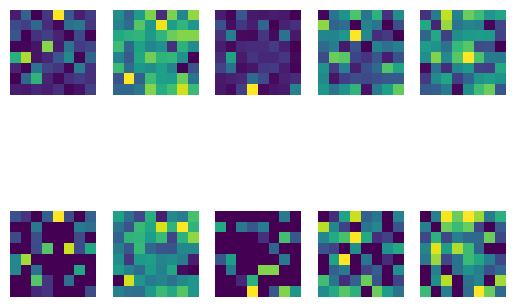

1020 tensor(0.2429, device='cuda:0', grad_fn=<MseLossBackward0>)


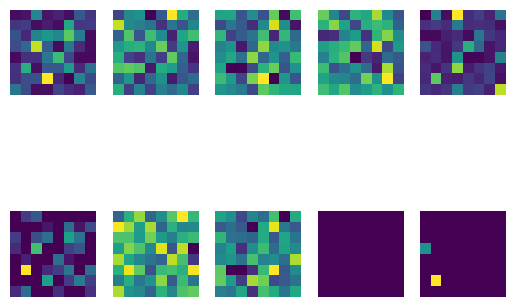

1030 tensor(0.2541, device='cuda:0', grad_fn=<MseLossBackward0>)


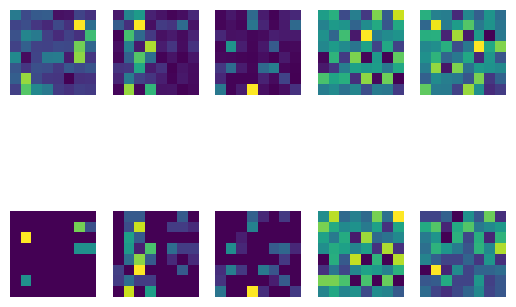

1040 tensor(0.3308, device='cuda:0', grad_fn=<MseLossBackward0>)


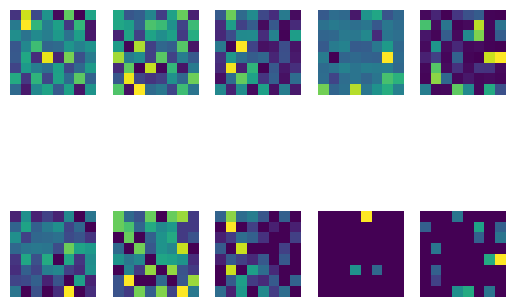

1050 tensor(0.2245, device='cuda:0', grad_fn=<MseLossBackward0>)


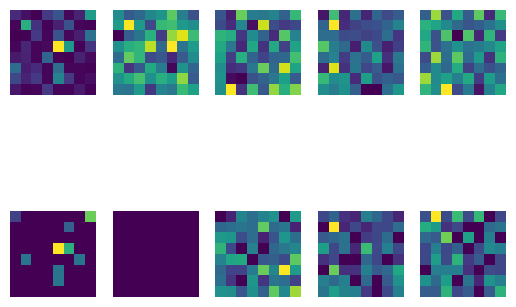

1060 tensor(0.2540, device='cuda:0', grad_fn=<MseLossBackward0>)


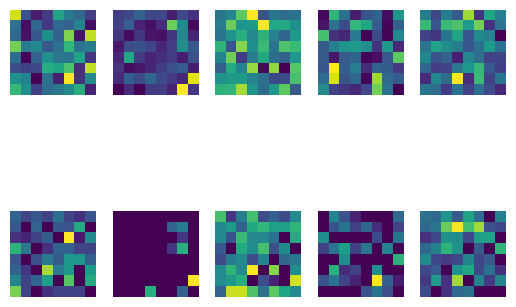

1070 tensor(0.2849, device='cuda:0', grad_fn=<MseLossBackward0>)


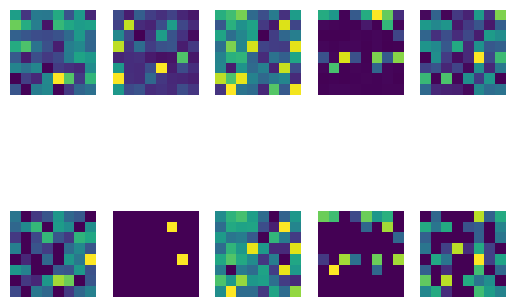

1080 tensor(0.3175, device='cuda:0', grad_fn=<MseLossBackward0>)


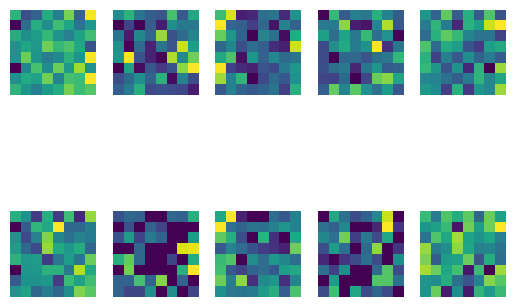

1090 tensor(0.2341, device='cuda:0', grad_fn=<MseLossBackward0>)


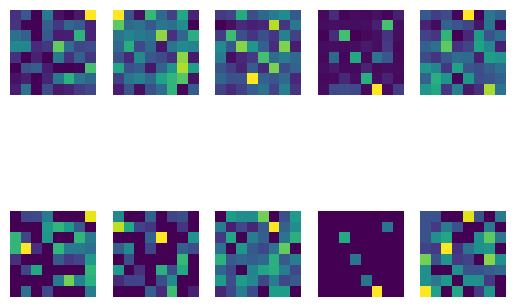

1100 tensor(0.2663, device='cuda:0', grad_fn=<MseLossBackward0>)


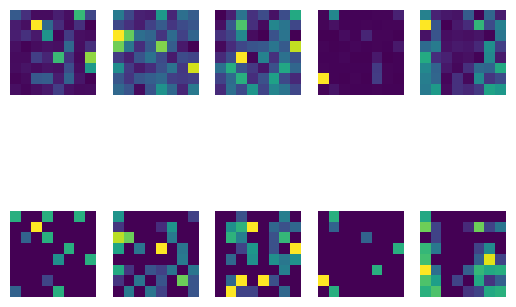

1110 tensor(0.3033, device='cuda:0', grad_fn=<MseLossBackward0>)


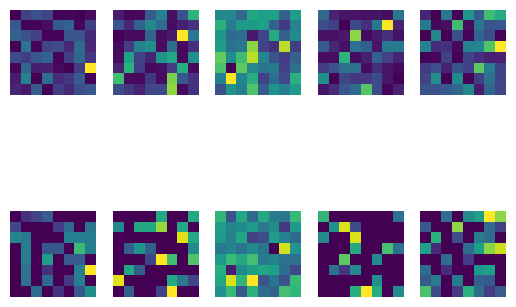

1120 tensor(0.2937, device='cuda:0', grad_fn=<MseLossBackward0>)


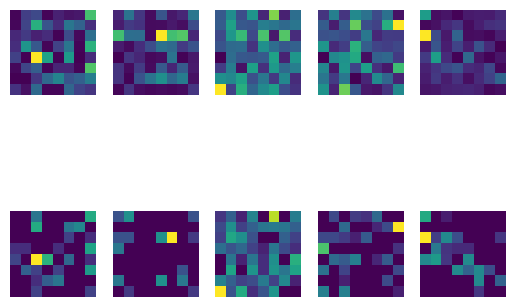

1130 tensor(0.2895, device='cuda:0', grad_fn=<MseLossBackward0>)


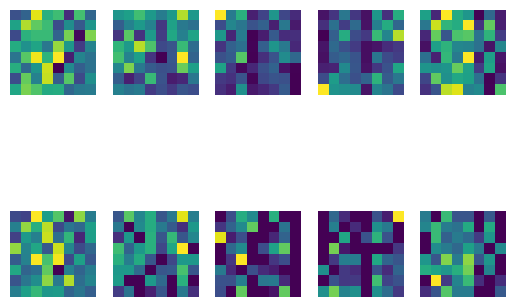

1140 tensor(0.2820, device='cuda:0', grad_fn=<MseLossBackward0>)


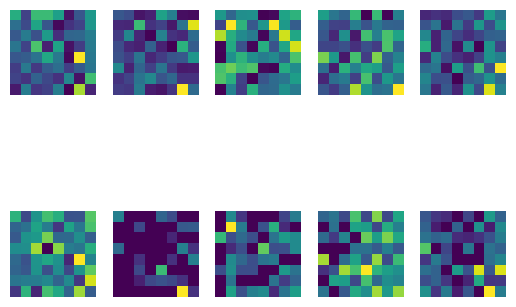

1150 tensor(0.2918, device='cuda:0', grad_fn=<MseLossBackward0>)


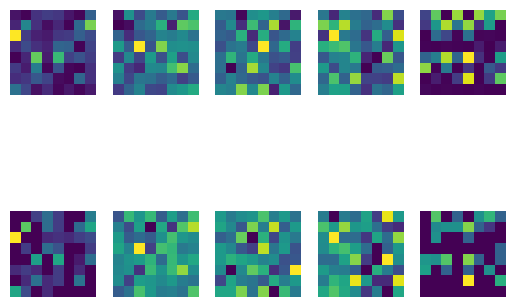

1160 tensor(0.2778, device='cuda:0', grad_fn=<MseLossBackward0>)


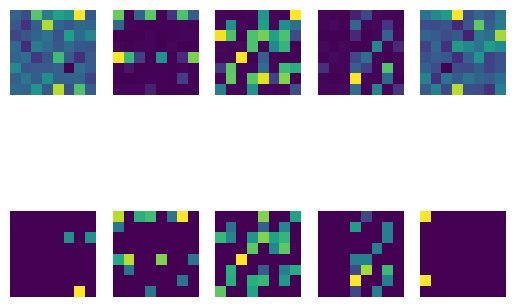

1170 tensor(0.3159, device='cuda:0', grad_fn=<MseLossBackward0>)


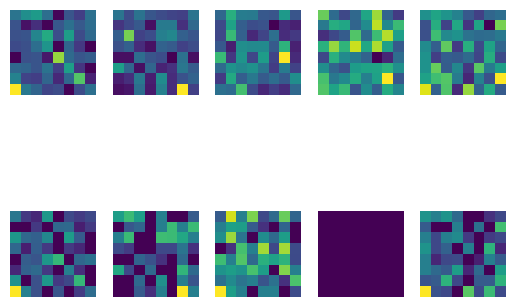

1180 tensor(0.2490, device='cuda:0', grad_fn=<MseLossBackward0>)


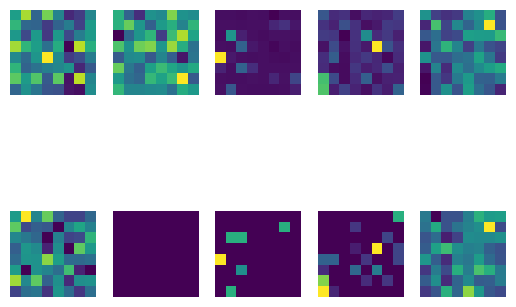

1190 tensor(0.3070, device='cuda:0', grad_fn=<MseLossBackward0>)


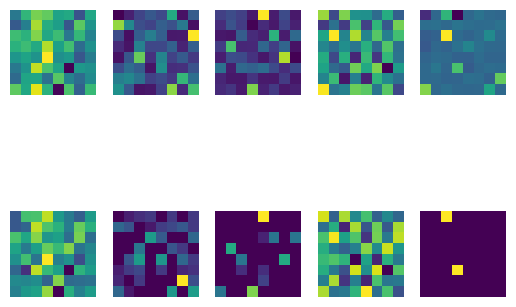

1200 tensor(0.3154, device='cuda:0', grad_fn=<MseLossBackward0>)


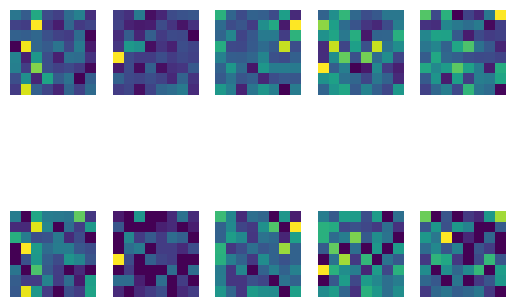

1210 tensor(0.2952, device='cuda:0', grad_fn=<MseLossBackward0>)


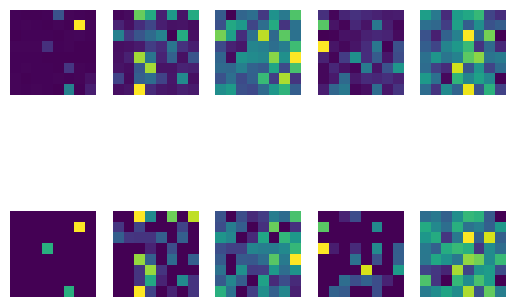

1220 tensor(0.2376, device='cuda:0', grad_fn=<MseLossBackward0>)


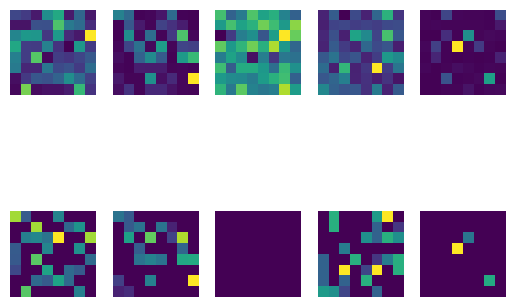

1230 tensor(0.2684, device='cuda:0', grad_fn=<MseLossBackward0>)


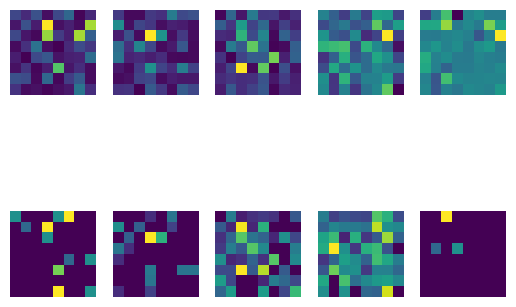

1240 tensor(0.2586, device='cuda:0', grad_fn=<MseLossBackward0>)


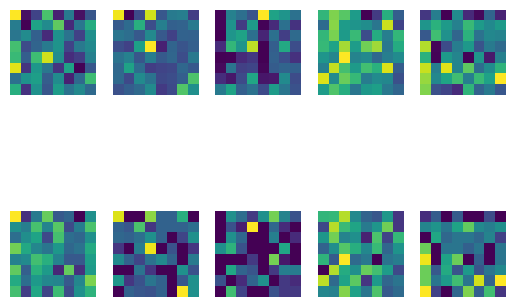

1250 tensor(0.2796, device='cuda:0', grad_fn=<MseLossBackward0>)


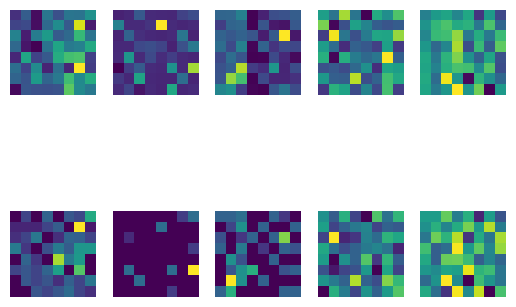

1260 tensor(0.2714, device='cuda:0', grad_fn=<MseLossBackward0>)


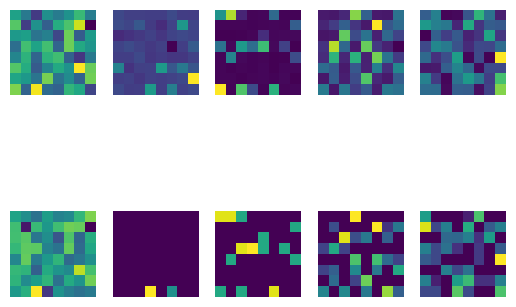

1270 tensor(0.2813, device='cuda:0', grad_fn=<MseLossBackward0>)


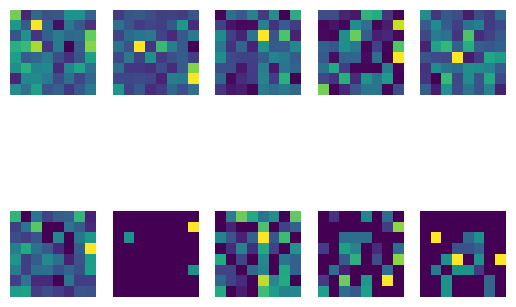

1280 tensor(0.2526, device='cuda:0', grad_fn=<MseLossBackward0>)


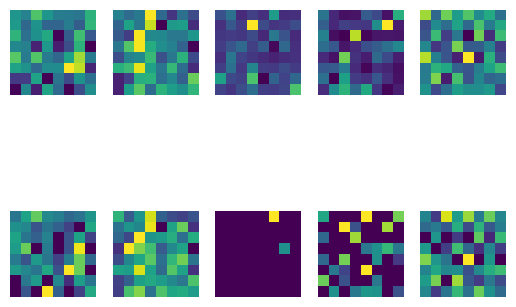

1290 tensor(0.2798, device='cuda:0', grad_fn=<MseLossBackward0>)


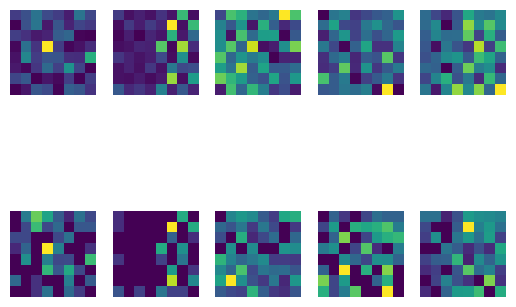

1300 tensor(0.2306, device='cuda:0', grad_fn=<MseLossBackward0>)


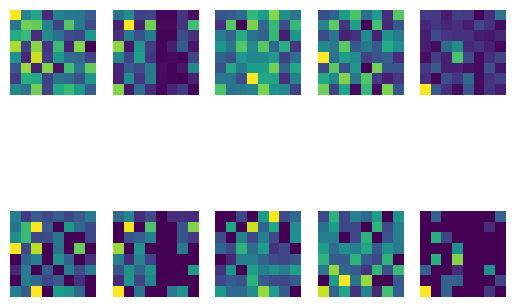

1310 tensor(0.2572, device='cuda:0', grad_fn=<MseLossBackward0>)


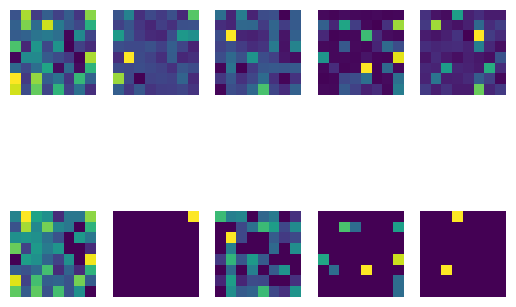

1320 tensor(0.2749, device='cuda:0', grad_fn=<MseLossBackward0>)


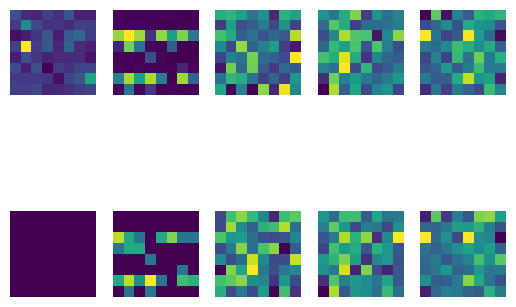

1330 tensor(0.2708, device='cuda:0', grad_fn=<MseLossBackward0>)


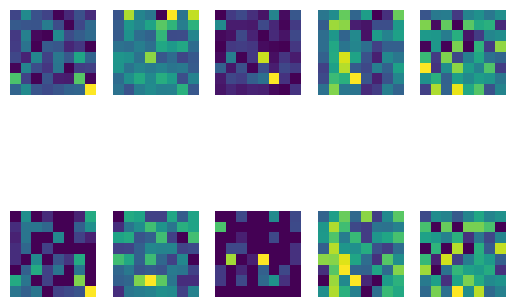

1340 tensor(0.2716, device='cuda:0', grad_fn=<MseLossBackward0>)


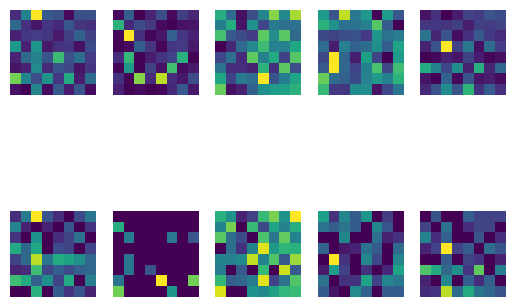

1350 tensor(0.3195, device='cuda:0', grad_fn=<MseLossBackward0>)


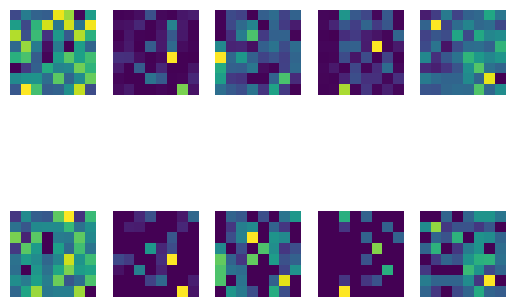

1360 tensor(0.2286, device='cuda:0', grad_fn=<MseLossBackward0>)


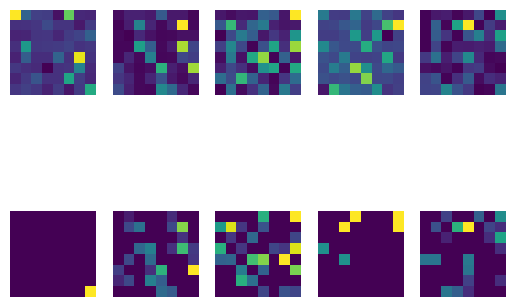

1370 tensor(0.2754, device='cuda:0', grad_fn=<MseLossBackward0>)


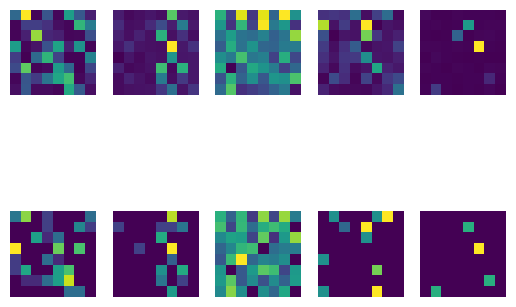

1380 tensor(0.2228, device='cuda:0', grad_fn=<MseLossBackward0>)


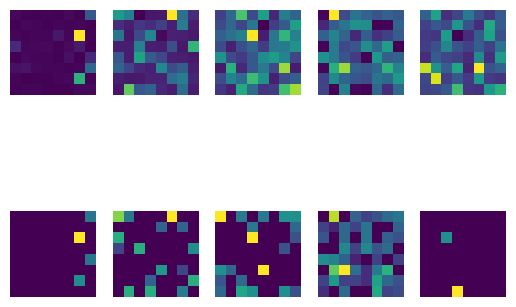

1390 tensor(0.2536, device='cuda:0', grad_fn=<MseLossBackward0>)


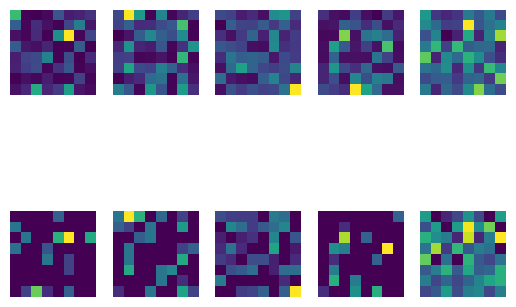

1400 tensor(0.2699, device='cuda:0', grad_fn=<MseLossBackward0>)


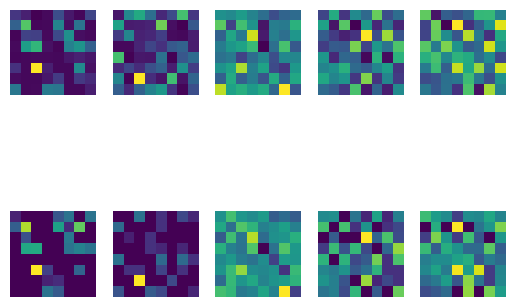

1410 tensor(0.2652, device='cuda:0', grad_fn=<MseLossBackward0>)


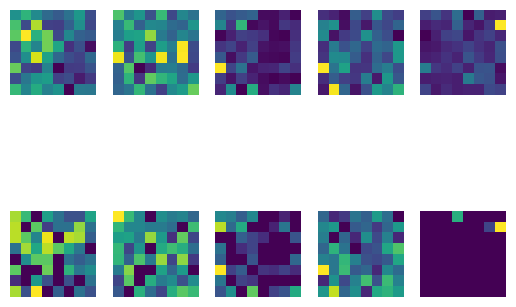

1420 tensor(0.2897, device='cuda:0', grad_fn=<MseLossBackward0>)


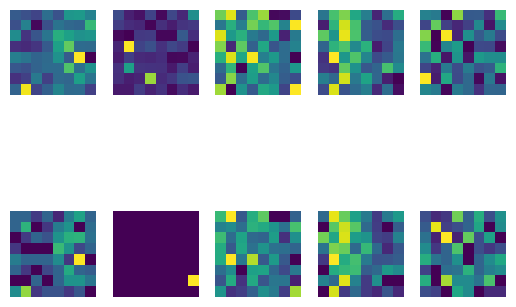

1430 tensor(0.2478, device='cuda:0', grad_fn=<MseLossBackward0>)


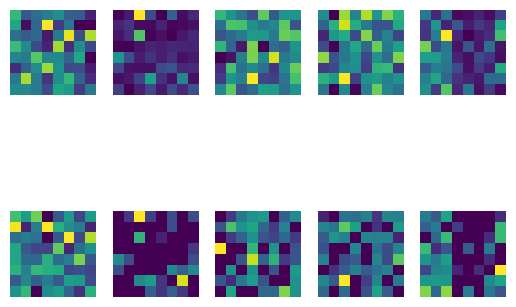

1440 tensor(0.2801, device='cuda:0', grad_fn=<MseLossBackward0>)


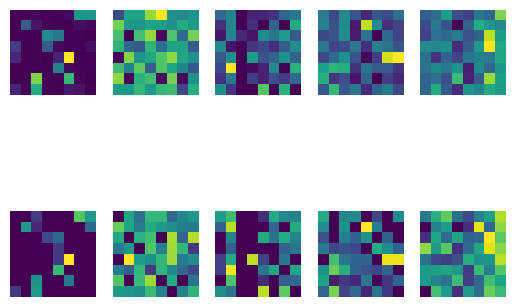

1450 tensor(0.2498, device='cuda:0', grad_fn=<MseLossBackward0>)


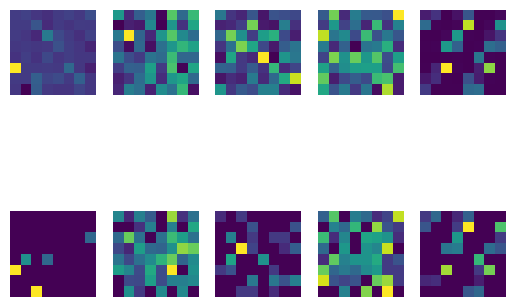

1460 tensor(0.2873, device='cuda:0', grad_fn=<MseLossBackward0>)


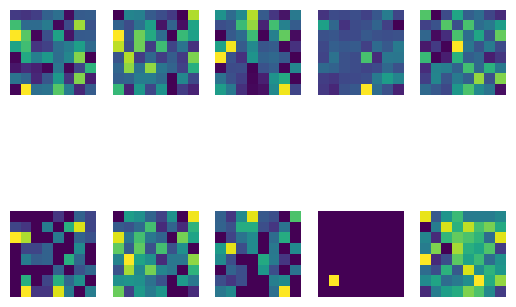

1470 tensor(0.2485, device='cuda:0', grad_fn=<MseLossBackward0>)


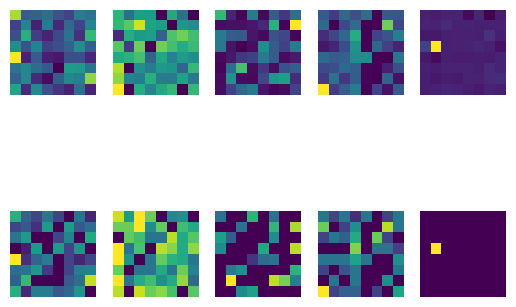

1480 tensor(0.2547, device='cuda:0', grad_fn=<MseLossBackward0>)


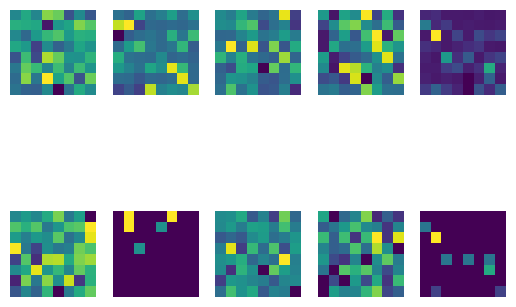

1490 tensor(0.2419, device='cuda:0', grad_fn=<MseLossBackward0>)


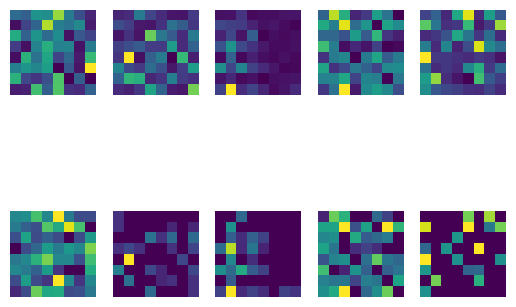

1500 tensor(0.2455, device='cuda:0', grad_fn=<MseLossBackward0>)


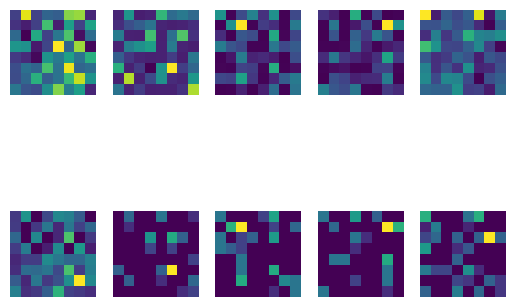

1510 tensor(0.2647, device='cuda:0', grad_fn=<MseLossBackward0>)


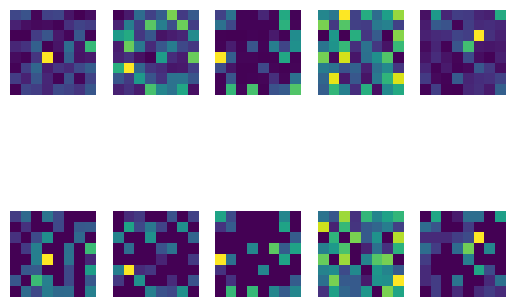

1520 tensor(0.2496, device='cuda:0', grad_fn=<MseLossBackward0>)


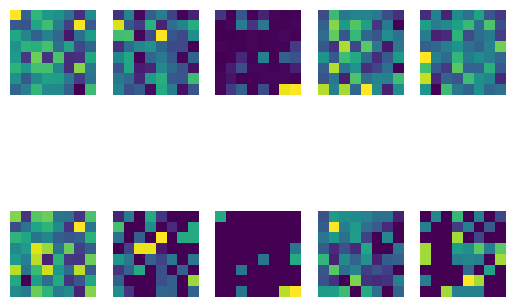

1530 tensor(0.2612, device='cuda:0', grad_fn=<MseLossBackward0>)


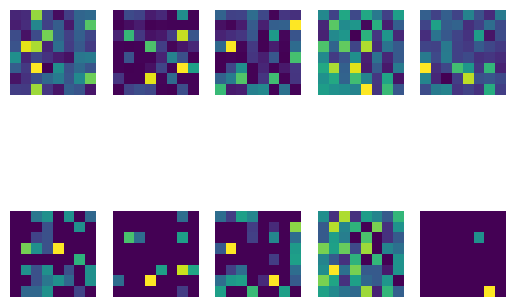

1540 tensor(0.2527, device='cuda:0', grad_fn=<MseLossBackward0>)


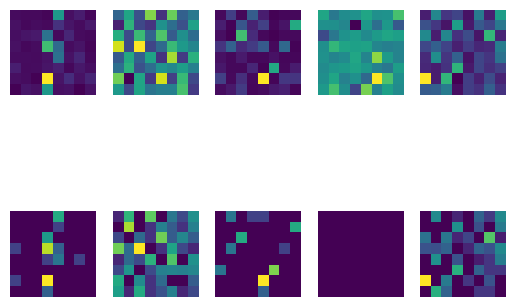

1550 tensor(0.2410, device='cuda:0', grad_fn=<MseLossBackward0>)


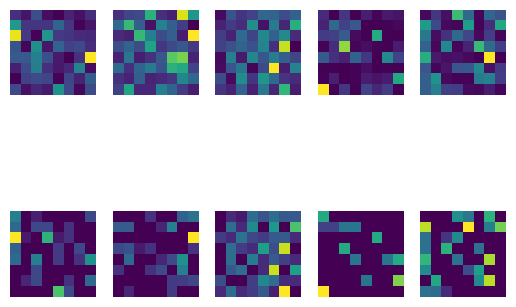

1560 tensor(0.2461, device='cuda:0', grad_fn=<MseLossBackward0>)


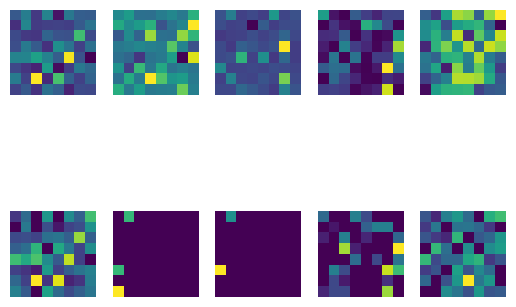

1570 tensor(0.2352, device='cuda:0', grad_fn=<MseLossBackward0>)


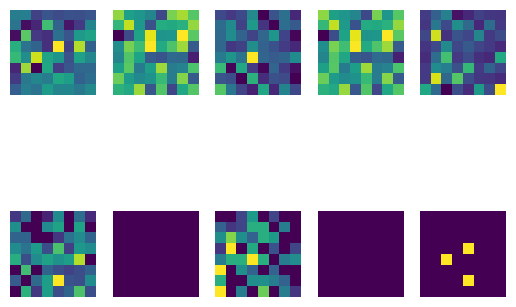

1580 tensor(0.2504, device='cuda:0', grad_fn=<MseLossBackward0>)


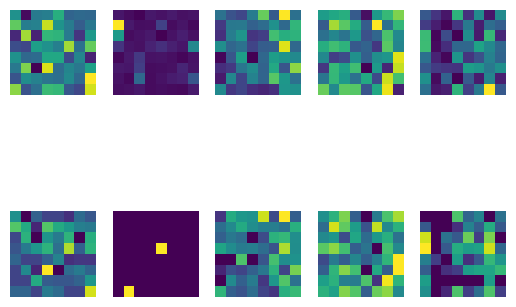

1590 tensor(0.2400, device='cuda:0', grad_fn=<MseLossBackward0>)


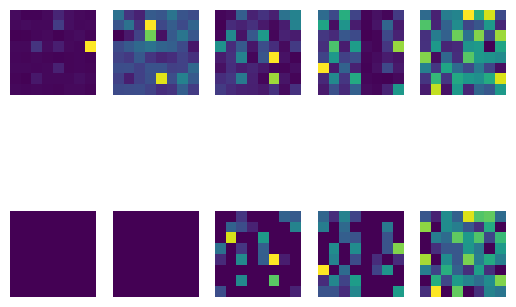

1600 tensor(0.2814, device='cuda:0', grad_fn=<MseLossBackward0>)


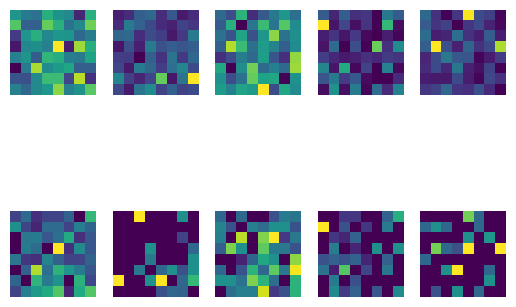

1610 tensor(0.2601, device='cuda:0', grad_fn=<MseLossBackward0>)


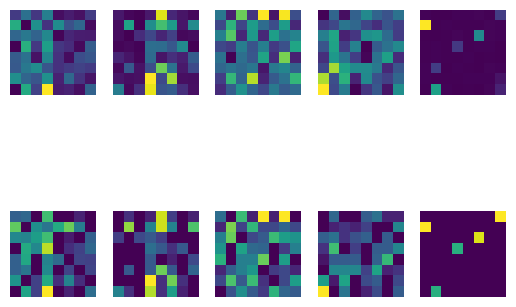

1620 tensor(0.2358, device='cuda:0', grad_fn=<MseLossBackward0>)


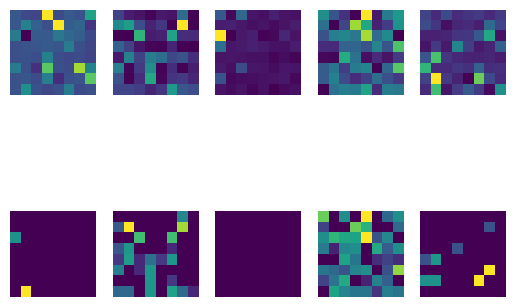

1630 tensor(0.2469, device='cuda:0', grad_fn=<MseLossBackward0>)


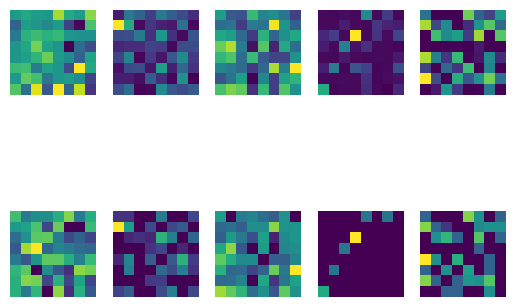

1640 tensor(0.2614, device='cuda:0', grad_fn=<MseLossBackward0>)


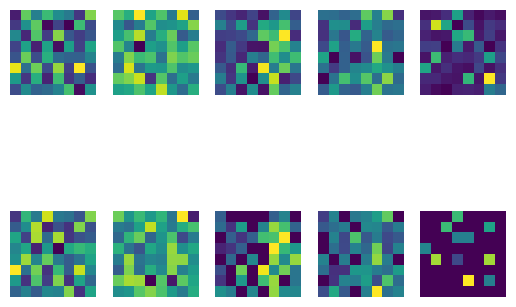

1650 tensor(0.2087, device='cuda:0', grad_fn=<MseLossBackward0>)


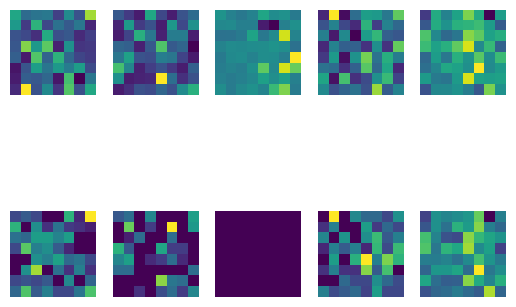

1660 tensor(0.2456, device='cuda:0', grad_fn=<MseLossBackward0>)


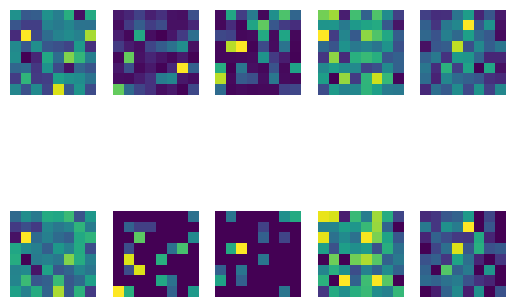

1670 tensor(0.1921, device='cuda:0', grad_fn=<MseLossBackward0>)


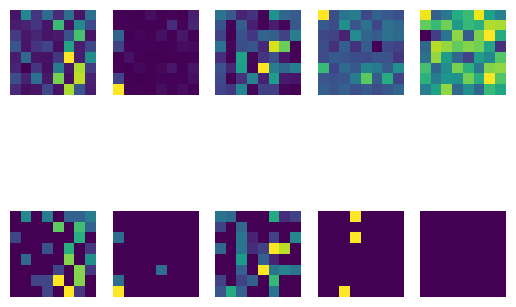

1680 tensor(0.2526, device='cuda:0', grad_fn=<MseLossBackward0>)


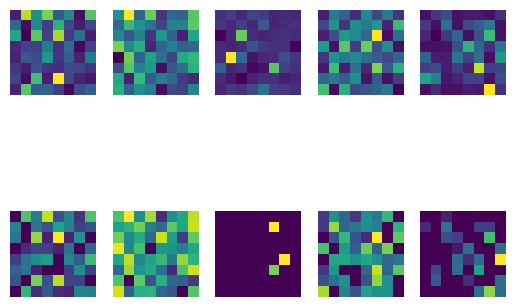

1690 tensor(0.2420, device='cuda:0', grad_fn=<MseLossBackward0>)


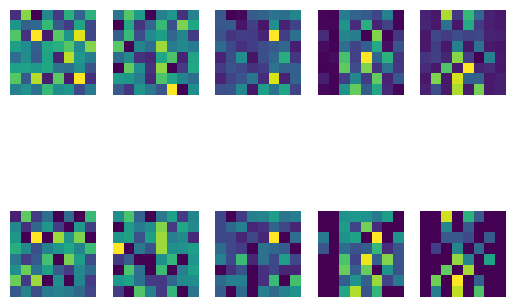

1700 tensor(0.2444, device='cuda:0', grad_fn=<MseLossBackward0>)


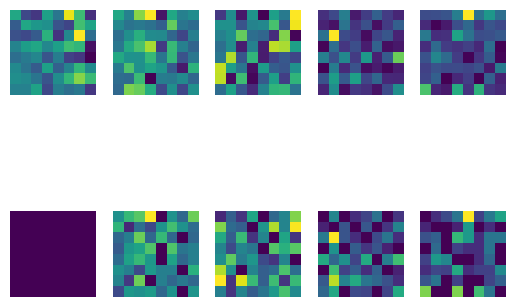

1710 tensor(0.2398, device='cuda:0', grad_fn=<MseLossBackward0>)


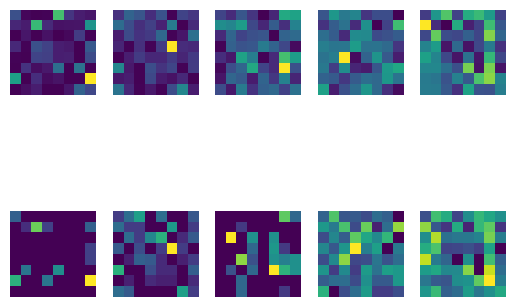

1720 tensor(0.2454, device='cuda:0', grad_fn=<MseLossBackward0>)


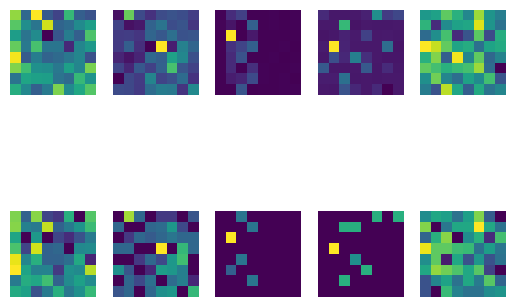

1730 tensor(0.2619, device='cuda:0', grad_fn=<MseLossBackward0>)


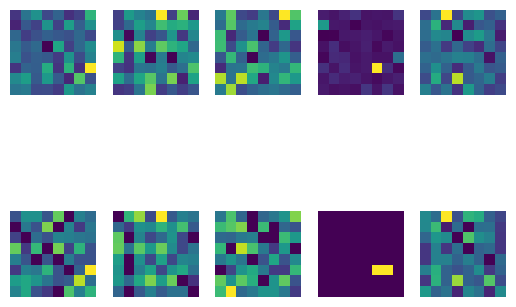

1740 tensor(0.2053, device='cuda:0', grad_fn=<MseLossBackward0>)


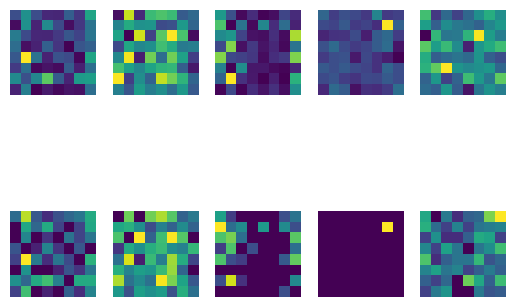

1750 tensor(0.2287, device='cuda:0', grad_fn=<MseLossBackward0>)


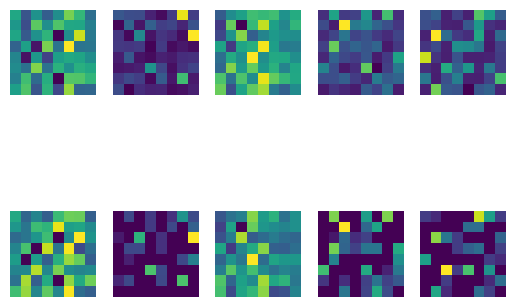

1760 tensor(0.2432, device='cuda:0', grad_fn=<MseLossBackward0>)


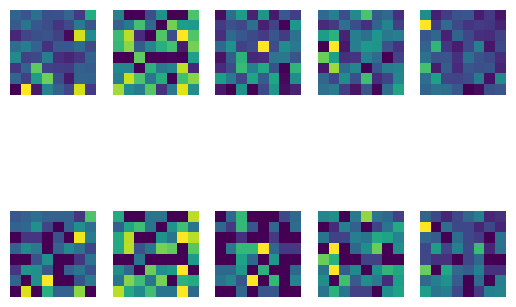

1770 tensor(0.2490, device='cuda:0', grad_fn=<MseLossBackward0>)


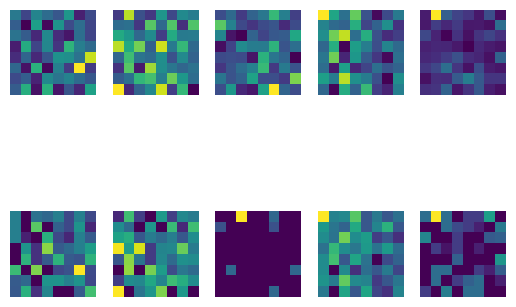

1780 tensor(0.2358, device='cuda:0', grad_fn=<MseLossBackward0>)


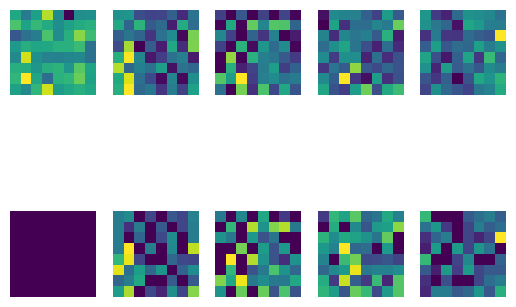

1790 tensor(0.2152, device='cuda:0', grad_fn=<MseLossBackward0>)


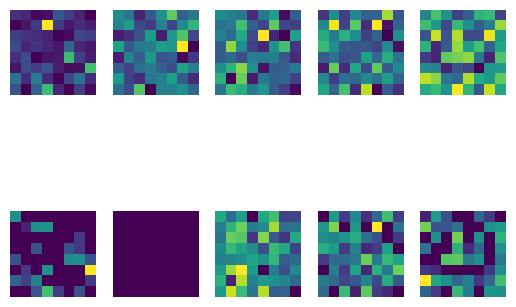

1800 tensor(0.2409, device='cuda:0', grad_fn=<MseLossBackward0>)


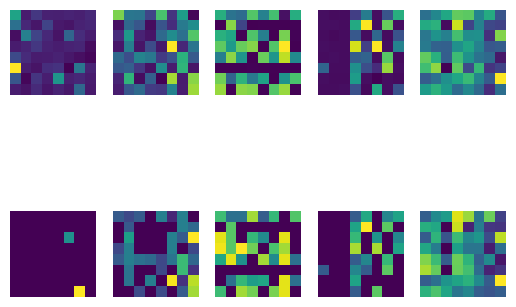

1810 tensor(0.1994, device='cuda:0', grad_fn=<MseLossBackward0>)


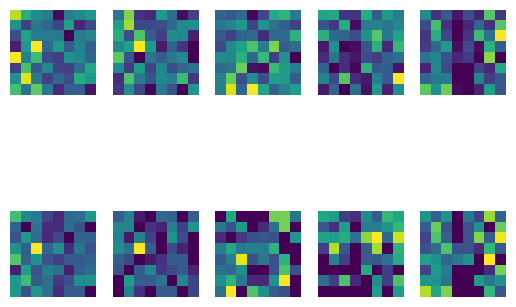

1820 tensor(0.2560, device='cuda:0', grad_fn=<MseLossBackward0>)


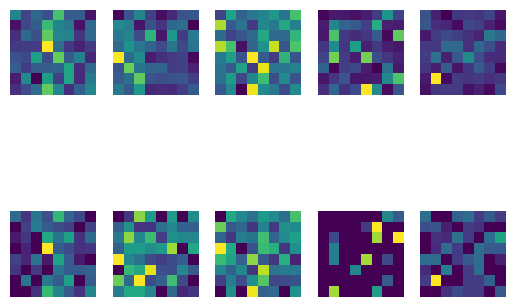

1830 tensor(0.2521, device='cuda:0', grad_fn=<MseLossBackward0>)


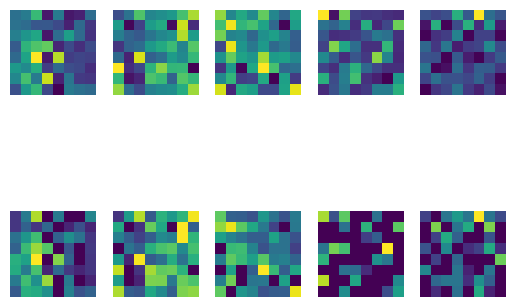

1840 tensor(0.2365, device='cuda:0', grad_fn=<MseLossBackward0>)


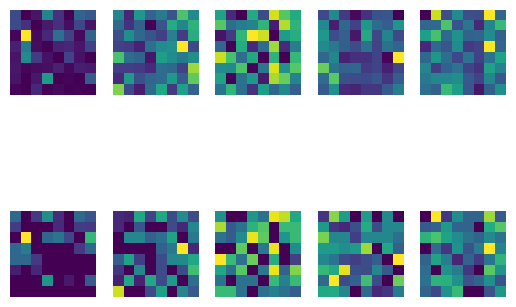

1850 tensor(0.2334, device='cuda:0', grad_fn=<MseLossBackward0>)


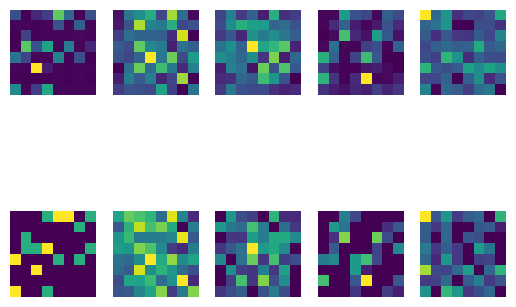

1860 tensor(0.2241, device='cuda:0', grad_fn=<MseLossBackward0>)


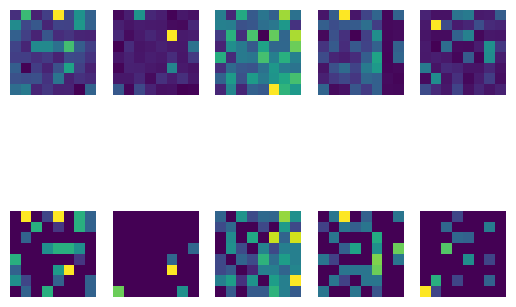

1870 tensor(0.2417, device='cuda:0', grad_fn=<MseLossBackward0>)


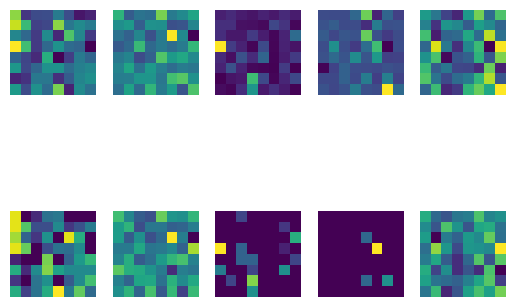

1880 tensor(0.2252, device='cuda:0', grad_fn=<MseLossBackward0>)


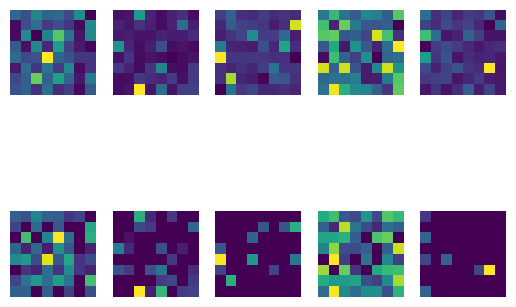

1890 tensor(0.2111, device='cuda:0', grad_fn=<MseLossBackward0>)


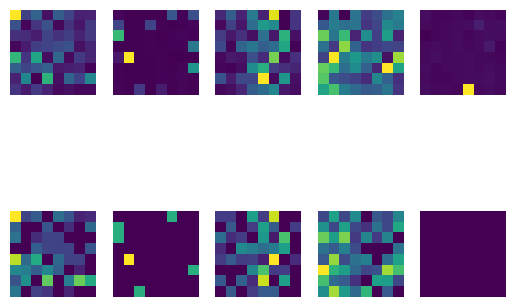

1900 tensor(0.2280, device='cuda:0', grad_fn=<MseLossBackward0>)


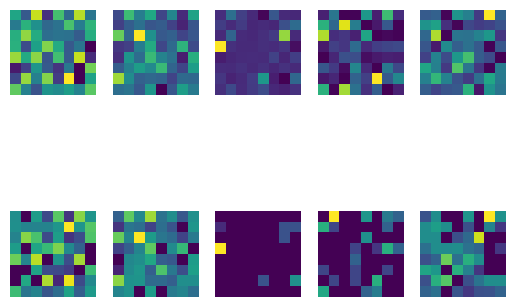

1910 tensor(0.2864, device='cuda:0', grad_fn=<MseLossBackward0>)


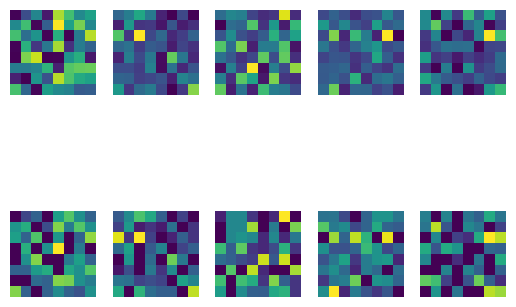

1920 tensor(0.1779, device='cuda:0', grad_fn=<MseLossBackward0>)


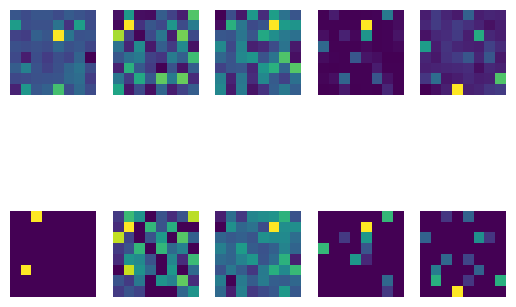

1930 tensor(0.2237, device='cuda:0', grad_fn=<MseLossBackward0>)


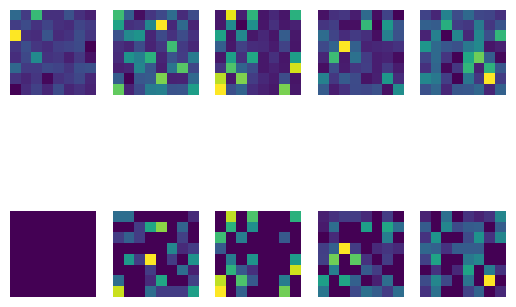

1940 tensor(0.2108, device='cuda:0', grad_fn=<MseLossBackward0>)


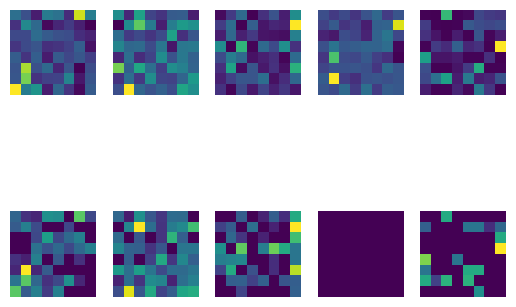

1950 tensor(0.1963, device='cuda:0', grad_fn=<MseLossBackward0>)


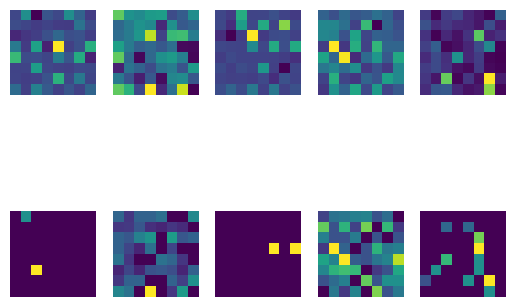

1960 tensor(0.2428, device='cuda:0', grad_fn=<MseLossBackward0>)


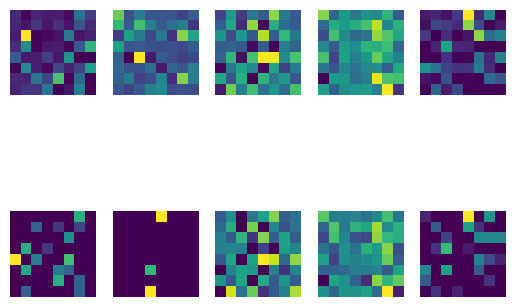

1970 tensor(0.2499, device='cuda:0', grad_fn=<MseLossBackward0>)


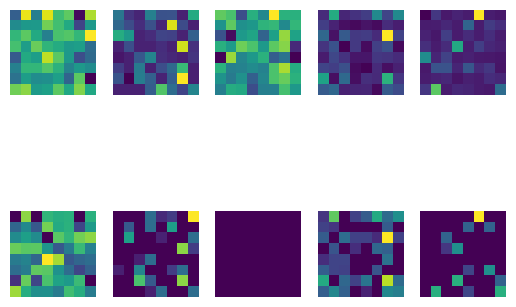

1980 tensor(0.1970, device='cuda:0', grad_fn=<MseLossBackward0>)


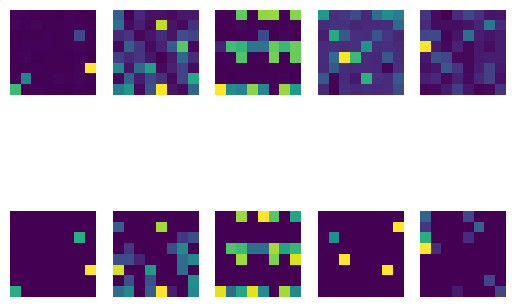

1990 tensor(0.2060, device='cuda:0', grad_fn=<MseLossBackward0>)


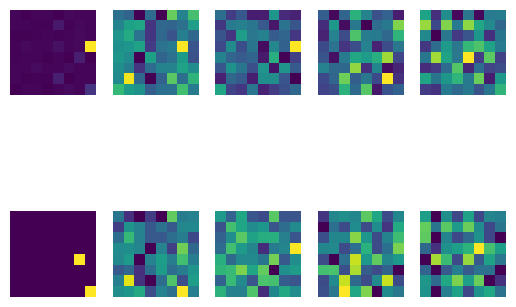

2000 tensor(0.2386, device='cuda:0', grad_fn=<MseLossBackward0>)


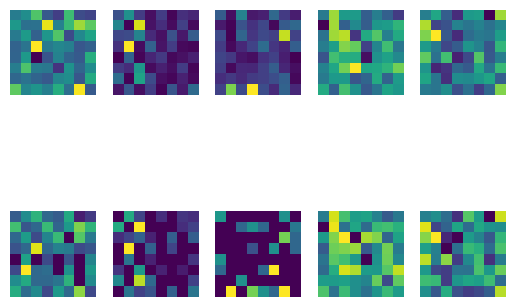

2010 tensor(0.2283, device='cuda:0', grad_fn=<MseLossBackward0>)


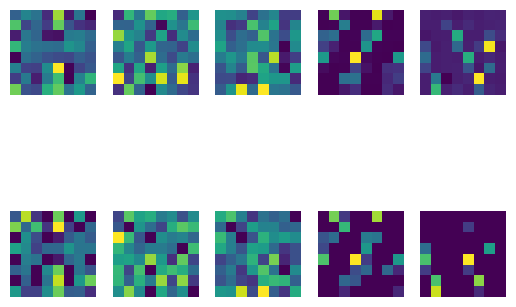

2020 tensor(0.1860, device='cuda:0', grad_fn=<MseLossBackward0>)


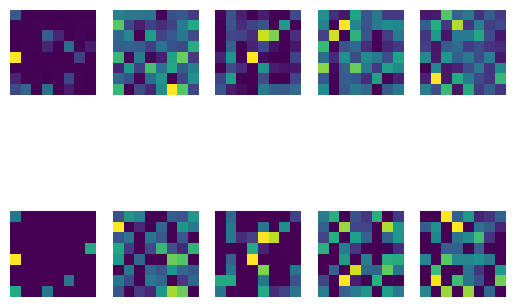

2030 tensor(0.1995, device='cuda:0', grad_fn=<MseLossBackward0>)


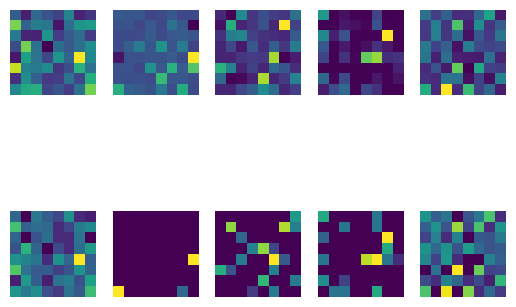

2040 tensor(0.2306, device='cuda:0', grad_fn=<MseLossBackward0>)


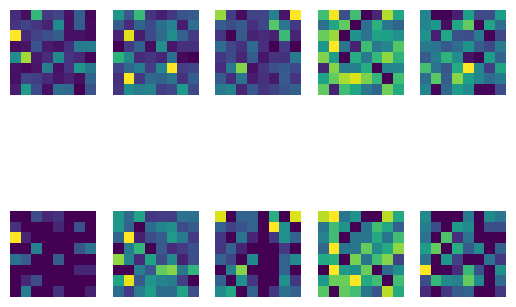

2050 tensor(0.2192, device='cuda:0', grad_fn=<MseLossBackward0>)


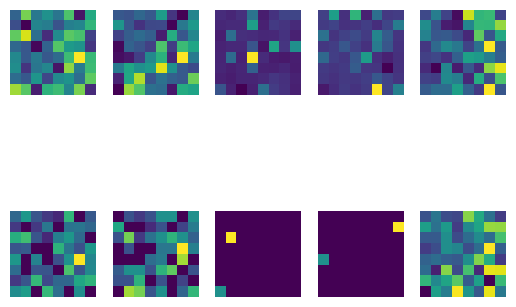

2060 tensor(0.2244, device='cuda:0', grad_fn=<MseLossBackward0>)


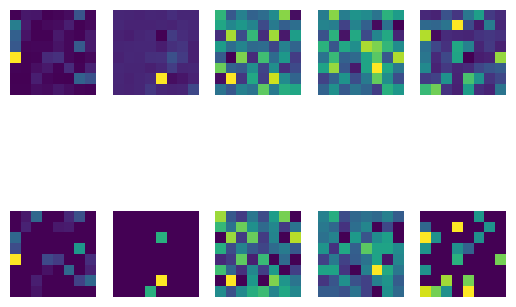

2070 tensor(0.2163, device='cuda:0', grad_fn=<MseLossBackward0>)


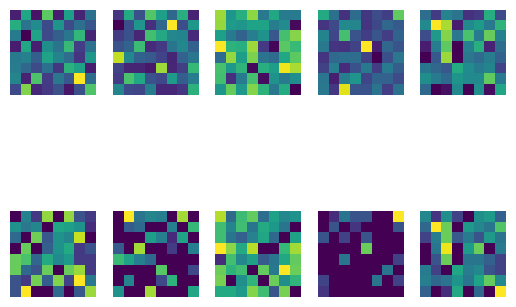

2080 tensor(0.1916, device='cuda:0', grad_fn=<MseLossBackward0>)


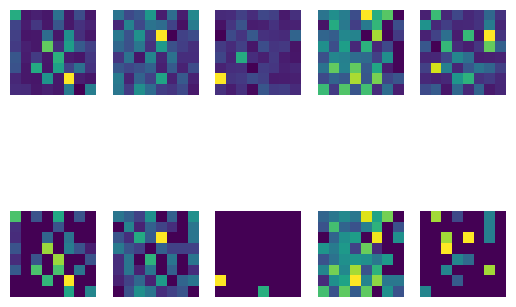

2090 tensor(0.2204, device='cuda:0', grad_fn=<MseLossBackward0>)


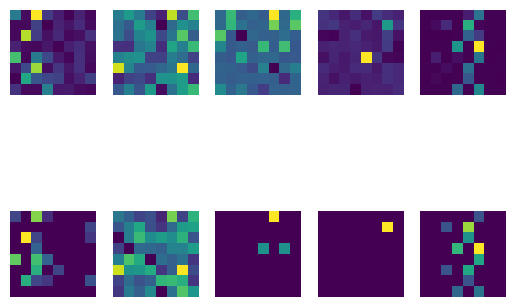

2100 tensor(0.2261, device='cuda:0', grad_fn=<MseLossBackward0>)


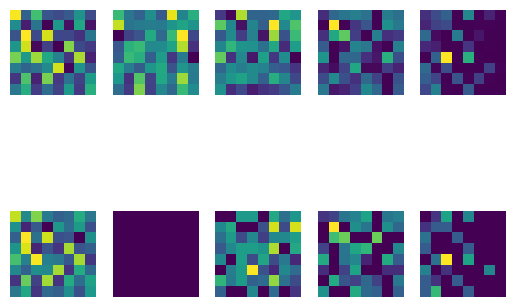

2110 tensor(0.2204, device='cuda:0', grad_fn=<MseLossBackward0>)


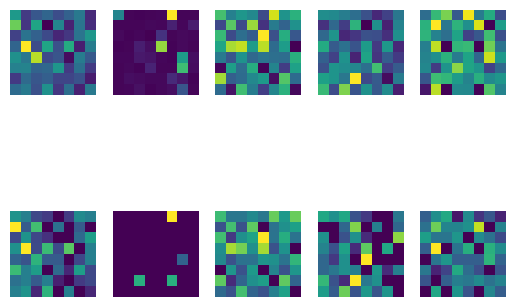

2120 tensor(0.1770, device='cuda:0', grad_fn=<MseLossBackward0>)


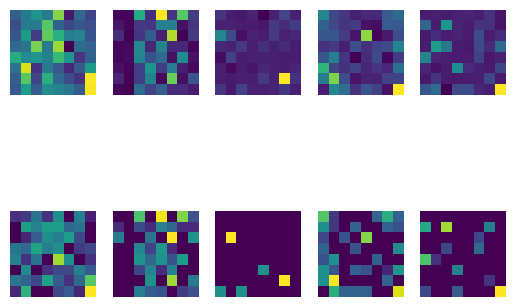

2130 tensor(0.1931, device='cuda:0', grad_fn=<MseLossBackward0>)


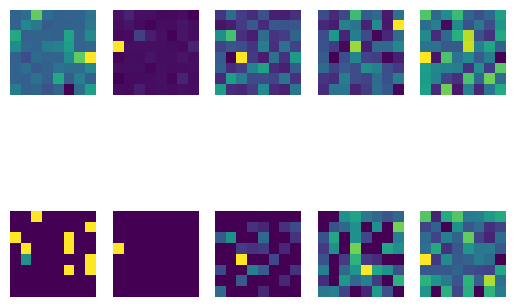

2140 tensor(0.2063, device='cuda:0', grad_fn=<MseLossBackward0>)


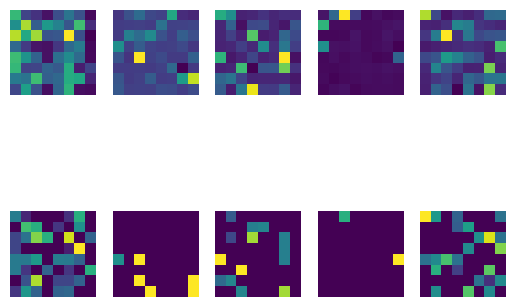

2150 tensor(0.2175, device='cuda:0', grad_fn=<MseLossBackward0>)


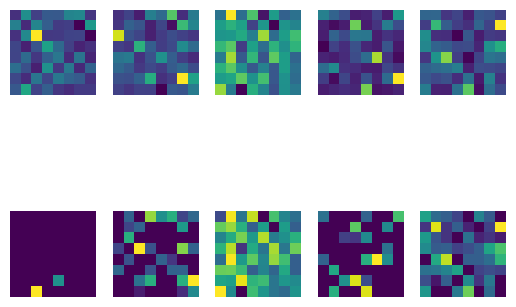

2160 tensor(0.2219, device='cuda:0', grad_fn=<MseLossBackward0>)


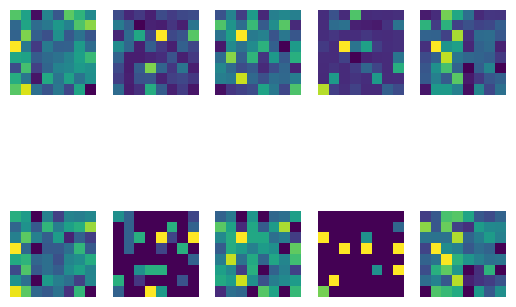

2170 tensor(0.2497, device='cuda:0', grad_fn=<MseLossBackward0>)


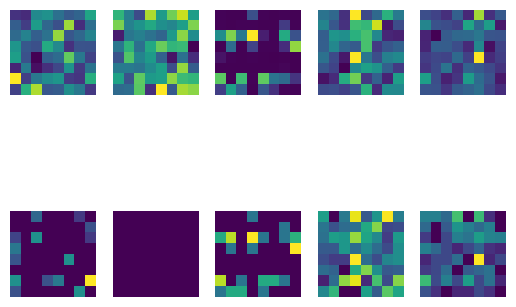

2180 tensor(0.1986, device='cuda:0', grad_fn=<MseLossBackward0>)


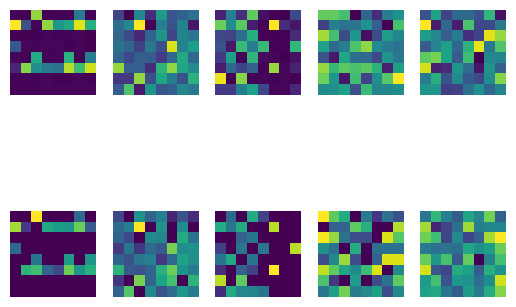

2190 tensor(0.2170, device='cuda:0', grad_fn=<MseLossBackward0>)


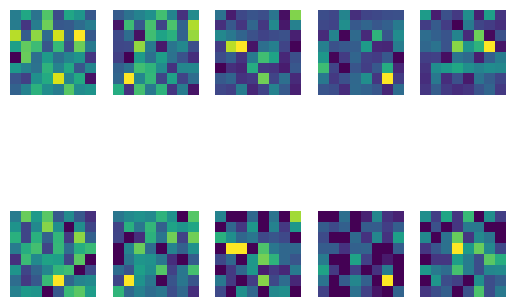

2200 tensor(0.2164, device='cuda:0', grad_fn=<MseLossBackward0>)


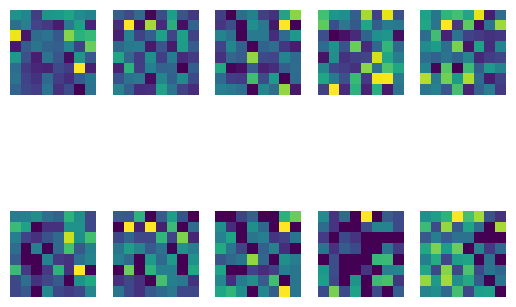

2210 tensor(0.1828, device='cuda:0', grad_fn=<MseLossBackward0>)


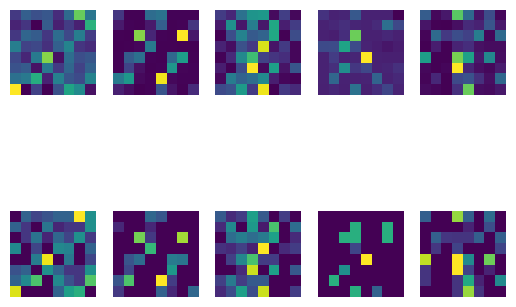

2220 tensor(0.2188, device='cuda:0', grad_fn=<MseLossBackward0>)


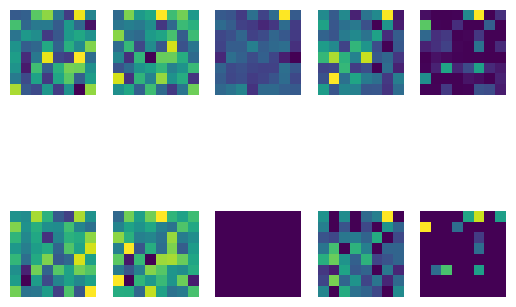

2230 tensor(0.1784, device='cuda:0', grad_fn=<MseLossBackward0>)


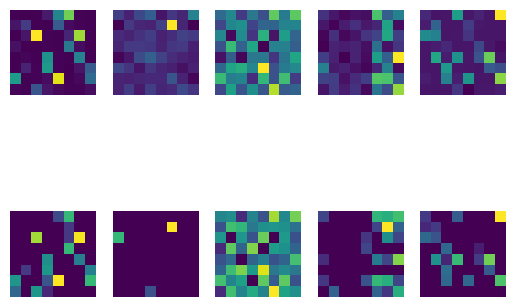

2240 tensor(0.2048, device='cuda:0', grad_fn=<MseLossBackward0>)


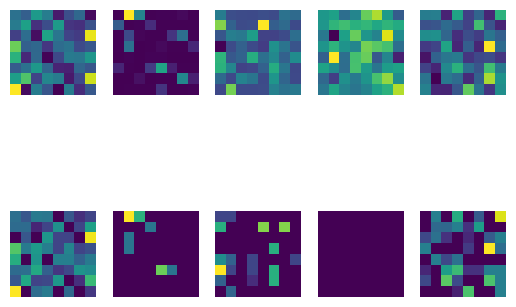

2250 tensor(0.1925, device='cuda:0', grad_fn=<MseLossBackward0>)


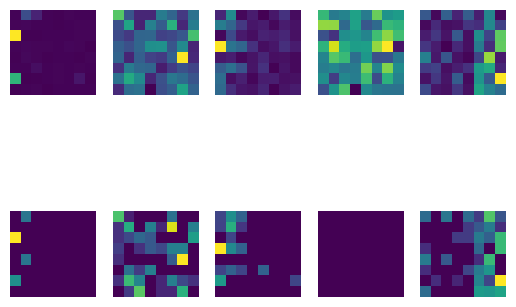

2260 tensor(0.2359, device='cuda:0', grad_fn=<MseLossBackward0>)


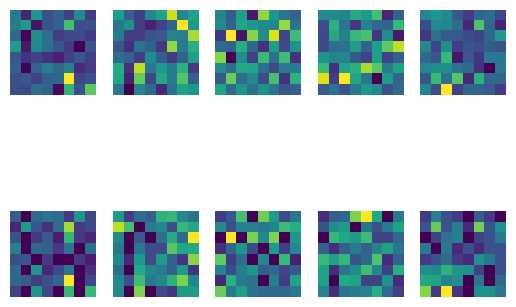

2270 tensor(0.2003, device='cuda:0', grad_fn=<MseLossBackward0>)


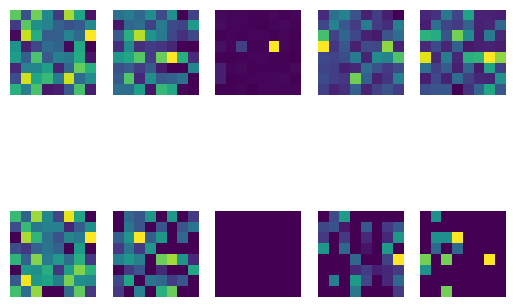

2280 tensor(0.1934, device='cuda:0', grad_fn=<MseLossBackward0>)


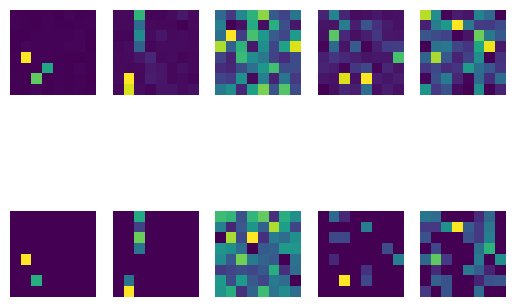

2290 tensor(0.1968, device='cuda:0', grad_fn=<MseLossBackward0>)


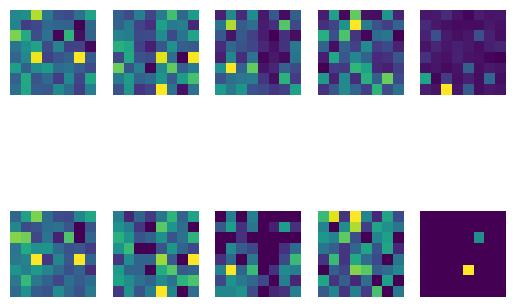

2300 tensor(0.2235, device='cuda:0', grad_fn=<MseLossBackward0>)


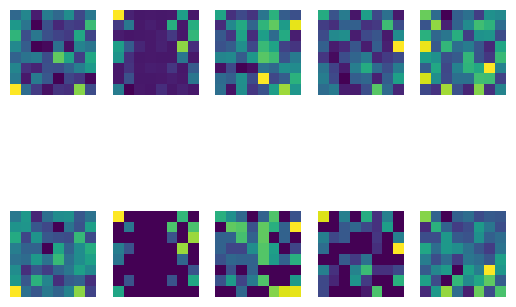

2310 tensor(0.2139, device='cuda:0', grad_fn=<MseLossBackward0>)


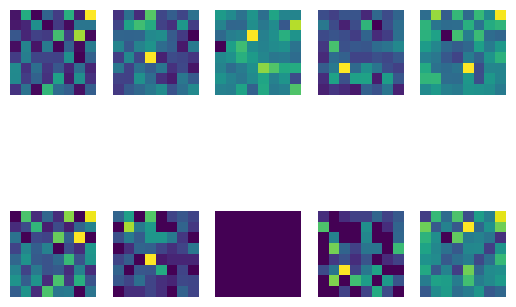

2320 tensor(0.1917, device='cuda:0', grad_fn=<MseLossBackward0>)


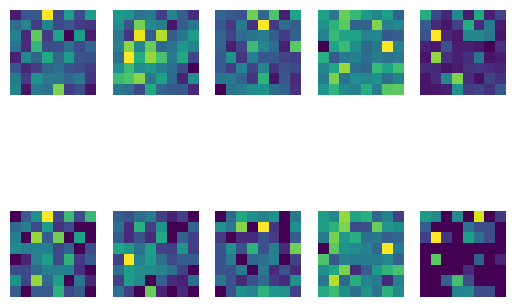

2330 tensor(0.2235, device='cuda:0', grad_fn=<MseLossBackward0>)


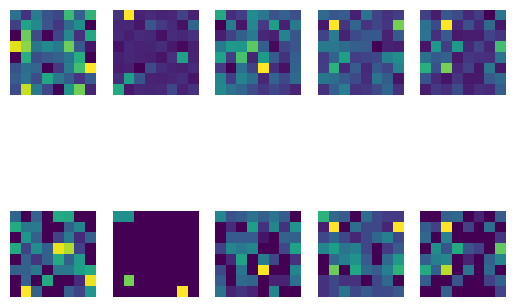

2340 tensor(0.1761, device='cuda:0', grad_fn=<MseLossBackward0>)


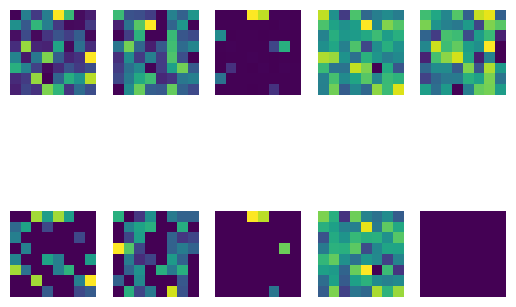

2350 tensor(0.2149, device='cuda:0', grad_fn=<MseLossBackward0>)


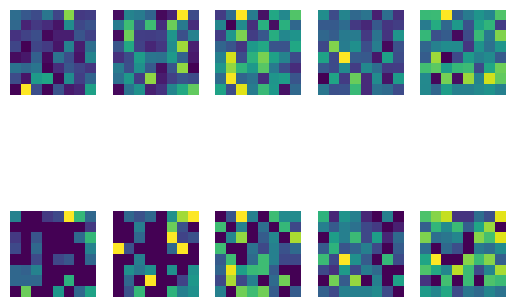

2360 tensor(0.1810, device='cuda:0', grad_fn=<MseLossBackward0>)


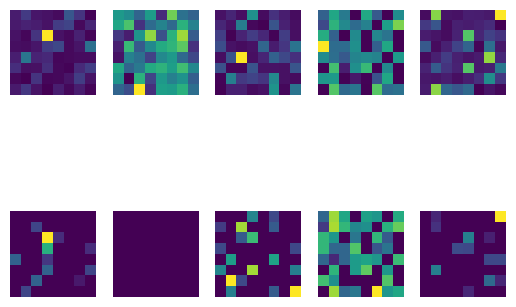

2370 tensor(0.1851, device='cuda:0', grad_fn=<MseLossBackward0>)


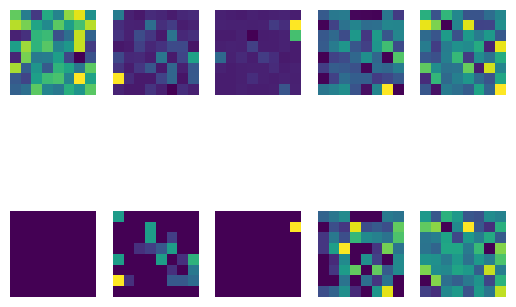

2380 tensor(0.2046, device='cuda:0', grad_fn=<MseLossBackward0>)


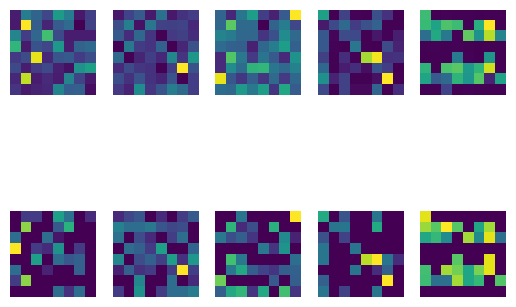

2390 tensor(0.2273, device='cuda:0', grad_fn=<MseLossBackward0>)


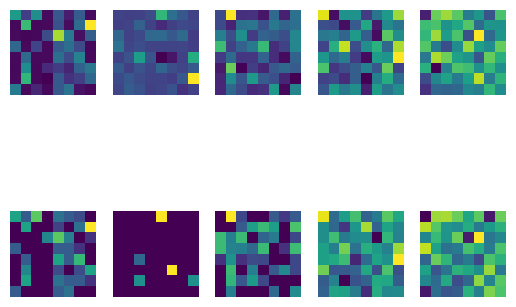

2400 tensor(0.1969, device='cuda:0', grad_fn=<MseLossBackward0>)


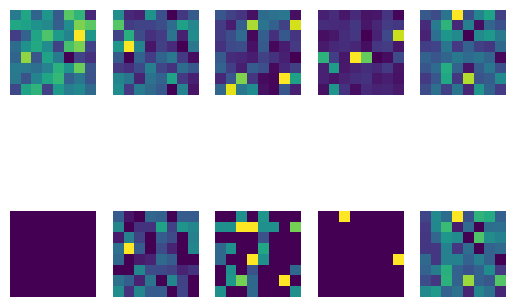

2410 tensor(0.1917, device='cuda:0', grad_fn=<MseLossBackward0>)


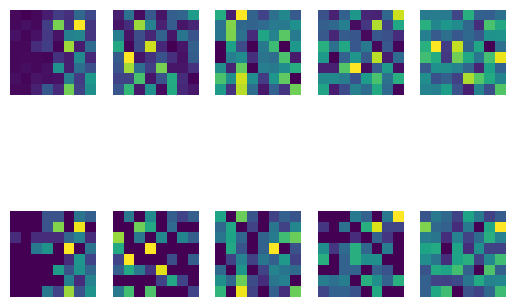

2420 tensor(0.2194, device='cuda:0', grad_fn=<MseLossBackward0>)


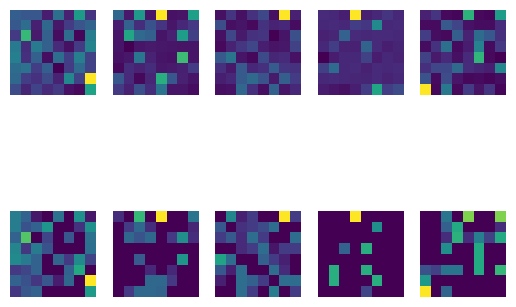

2430 tensor(0.2324, device='cuda:0', grad_fn=<MseLossBackward0>)


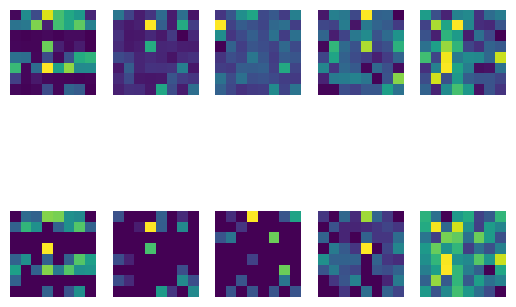

2440 tensor(0.2149, device='cuda:0', grad_fn=<MseLossBackward0>)


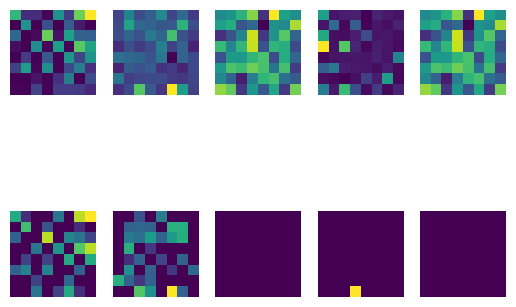

2450 tensor(0.1797, device='cuda:0', grad_fn=<MseLossBackward0>)


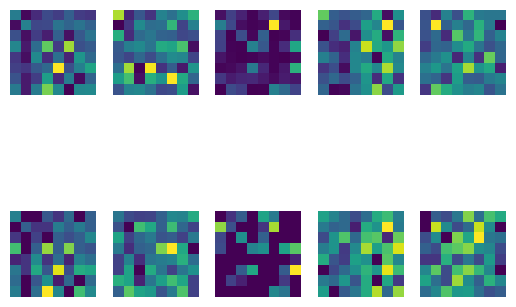

2460 tensor(0.2027, device='cuda:0', grad_fn=<MseLossBackward0>)


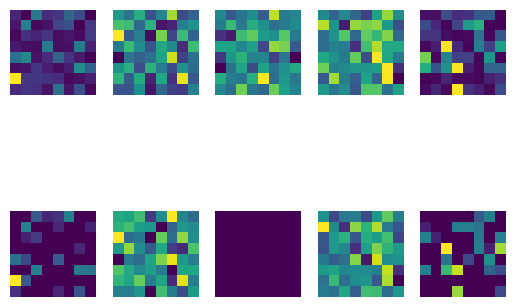

2470 tensor(0.2192, device='cuda:0', grad_fn=<MseLossBackward0>)


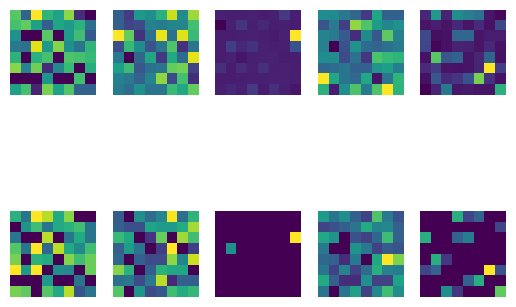

2480 tensor(0.1884, device='cuda:0', grad_fn=<MseLossBackward0>)


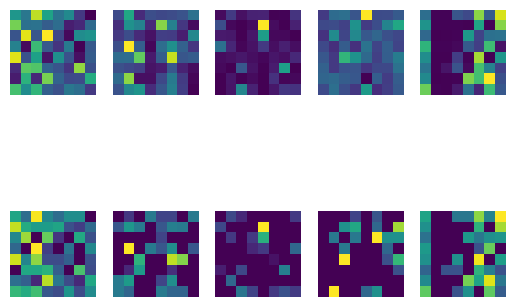

2490 tensor(0.2249, device='cuda:0', grad_fn=<MseLossBackward0>)


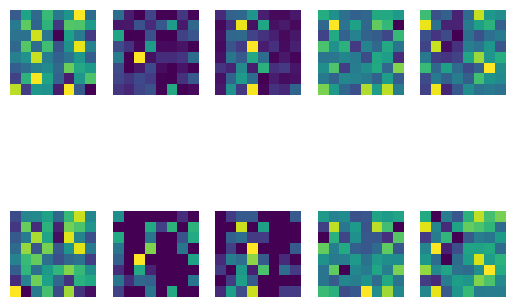

2500 tensor(0.1841, device='cuda:0', grad_fn=<MseLossBackward0>)


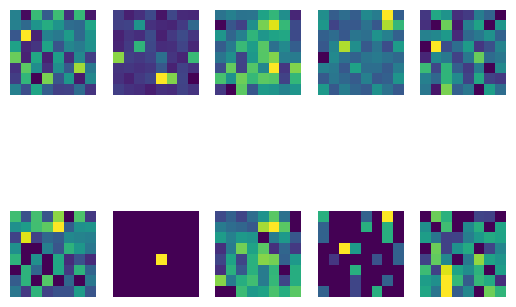

2510 tensor(0.1889, device='cuda:0', grad_fn=<MseLossBackward0>)


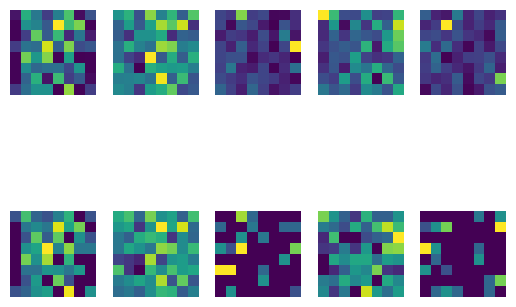

2520 tensor(0.2005, device='cuda:0', grad_fn=<MseLossBackward0>)


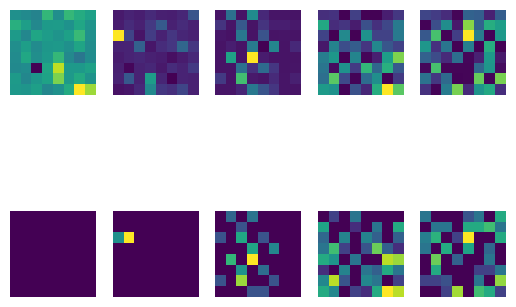

2530 tensor(0.2016, device='cuda:0', grad_fn=<MseLossBackward0>)


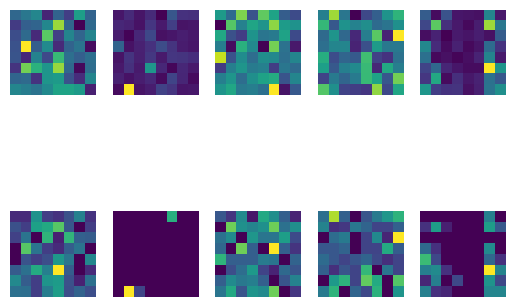

2540 tensor(0.2013, device='cuda:0', grad_fn=<MseLossBackward0>)


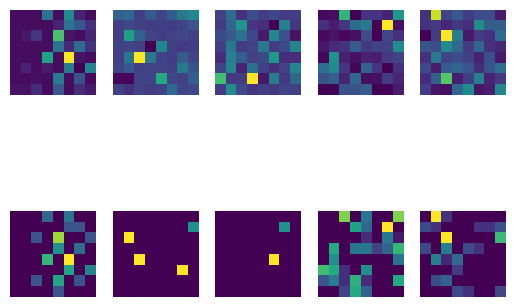

2550 tensor(0.2000, device='cuda:0', grad_fn=<MseLossBackward0>)


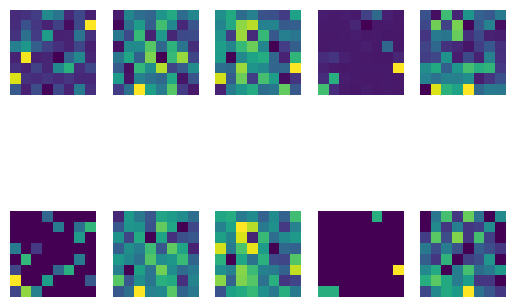

2560 tensor(0.1839, device='cuda:0', grad_fn=<MseLossBackward0>)


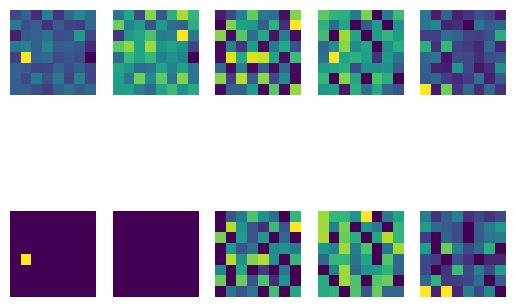

2570 tensor(0.2092, device='cuda:0', grad_fn=<MseLossBackward0>)


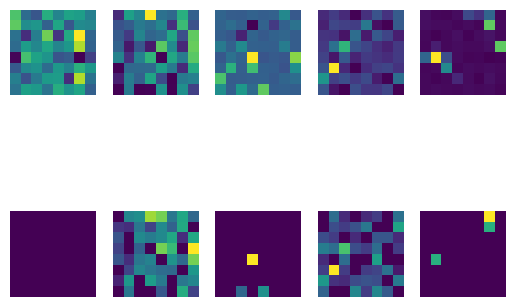

2580 tensor(0.2156, device='cuda:0', grad_fn=<MseLossBackward0>)


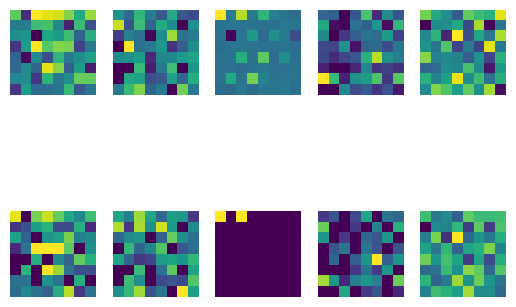

2590 tensor(0.1976, device='cuda:0', grad_fn=<MseLossBackward0>)


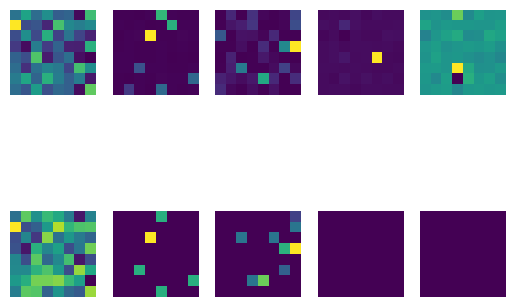

2600 tensor(0.1929, device='cuda:0', grad_fn=<MseLossBackward0>)


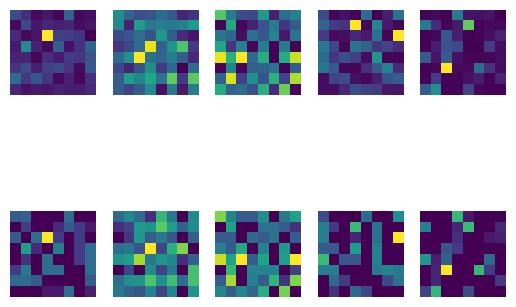

2610 tensor(0.2159, device='cuda:0', grad_fn=<MseLossBackward0>)


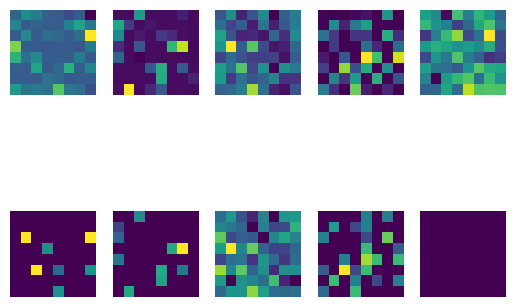

2620 tensor(0.2009, device='cuda:0', grad_fn=<MseLossBackward0>)


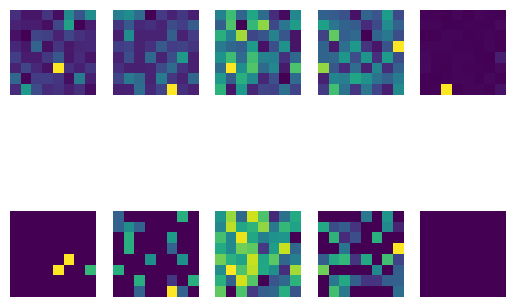

2630 tensor(0.1836, device='cuda:0', grad_fn=<MseLossBackward0>)


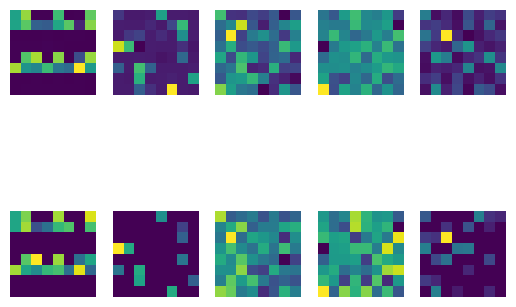

2640 tensor(0.1894, device='cuda:0', grad_fn=<MseLossBackward0>)


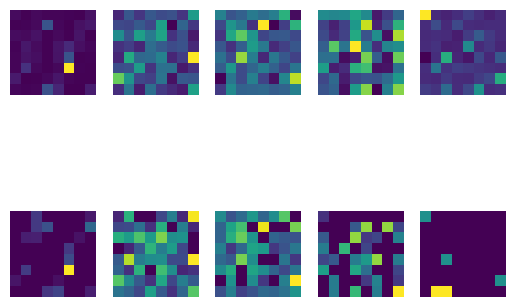

2650 tensor(0.2030, device='cuda:0', grad_fn=<MseLossBackward0>)


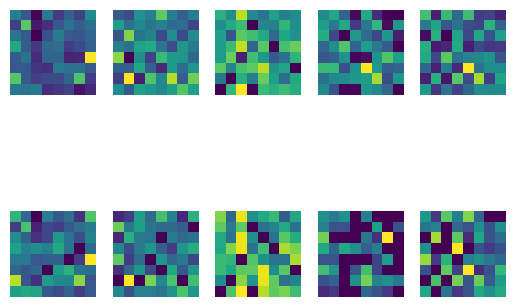

2660 tensor(0.2002, device='cuda:0', grad_fn=<MseLossBackward0>)


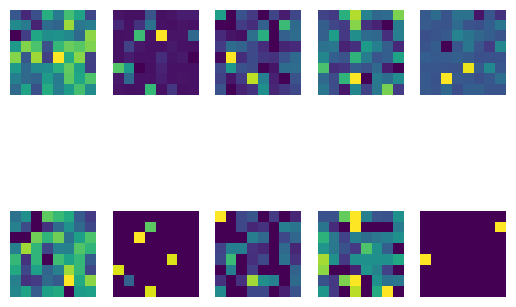

2670 tensor(0.2015, device='cuda:0', grad_fn=<MseLossBackward0>)


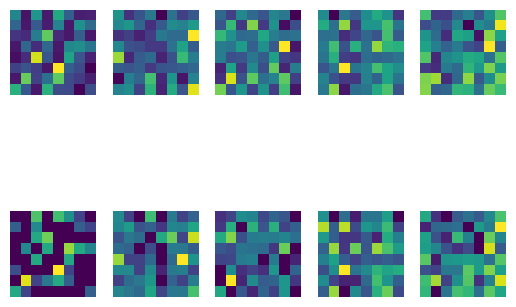

2680 tensor(0.2175, device='cuda:0', grad_fn=<MseLossBackward0>)


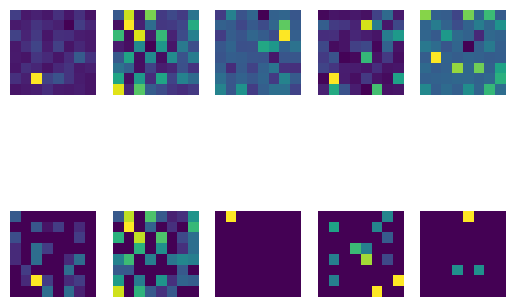

2690 tensor(0.1992, device='cuda:0', grad_fn=<MseLossBackward0>)


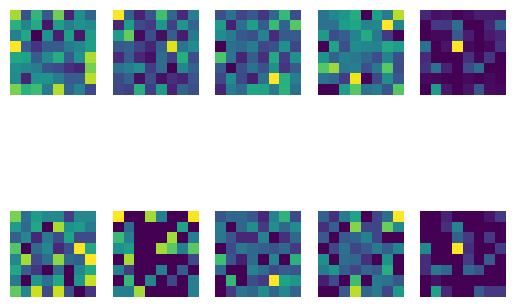

2700 tensor(0.2079, device='cuda:0', grad_fn=<MseLossBackward0>)


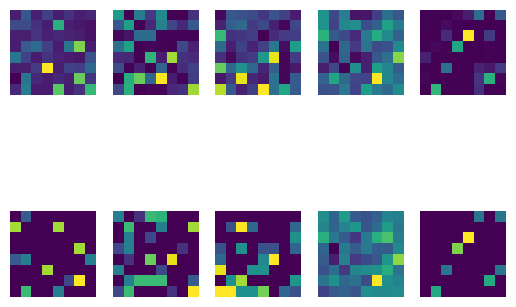

2710 tensor(0.2005, device='cuda:0', grad_fn=<MseLossBackward0>)


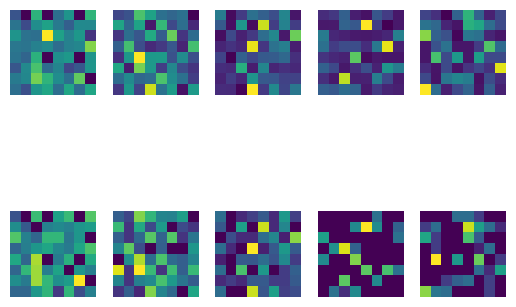

2720 tensor(0.2131, device='cuda:0', grad_fn=<MseLossBackward0>)


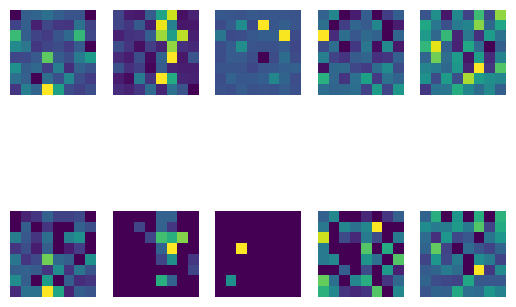

2730 tensor(0.2238, device='cuda:0', grad_fn=<MseLossBackward0>)


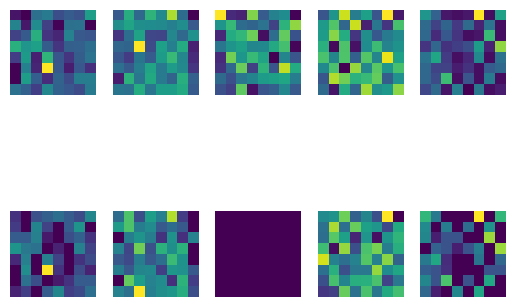

2740 tensor(0.2053, device='cuda:0', grad_fn=<MseLossBackward0>)


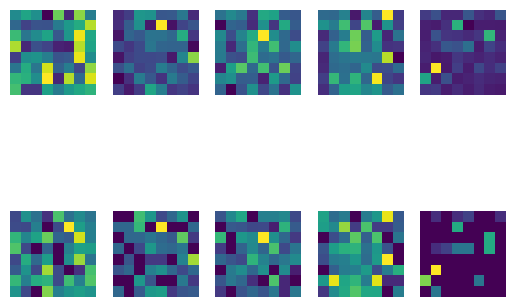

2750 tensor(0.2106, device='cuda:0', grad_fn=<MseLossBackward0>)


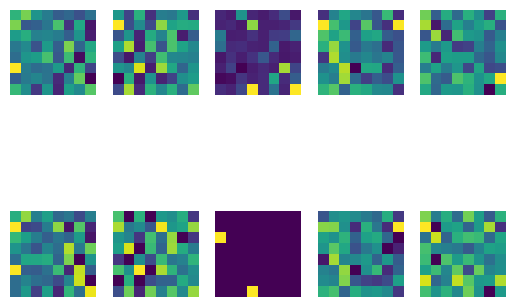

2760 tensor(0.2263, device='cuda:0', grad_fn=<MseLossBackward0>)


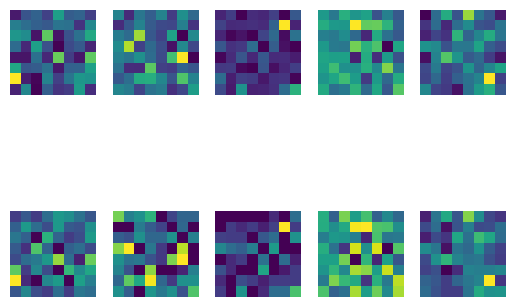

2770 tensor(0.2329, device='cuda:0', grad_fn=<MseLossBackward0>)


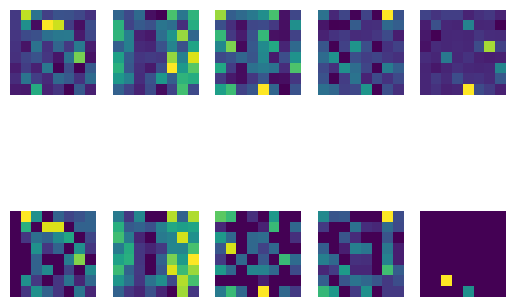

2780 tensor(0.1768, device='cuda:0', grad_fn=<MseLossBackward0>)


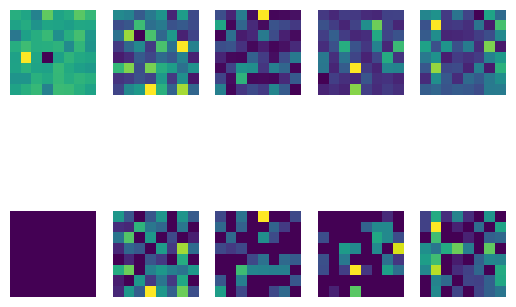

2790 tensor(0.1767, device='cuda:0', grad_fn=<MseLossBackward0>)


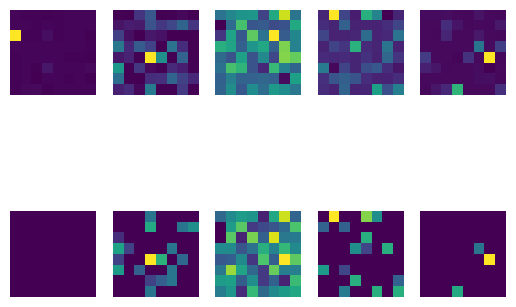

2800 tensor(0.1819, device='cuda:0', grad_fn=<MseLossBackward0>)


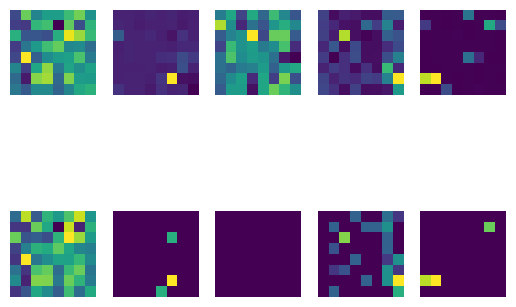

2810 tensor(0.2281, device='cuda:0', grad_fn=<MseLossBackward0>)


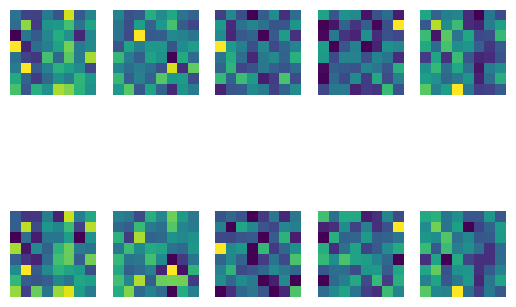

2820 tensor(0.2013, device='cuda:0', grad_fn=<MseLossBackward0>)


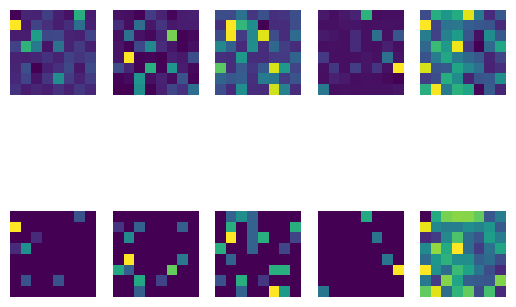

2830 tensor(0.1880, device='cuda:0', grad_fn=<MseLossBackward0>)


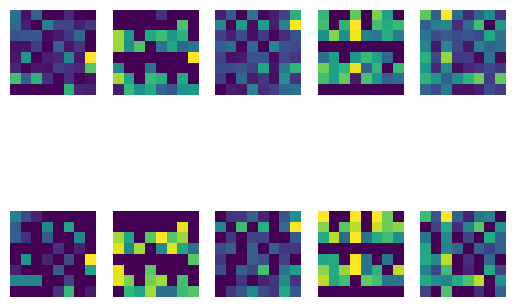

2840 tensor(0.2125, device='cuda:0', grad_fn=<MseLossBackward0>)


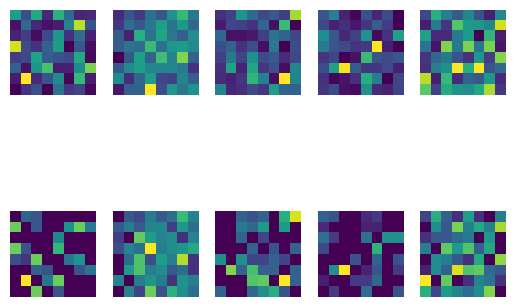

2850 tensor(0.1933, device='cuda:0', grad_fn=<MseLossBackward0>)


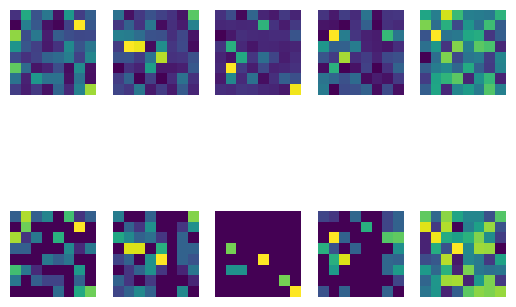

2860 tensor(0.1998, device='cuda:0', grad_fn=<MseLossBackward0>)


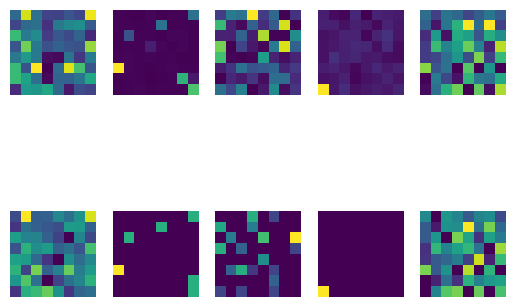

2870 tensor(0.2034, device='cuda:0', grad_fn=<MseLossBackward0>)


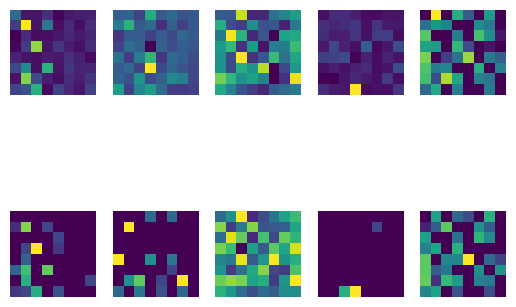

2880 tensor(0.2319, device='cuda:0', grad_fn=<MseLossBackward0>)


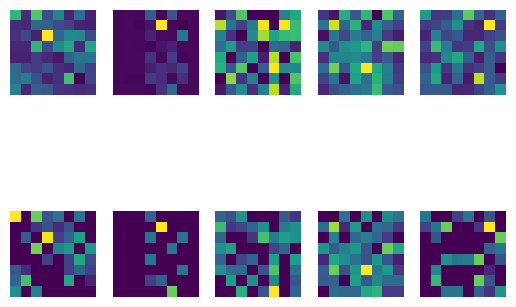

2890 tensor(0.1809, device='cuda:0', grad_fn=<MseLossBackward0>)


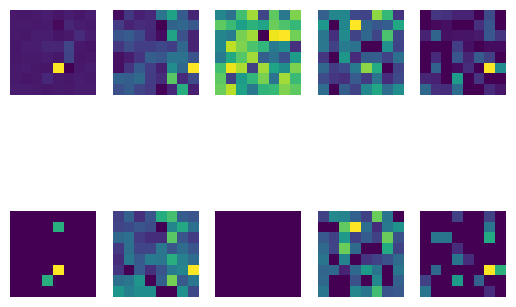

2900 tensor(0.1862, device='cuda:0', grad_fn=<MseLossBackward0>)


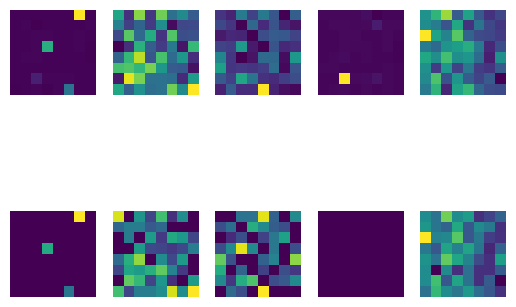

2910 tensor(0.1872, device='cuda:0', grad_fn=<MseLossBackward0>)


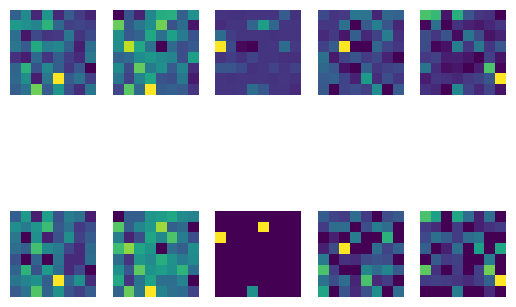

2920 tensor(0.1644, device='cuda:0', grad_fn=<MseLossBackward0>)


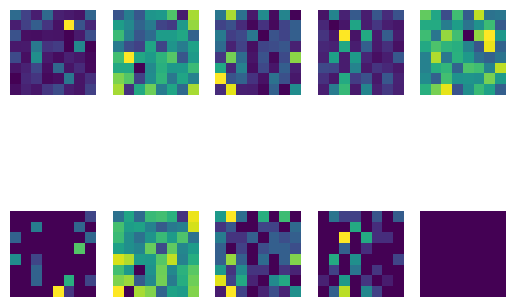

2930 tensor(0.1955, device='cuda:0', grad_fn=<MseLossBackward0>)


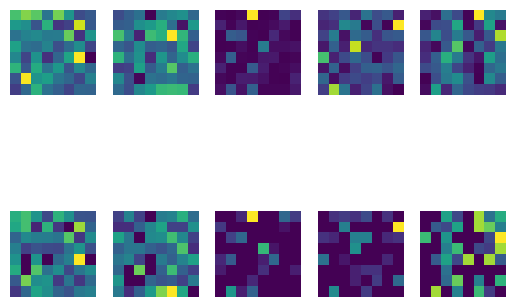

2940 tensor(0.1887, device='cuda:0', grad_fn=<MseLossBackward0>)


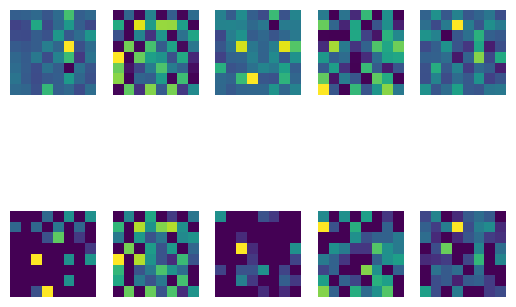

2950 tensor(0.1708, device='cuda:0', grad_fn=<MseLossBackward0>)


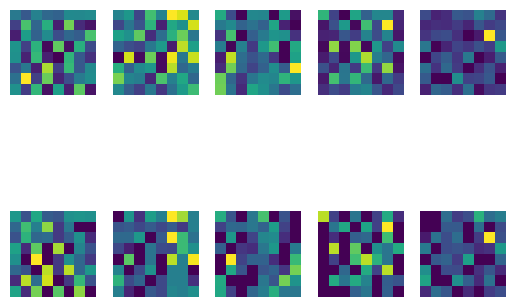

2960 tensor(0.2011, device='cuda:0', grad_fn=<MseLossBackward0>)


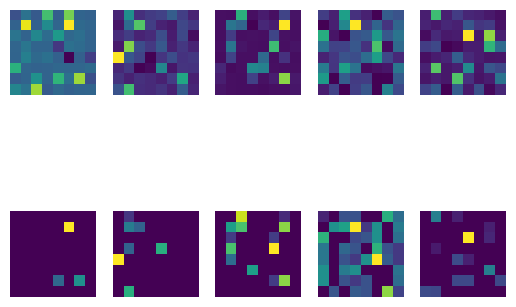

2970 tensor(0.1907, device='cuda:0', grad_fn=<MseLossBackward0>)


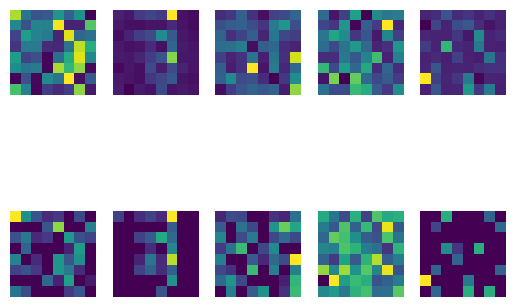

2980 tensor(0.2041, device='cuda:0', grad_fn=<MseLossBackward0>)


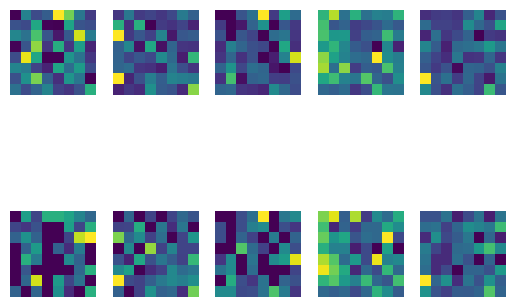

2990 tensor(0.2218, device='cuda:0', grad_fn=<MseLossBackward0>)


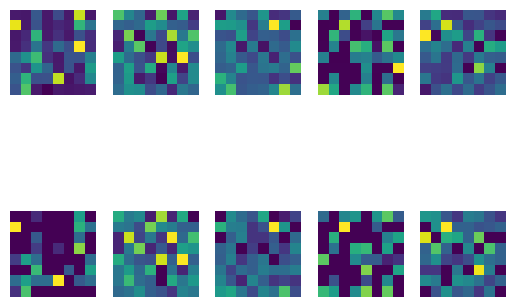

3000 tensor(0.1803, device='cuda:0', grad_fn=<MseLossBackward0>)


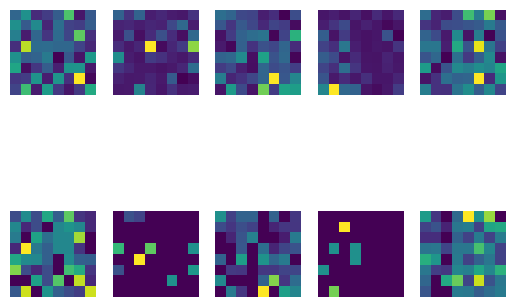

3010 tensor(0.1989, device='cuda:0', grad_fn=<MseLossBackward0>)


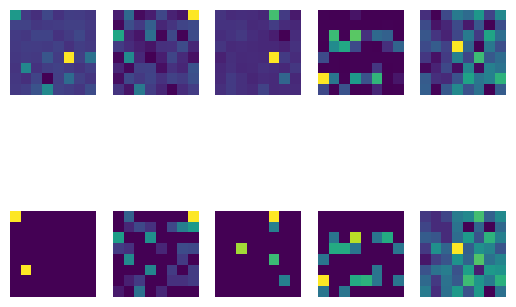

3020 tensor(0.1907, device='cuda:0', grad_fn=<MseLossBackward0>)


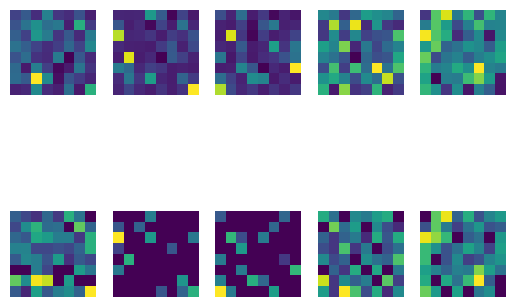

3030 tensor(0.1898, device='cuda:0', grad_fn=<MseLossBackward0>)


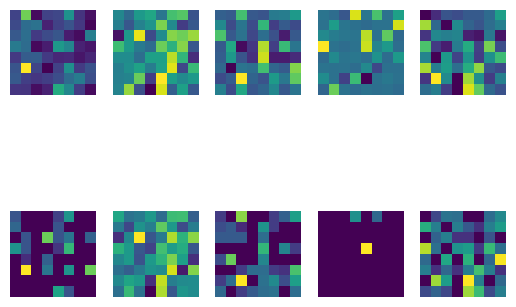

3040 tensor(0.1840, device='cuda:0', grad_fn=<MseLossBackward0>)


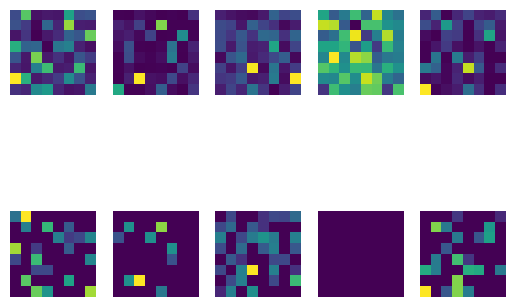

3050 tensor(0.1844, device='cuda:0', grad_fn=<MseLossBackward0>)


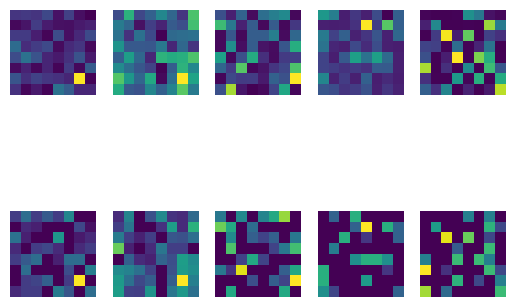

3060 tensor(0.1991, device='cuda:0', grad_fn=<MseLossBackward0>)


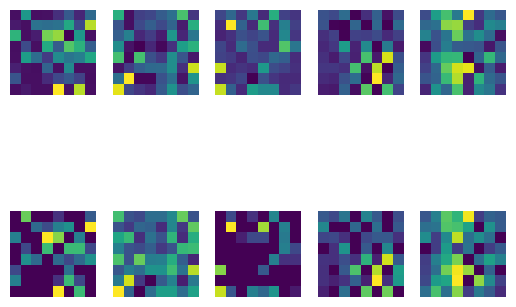

3070 tensor(0.1660, device='cuda:0', grad_fn=<MseLossBackward0>)


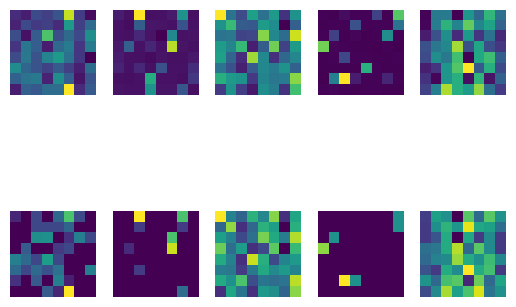

3080 tensor(0.2018, device='cuda:0', grad_fn=<MseLossBackward0>)


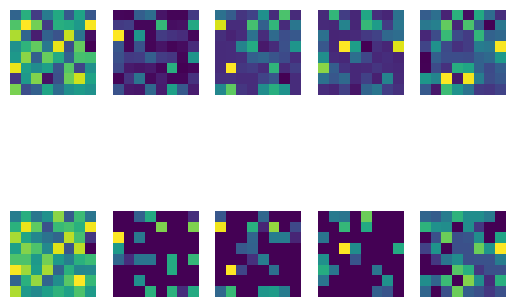

3090 tensor(0.1777, device='cuda:0', grad_fn=<MseLossBackward0>)


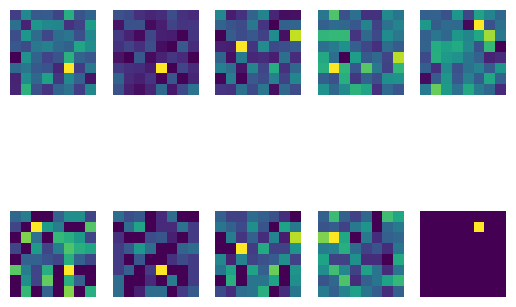

3100 tensor(0.1876, device='cuda:0', grad_fn=<MseLossBackward0>)


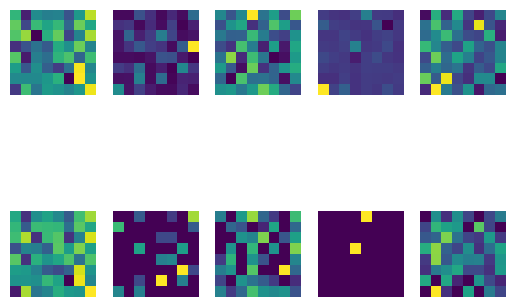

3110 tensor(0.1611, device='cuda:0', grad_fn=<MseLossBackward0>)


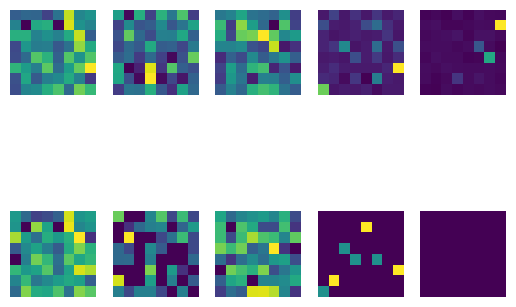

3120 tensor(0.1717, device='cuda:0', grad_fn=<MseLossBackward0>)


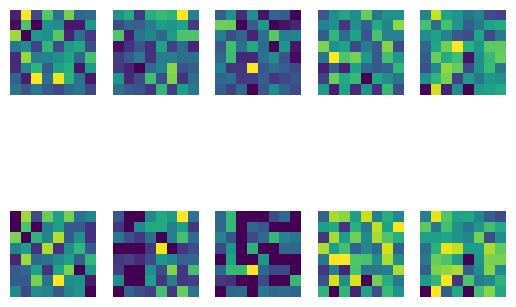

3130 tensor(0.2046, device='cuda:0', grad_fn=<MseLossBackward0>)


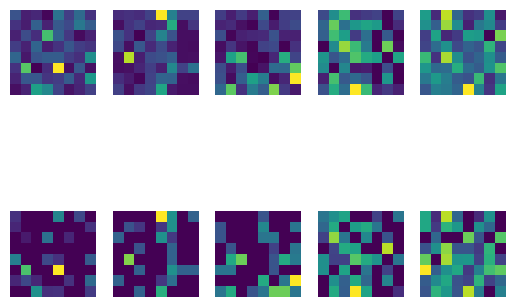

3140 tensor(0.2027, device='cuda:0', grad_fn=<MseLossBackward0>)


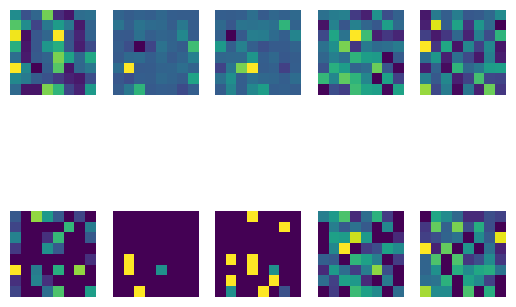

3150 tensor(0.1914, device='cuda:0', grad_fn=<MseLossBackward0>)


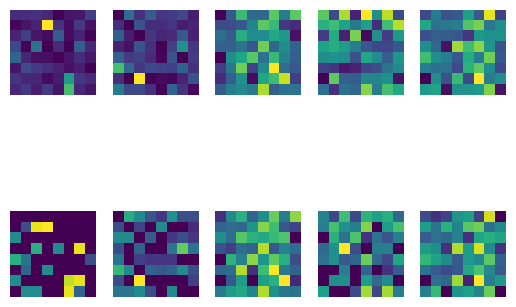

3160 tensor(0.2225, device='cuda:0', grad_fn=<MseLossBackward0>)


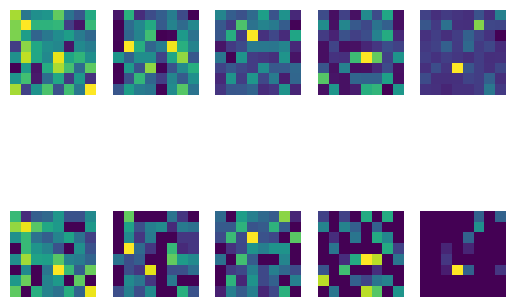

3170 tensor(0.1936, device='cuda:0', grad_fn=<MseLossBackward0>)


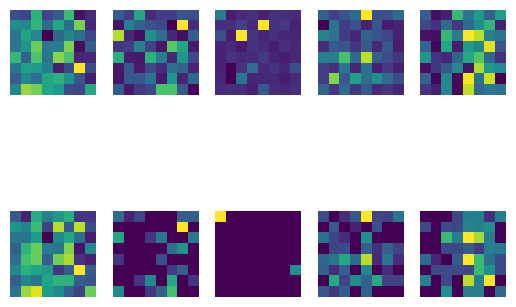

3180 tensor(0.1845, device='cuda:0', grad_fn=<MseLossBackward0>)


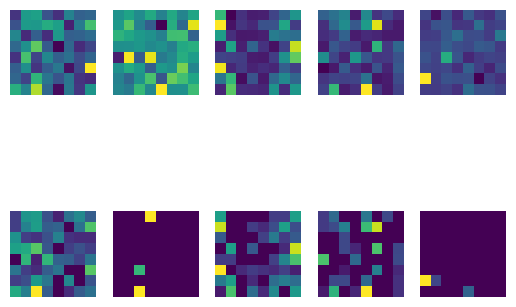

3190 tensor(0.1754, device='cuda:0', grad_fn=<MseLossBackward0>)


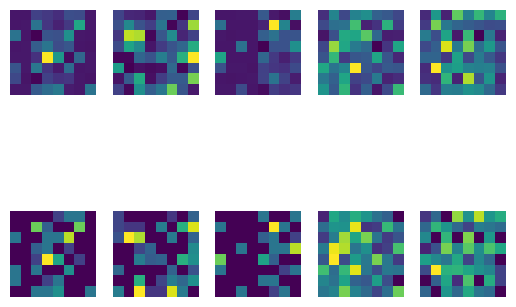

3200 tensor(0.2056, device='cuda:0', grad_fn=<MseLossBackward0>)


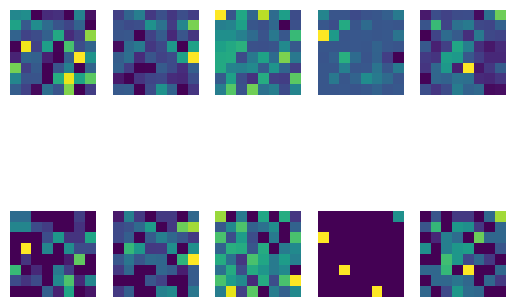

3210 tensor(0.1943, device='cuda:0', grad_fn=<MseLossBackward0>)


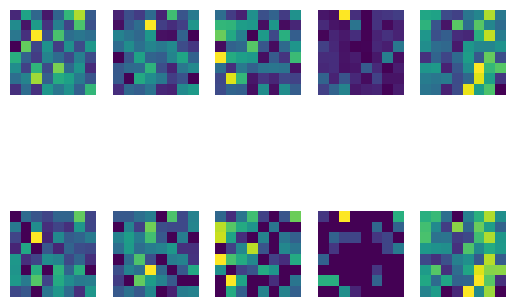

3220 tensor(0.1780, device='cuda:0', grad_fn=<MseLossBackward0>)


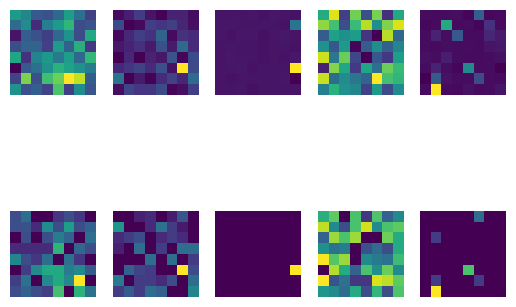

3230 tensor(0.2054, device='cuda:0', grad_fn=<MseLossBackward0>)


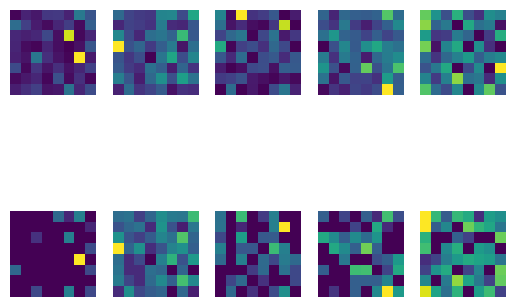

3240 tensor(0.2227, device='cuda:0', grad_fn=<MseLossBackward0>)


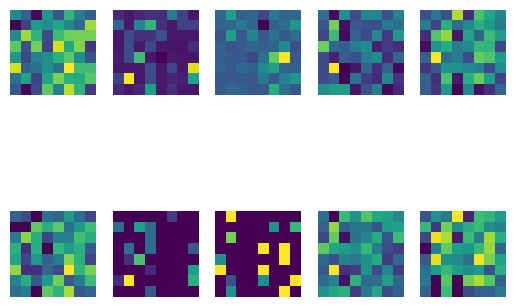

3250 tensor(0.1889, device='cuda:0', grad_fn=<MseLossBackward0>)


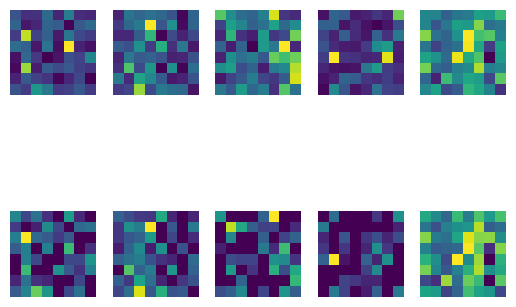

3260 tensor(0.1967, device='cuda:0', grad_fn=<MseLossBackward0>)


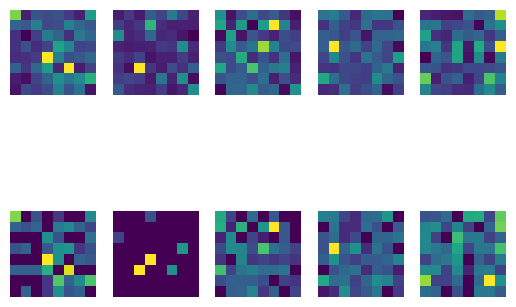

3270 tensor(0.1654, device='cuda:0', grad_fn=<MseLossBackward0>)


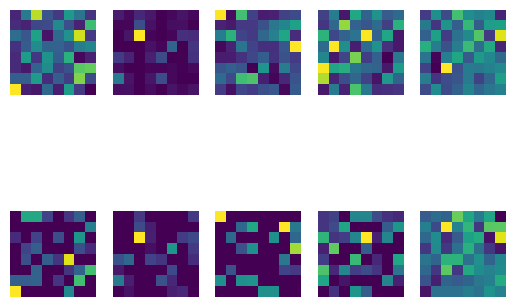

3280 tensor(0.1805, device='cuda:0', grad_fn=<MseLossBackward0>)


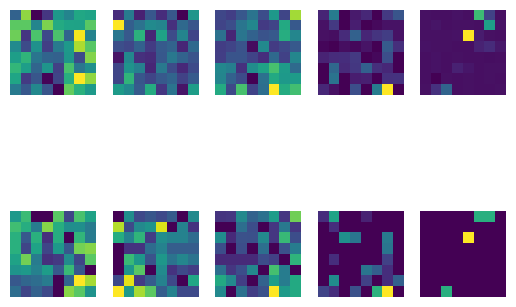

3290 tensor(0.1942, device='cuda:0', grad_fn=<MseLossBackward0>)


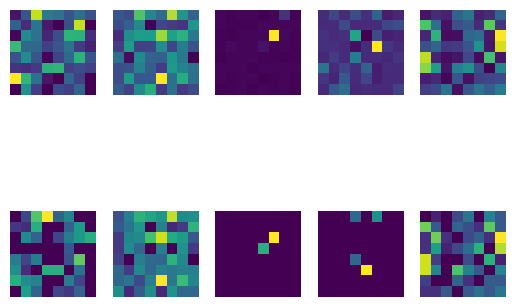

3300 tensor(0.1895, device='cuda:0', grad_fn=<MseLossBackward0>)


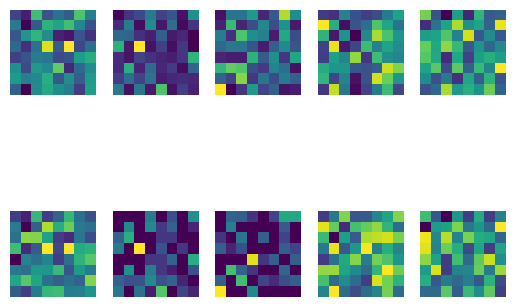

3310 tensor(0.1962, device='cuda:0', grad_fn=<MseLossBackward0>)


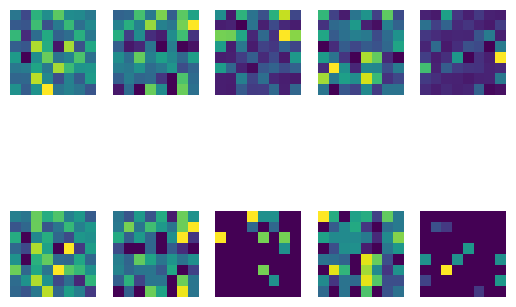

3320 tensor(0.1895, device='cuda:0', grad_fn=<MseLossBackward0>)


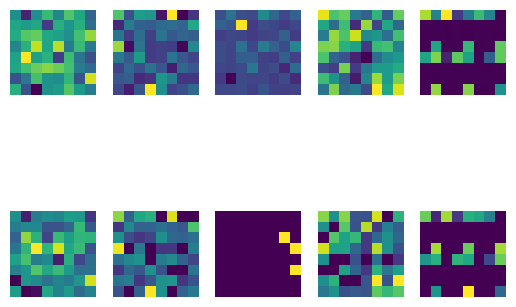

3330 tensor(0.1874, device='cuda:0', grad_fn=<MseLossBackward0>)


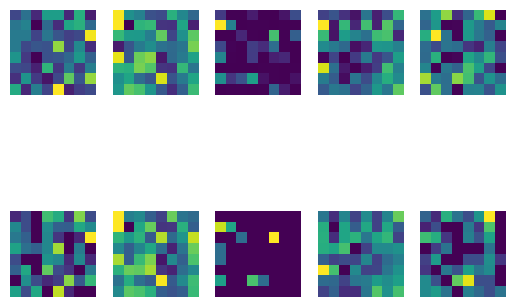

3340 tensor(0.2052, device='cuda:0', grad_fn=<MseLossBackward0>)


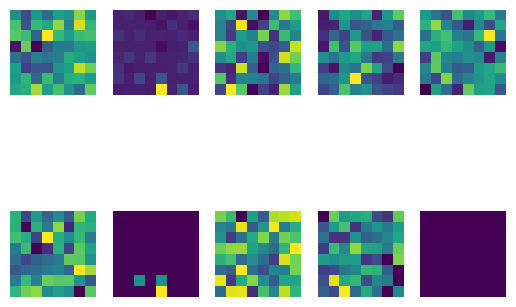

3350 tensor(0.1784, device='cuda:0', grad_fn=<MseLossBackward0>)


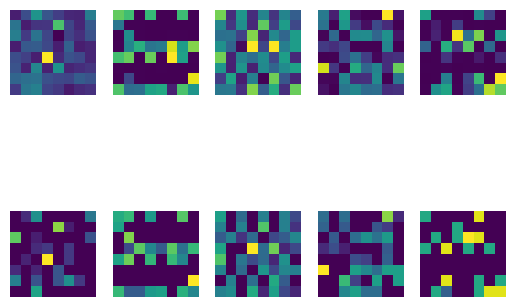

3360 tensor(0.1832, device='cuda:0', grad_fn=<MseLossBackward0>)


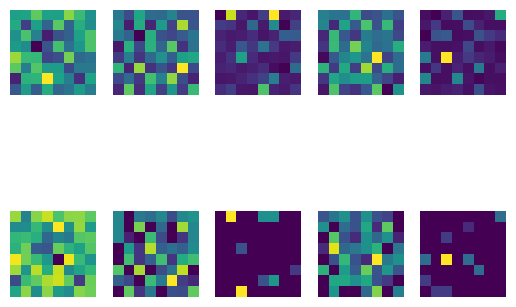

3370 tensor(0.2034, device='cuda:0', grad_fn=<MseLossBackward0>)


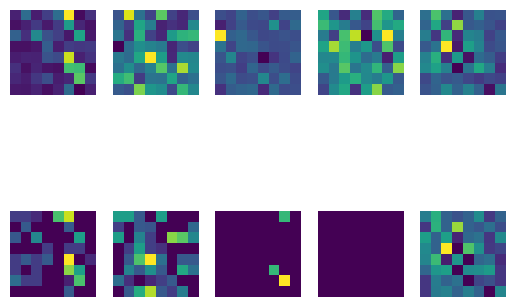

3380 tensor(0.2042, device='cuda:0', grad_fn=<MseLossBackward0>)


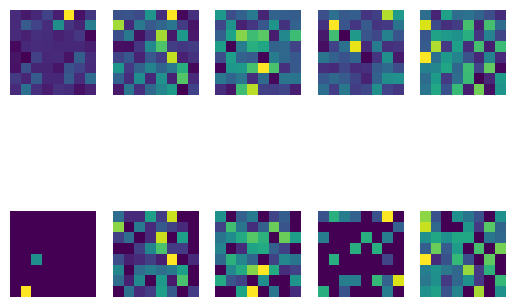

3390 tensor(0.1821, device='cuda:0', grad_fn=<MseLossBackward0>)


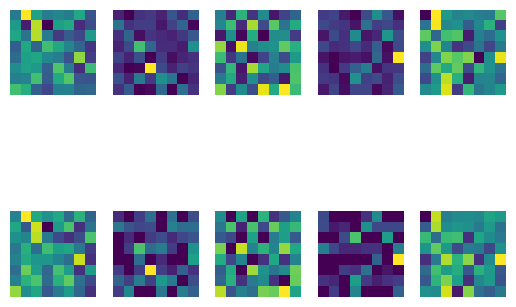

3400 tensor(0.1731, device='cuda:0', grad_fn=<MseLossBackward0>)


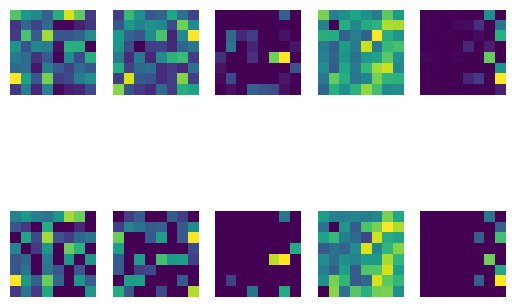

3410 tensor(0.2005, device='cuda:0', grad_fn=<MseLossBackward0>)


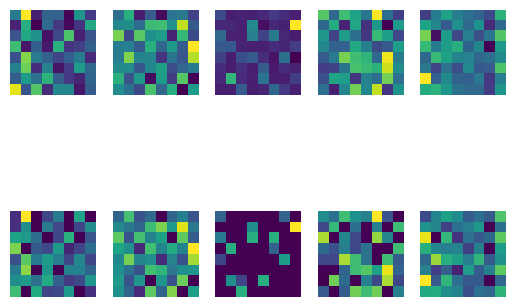

3420 tensor(0.1920, device='cuda:0', grad_fn=<MseLossBackward0>)


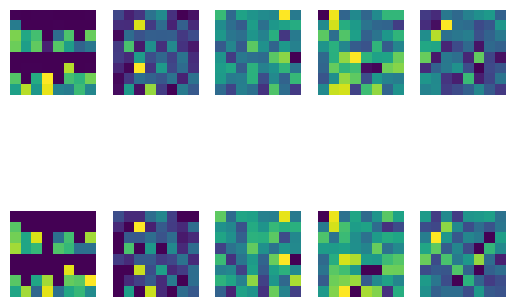

3430 tensor(0.1807, device='cuda:0', grad_fn=<MseLossBackward0>)


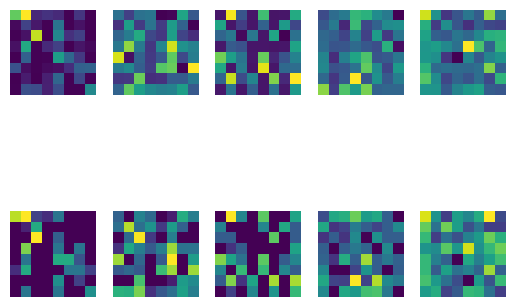

3440 tensor(0.1868, device='cuda:0', grad_fn=<MseLossBackward0>)


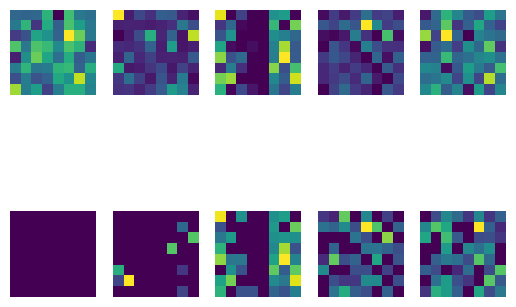

3450 tensor(0.2110, device='cuda:0', grad_fn=<MseLossBackward0>)


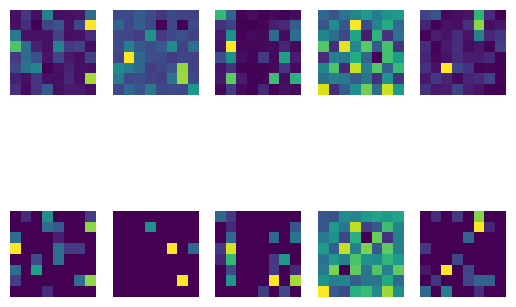

3460 tensor(0.1637, device='cuda:0', grad_fn=<MseLossBackward0>)


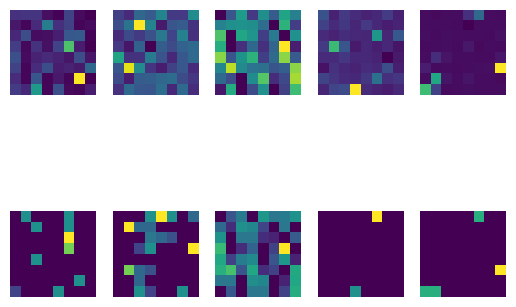

3470 tensor(0.2209, device='cuda:0', grad_fn=<MseLossBackward0>)


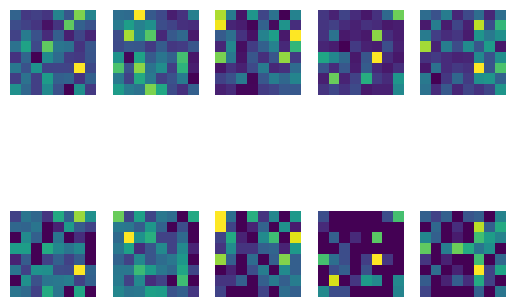

3480 tensor(0.1708, device='cuda:0', grad_fn=<MseLossBackward0>)


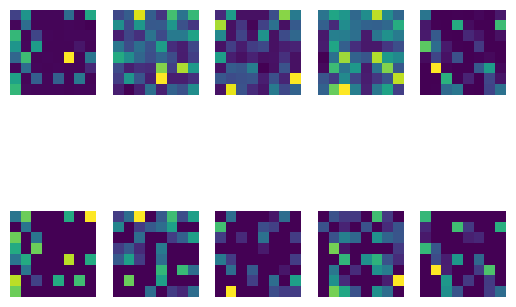

3490 tensor(0.1912, device='cuda:0', grad_fn=<MseLossBackward0>)


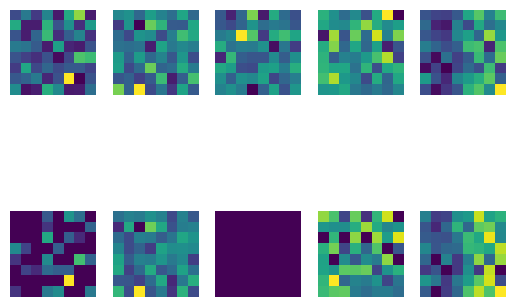

3500 tensor(0.1806, device='cuda:0', grad_fn=<MseLossBackward0>)


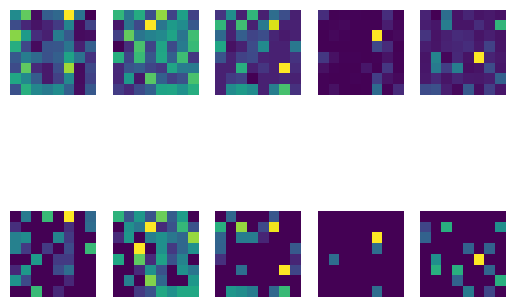

3510 tensor(0.1912, device='cuda:0', grad_fn=<MseLossBackward0>)


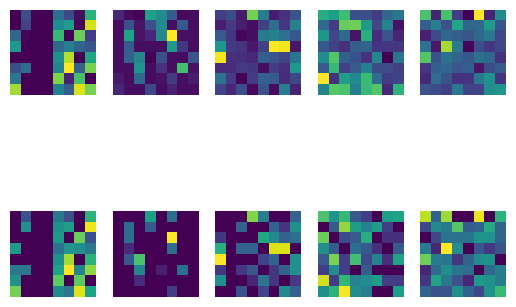

3520 tensor(0.2010, device='cuda:0', grad_fn=<MseLossBackward0>)


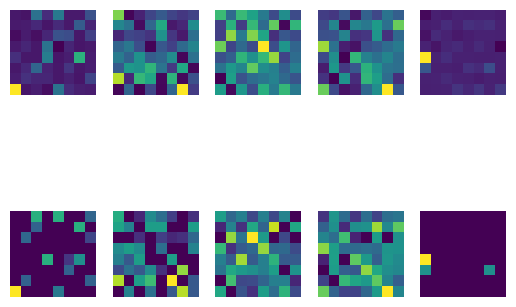

3530 tensor(0.1760, device='cuda:0', grad_fn=<MseLossBackward0>)


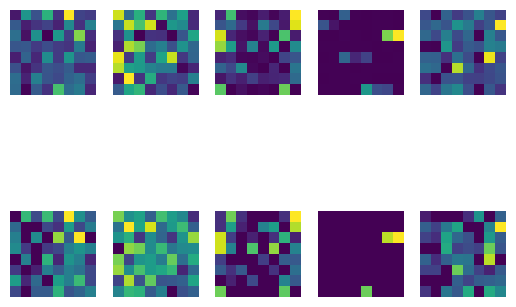

3540 tensor(0.1912, device='cuda:0', grad_fn=<MseLossBackward0>)


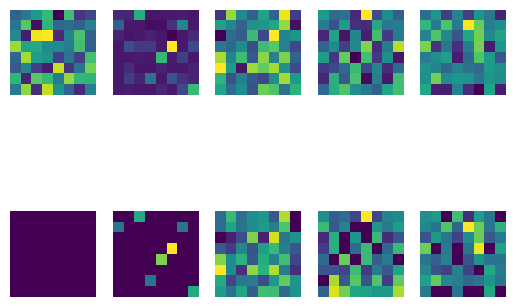

3550 tensor(0.1991, device='cuda:0', grad_fn=<MseLossBackward0>)


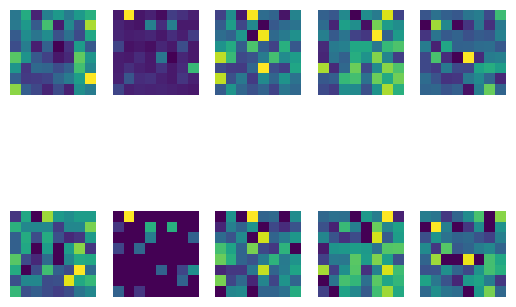

3560 tensor(0.1665, device='cuda:0', grad_fn=<MseLossBackward0>)


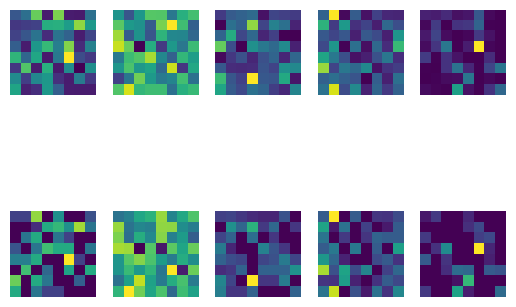

3570 tensor(0.2268, device='cuda:0', grad_fn=<MseLossBackward0>)


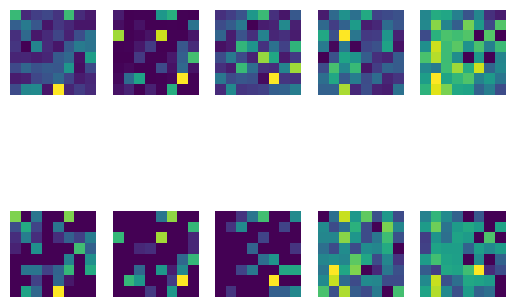

3580 tensor(0.1967, device='cuda:0', grad_fn=<MseLossBackward0>)


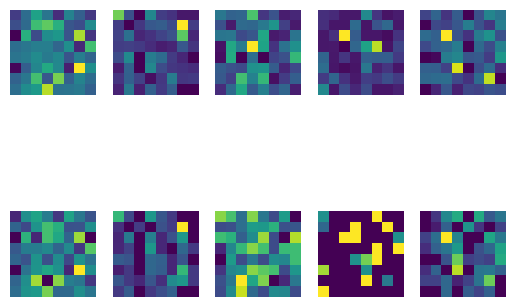

3590 tensor(0.1762, device='cuda:0', grad_fn=<MseLossBackward0>)


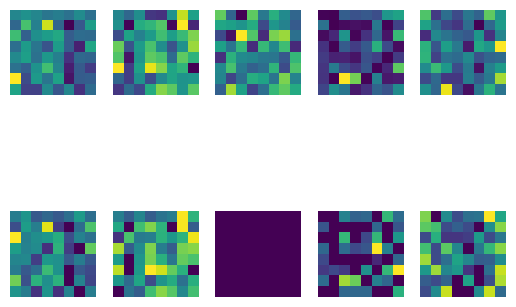

3600 tensor(0.2026, device='cuda:0', grad_fn=<MseLossBackward0>)


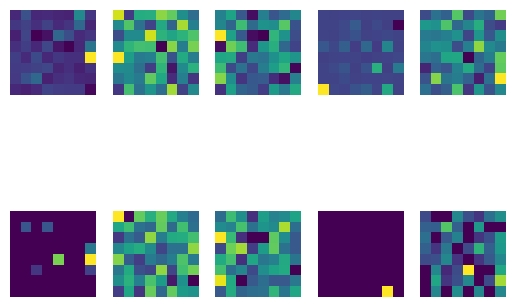

3610 tensor(0.1576, device='cuda:0', grad_fn=<MseLossBackward0>)


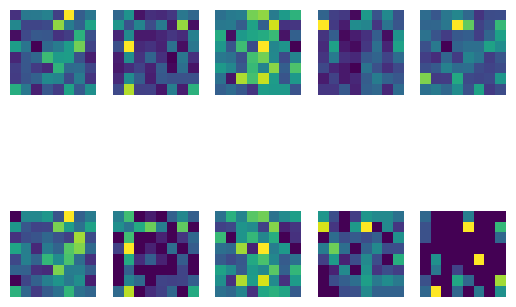

3620 tensor(0.1959, device='cuda:0', grad_fn=<MseLossBackward0>)


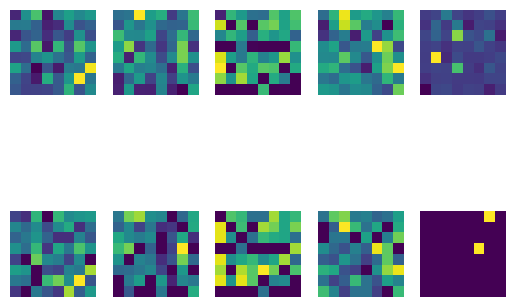

3630 tensor(0.1788, device='cuda:0', grad_fn=<MseLossBackward0>)


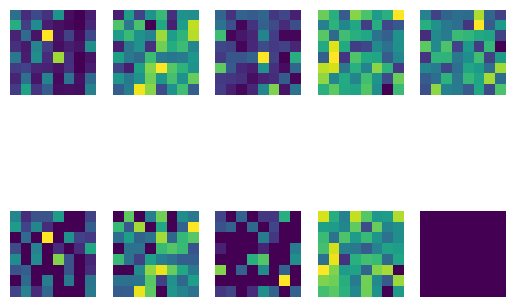

3640 tensor(0.1778, device='cuda:0', grad_fn=<MseLossBackward0>)


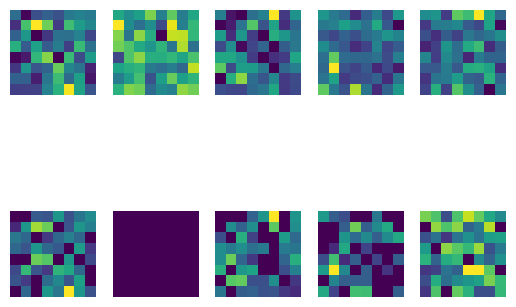

3650 tensor(0.1948, device='cuda:0', grad_fn=<MseLossBackward0>)


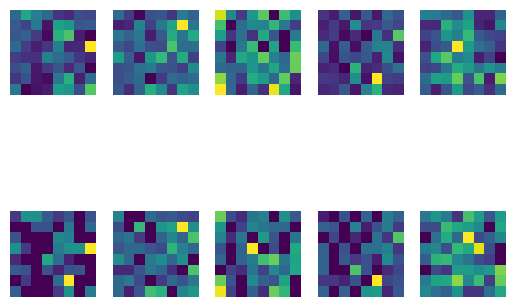

3660 tensor(0.2014, device='cuda:0', grad_fn=<MseLossBackward0>)


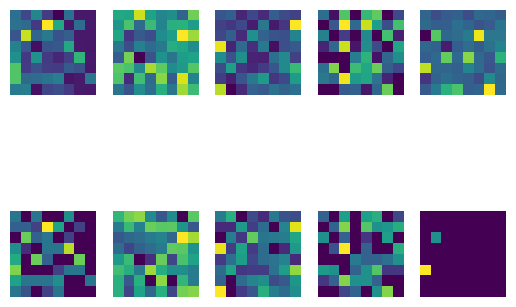

3670 tensor(0.1782, device='cuda:0', grad_fn=<MseLossBackward0>)


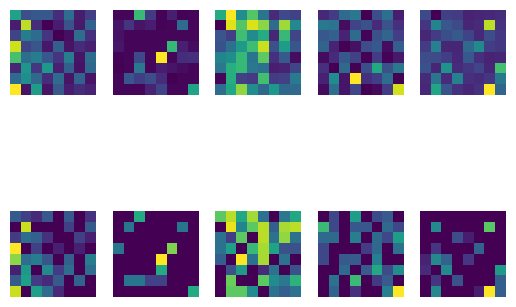

3680 tensor(0.1907, device='cuda:0', grad_fn=<MseLossBackward0>)


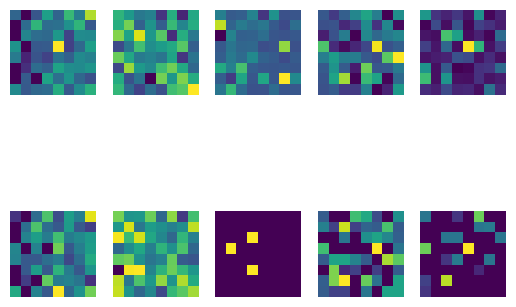

3690 tensor(0.1823, device='cuda:0', grad_fn=<MseLossBackward0>)


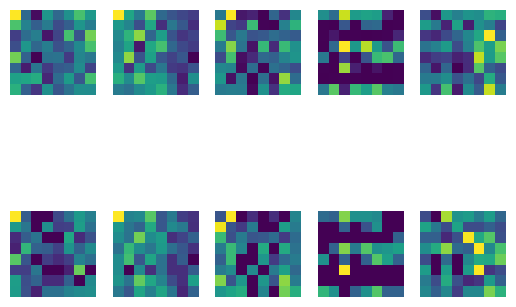

3700 tensor(0.1598, device='cuda:0', grad_fn=<MseLossBackward0>)


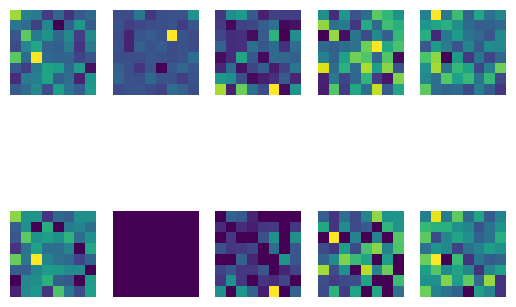

3710 tensor(0.1754, device='cuda:0', grad_fn=<MseLossBackward0>)


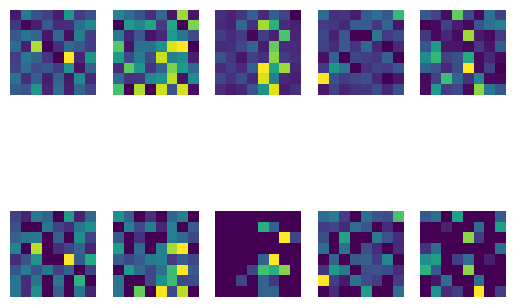

3720 tensor(0.1660, device='cuda:0', grad_fn=<MseLossBackward0>)


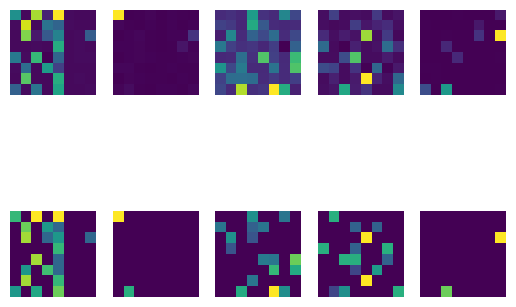

3730 tensor(0.1831, device='cuda:0', grad_fn=<MseLossBackward0>)


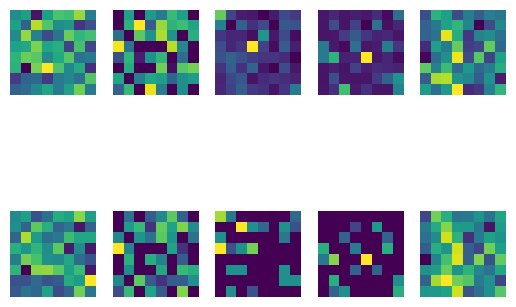

3740 tensor(0.1635, device='cuda:0', grad_fn=<MseLossBackward0>)


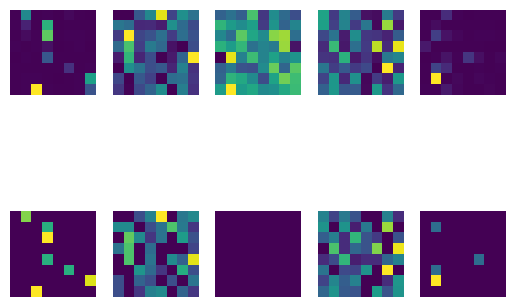

3750 tensor(0.1792, device='cuda:0', grad_fn=<MseLossBackward0>)


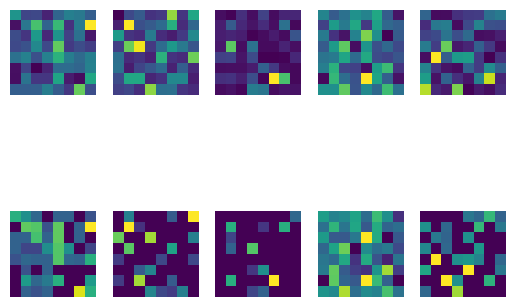

3760 tensor(0.1839, device='cuda:0', grad_fn=<MseLossBackward0>)


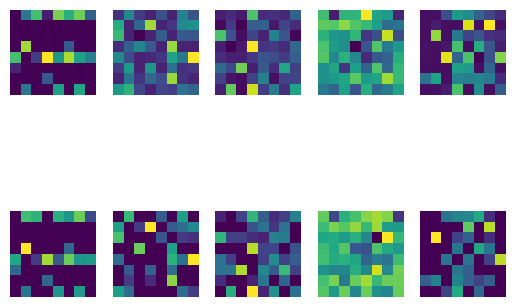

3770 tensor(0.1783, device='cuda:0', grad_fn=<MseLossBackward0>)


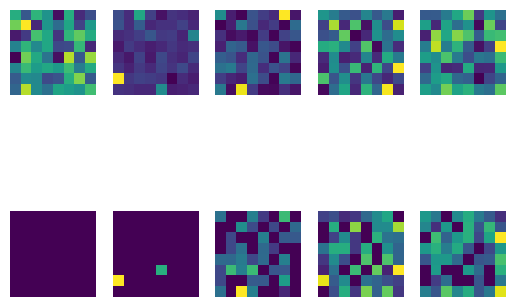

3780 tensor(0.1912, device='cuda:0', grad_fn=<MseLossBackward0>)


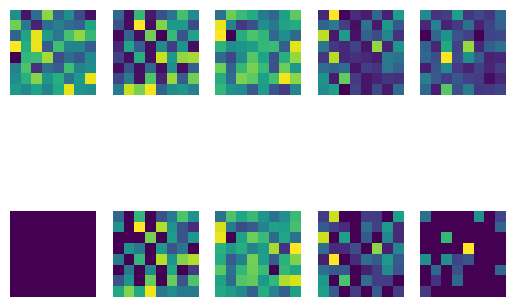

3790 tensor(0.1864, device='cuda:0', grad_fn=<MseLossBackward0>)


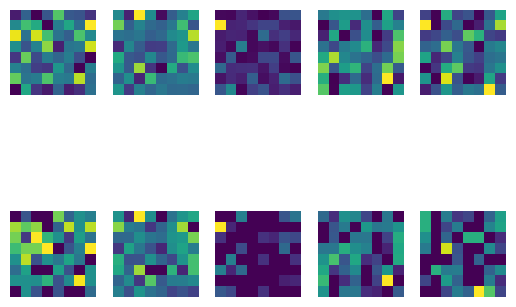

3800 tensor(0.1697, device='cuda:0', grad_fn=<MseLossBackward0>)


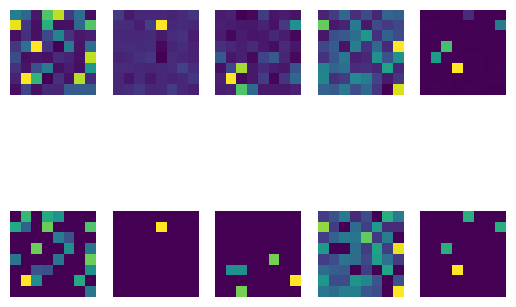

3810 tensor(0.1817, device='cuda:0', grad_fn=<MseLossBackward0>)


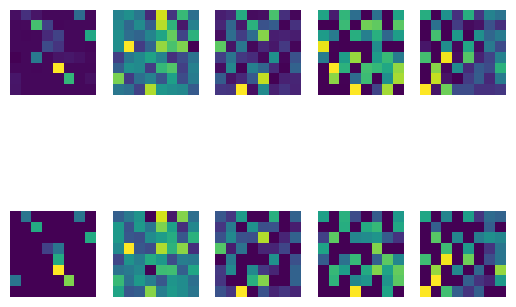

3820 tensor(0.1838, device='cuda:0', grad_fn=<MseLossBackward0>)


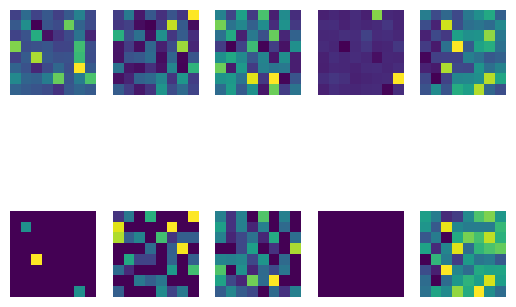

3830 tensor(0.1862, device='cuda:0', grad_fn=<MseLossBackward0>)


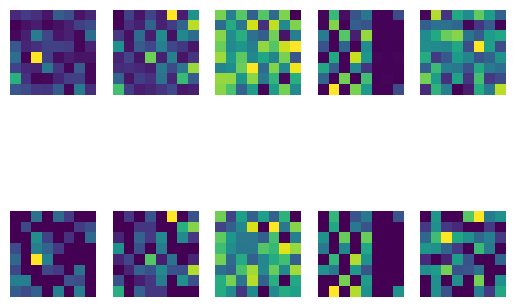

3840 tensor(0.1748, device='cuda:0', grad_fn=<MseLossBackward0>)


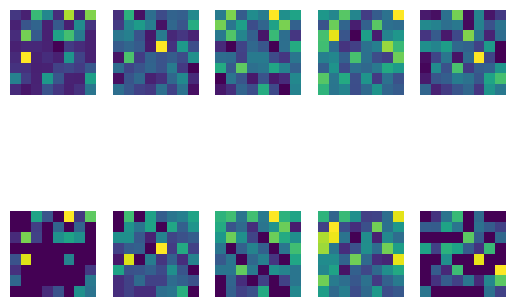

3850 tensor(0.1790, device='cuda:0', grad_fn=<MseLossBackward0>)


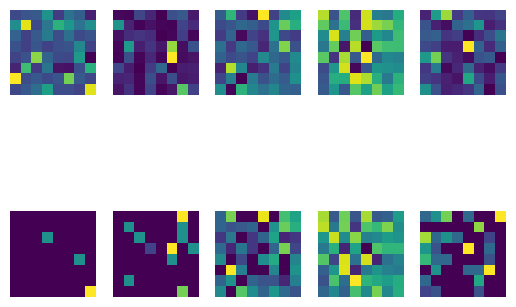

3860 tensor(0.1878, device='cuda:0', grad_fn=<MseLossBackward0>)


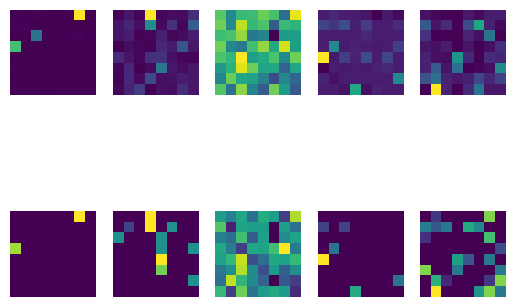

3870 tensor(0.1685, device='cuda:0', grad_fn=<MseLossBackward0>)


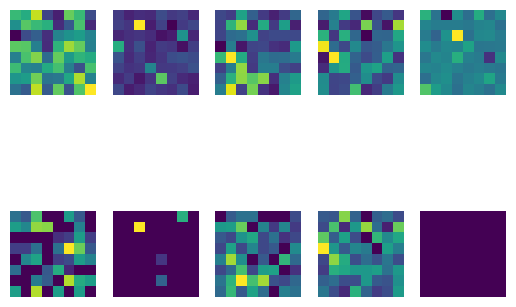

3880 tensor(0.1778, device='cuda:0', grad_fn=<MseLossBackward0>)


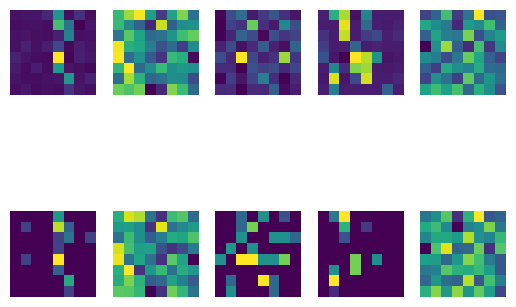

3890 tensor(0.1801, device='cuda:0', grad_fn=<MseLossBackward0>)


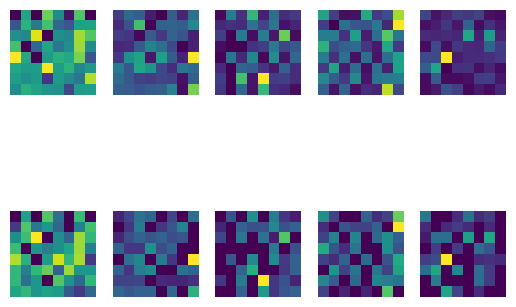

3900 tensor(0.1848, device='cuda:0', grad_fn=<MseLossBackward0>)


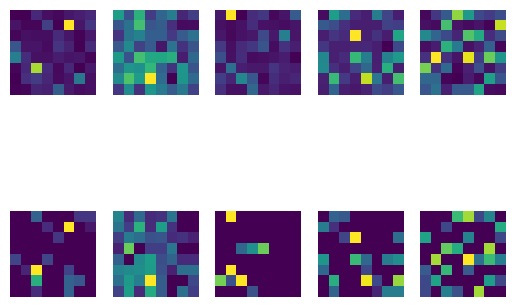

3910 tensor(0.1667, device='cuda:0', grad_fn=<MseLossBackward0>)


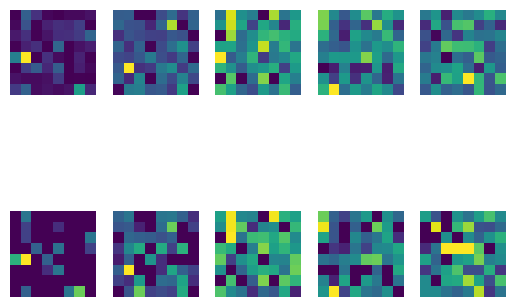

3920 tensor(0.1971, device='cuda:0', grad_fn=<MseLossBackward0>)


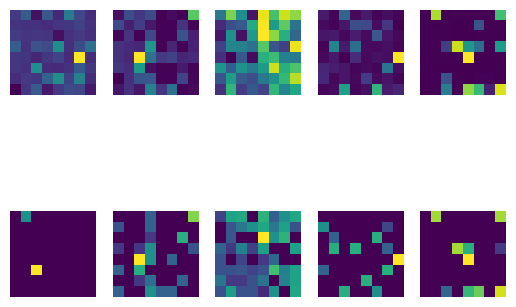

3930 tensor(0.1934, device='cuda:0', grad_fn=<MseLossBackward0>)


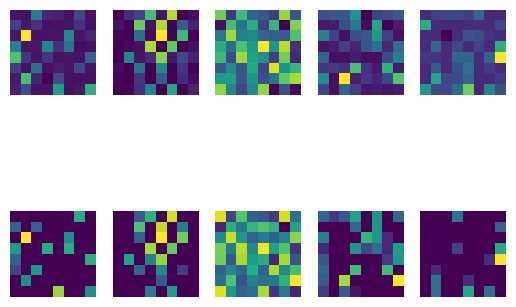

3940 tensor(0.1962, device='cuda:0', grad_fn=<MseLossBackward0>)


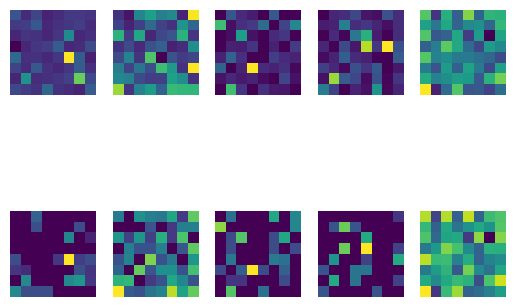

3950 tensor(0.1989, device='cuda:0', grad_fn=<MseLossBackward0>)


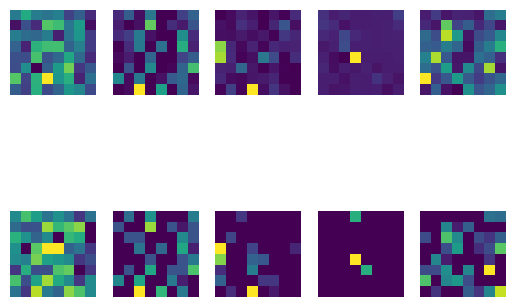

3960 tensor(0.1842, device='cuda:0', grad_fn=<MseLossBackward0>)


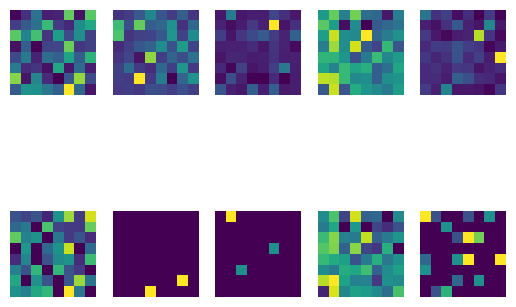

3970 tensor(0.1665, device='cuda:0', grad_fn=<MseLossBackward0>)


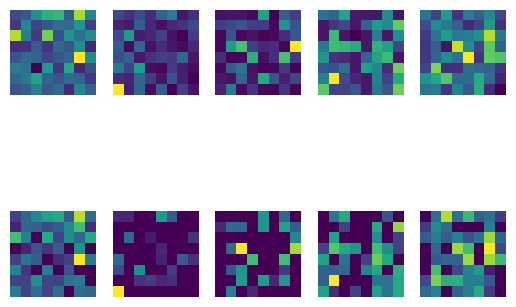

3980 tensor(0.1819, device='cuda:0', grad_fn=<MseLossBackward0>)


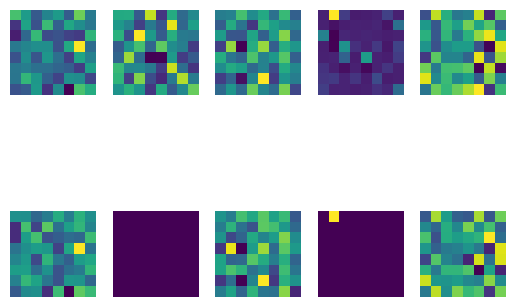

3990 tensor(0.1770, device='cuda:0', grad_fn=<MseLossBackward0>)


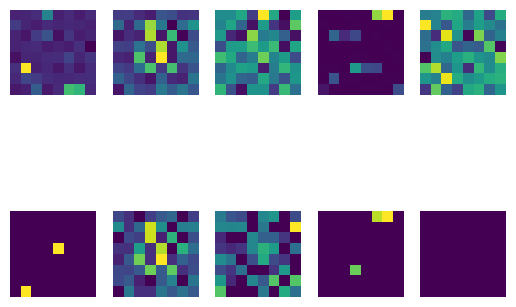

4000 tensor(0.2053, device='cuda:0', grad_fn=<MseLossBackward0>)


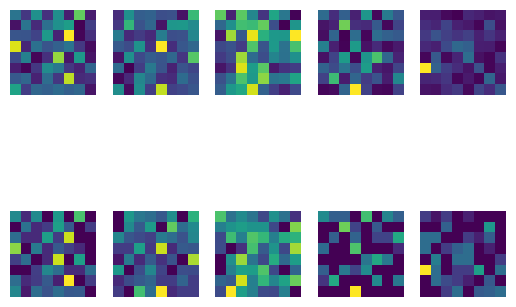

4010 tensor(0.1790, device='cuda:0', grad_fn=<MseLossBackward0>)


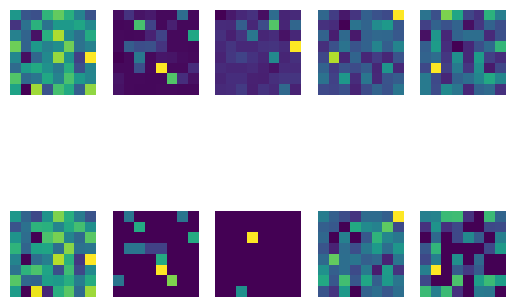

4020 tensor(0.1700, device='cuda:0', grad_fn=<MseLossBackward0>)


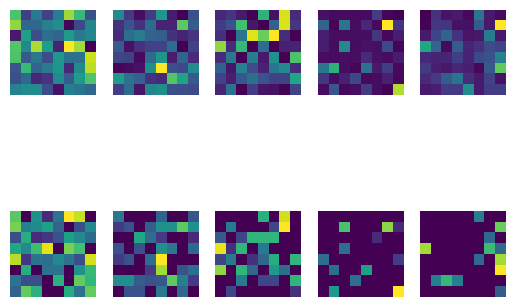

4030 tensor(0.1730, device='cuda:0', grad_fn=<MseLossBackward0>)


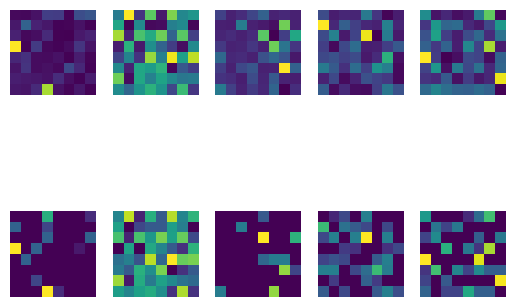

4040 tensor(0.1621, device='cuda:0', grad_fn=<MseLossBackward0>)


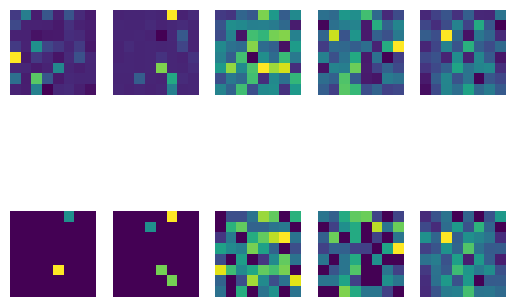

4050 tensor(0.1722, device='cuda:0', grad_fn=<MseLossBackward0>)


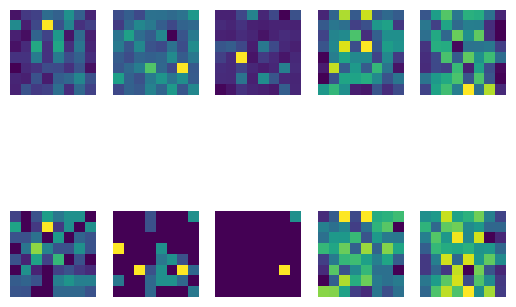

4060 tensor(0.1737, device='cuda:0', grad_fn=<MseLossBackward0>)


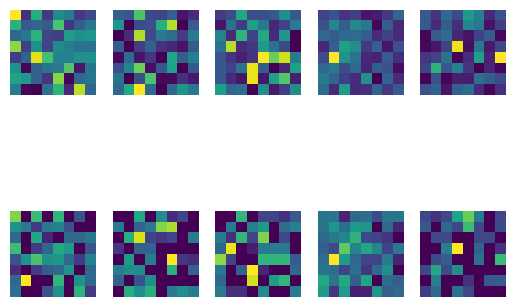

4070 tensor(0.1857, device='cuda:0', grad_fn=<MseLossBackward0>)


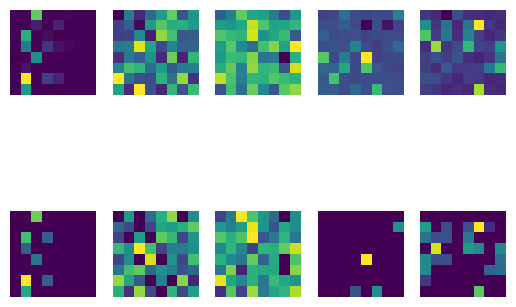

4080 tensor(0.1886, device='cuda:0', grad_fn=<MseLossBackward0>)


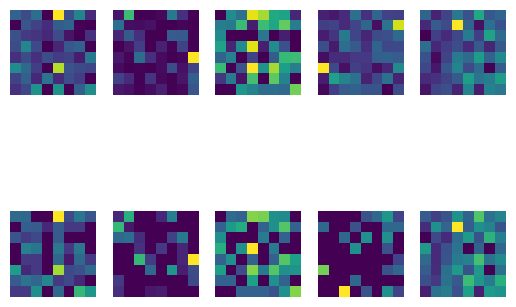

4090 tensor(0.1846, device='cuda:0', grad_fn=<MseLossBackward0>)


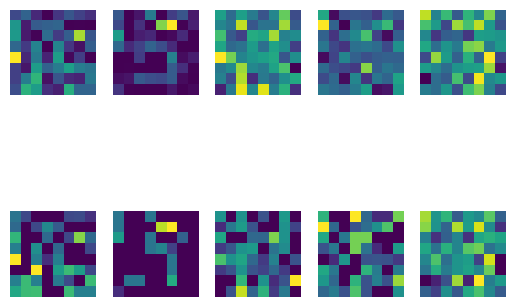

4100 tensor(0.1666, device='cuda:0', grad_fn=<MseLossBackward0>)


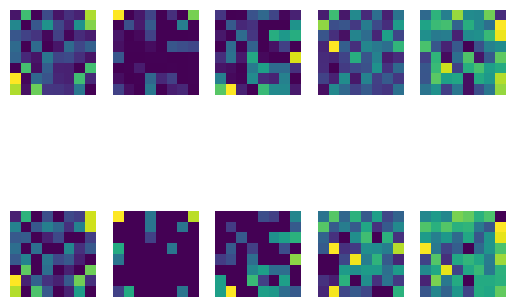

4110 tensor(0.1786, device='cuda:0', grad_fn=<MseLossBackward0>)


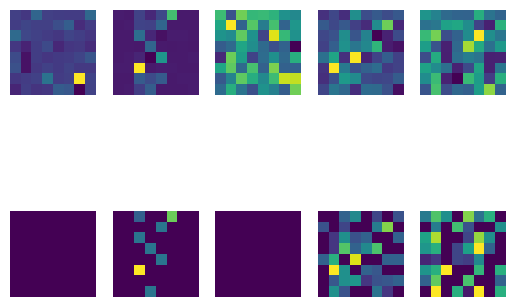

4120 tensor(0.1698, device='cuda:0', grad_fn=<MseLossBackward0>)


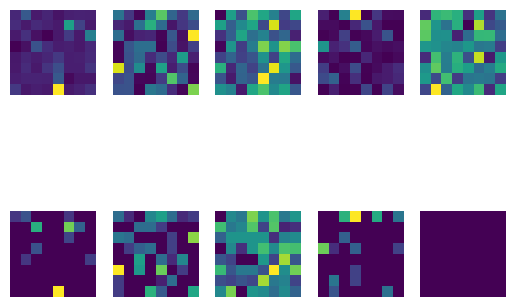

4130 tensor(0.1829, device='cuda:0', grad_fn=<MseLossBackward0>)


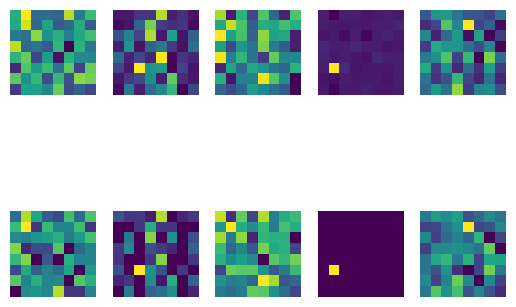

4140 tensor(0.1962, device='cuda:0', grad_fn=<MseLossBackward0>)


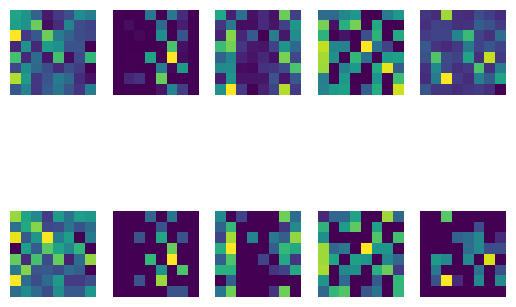

4150 tensor(0.1903, device='cuda:0', grad_fn=<MseLossBackward0>)


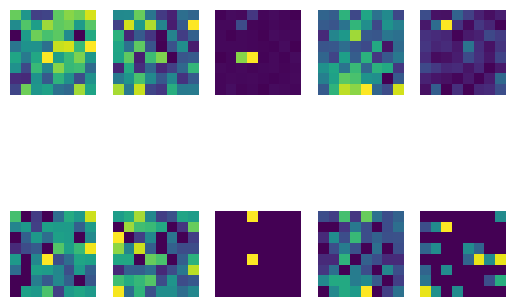

4160 tensor(0.1823, device='cuda:0', grad_fn=<MseLossBackward0>)


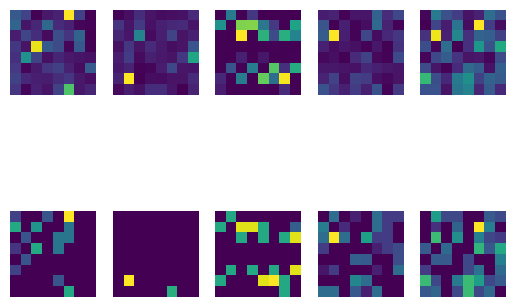

4170 tensor(0.1950, device='cuda:0', grad_fn=<MseLossBackward0>)


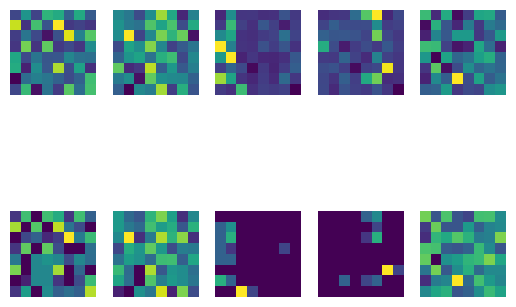

4180 tensor(0.1690, device='cuda:0', grad_fn=<MseLossBackward0>)


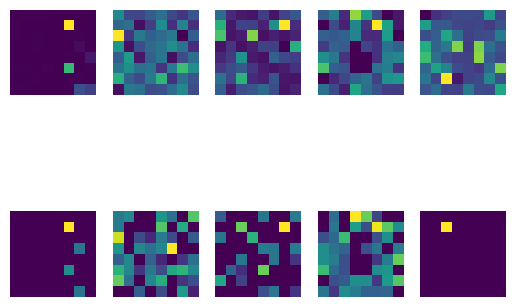

4190 tensor(0.1465, device='cuda:0', grad_fn=<MseLossBackward0>)


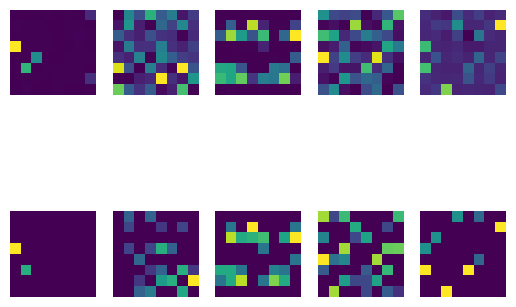

4200 tensor(0.1878, device='cuda:0', grad_fn=<MseLossBackward0>)


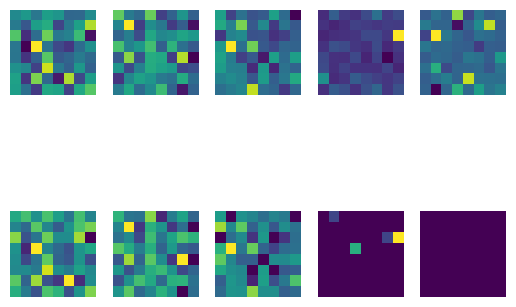

4210 tensor(0.1515, device='cuda:0', grad_fn=<MseLossBackward0>)


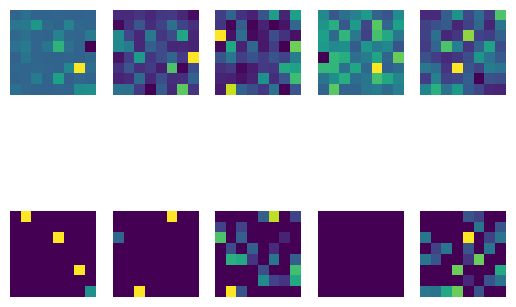

4220 tensor(0.1523, device='cuda:0', grad_fn=<MseLossBackward0>)


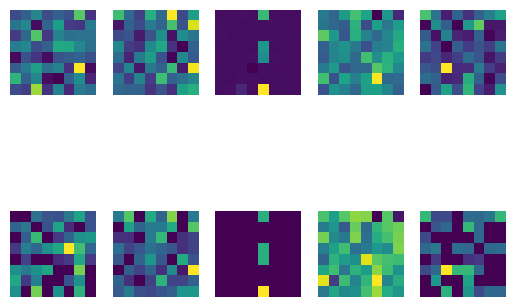

4230 tensor(0.1736, device='cuda:0', grad_fn=<MseLossBackward0>)


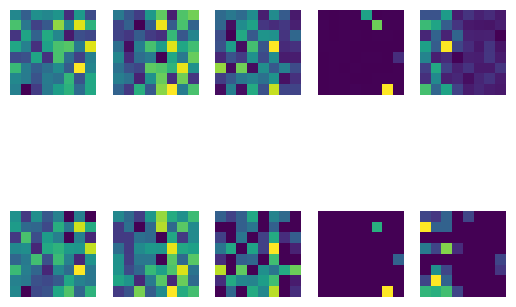

4240 tensor(0.1419, device='cuda:0', grad_fn=<MseLossBackward0>)


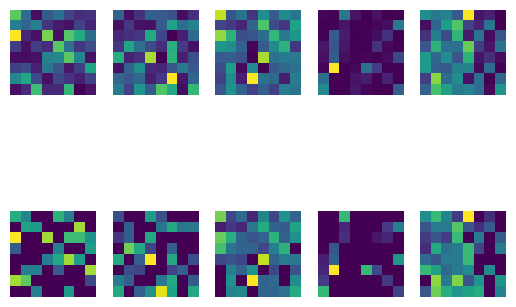

4250 tensor(0.2037, device='cuda:0', grad_fn=<MseLossBackward0>)


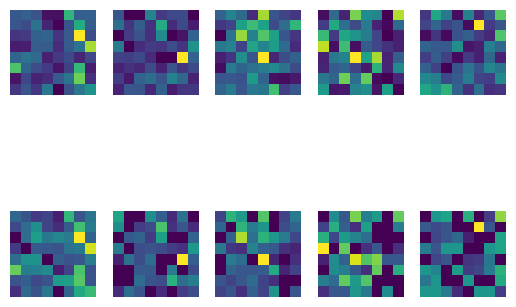

4260 tensor(0.1639, device='cuda:0', grad_fn=<MseLossBackward0>)


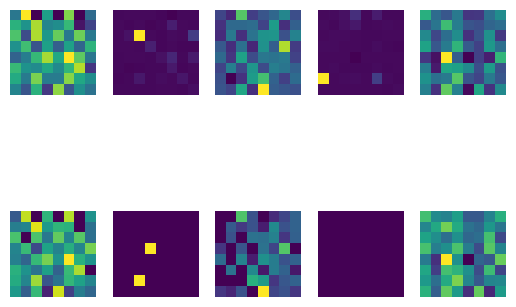

4270 tensor(0.1725, device='cuda:0', grad_fn=<MseLossBackward0>)


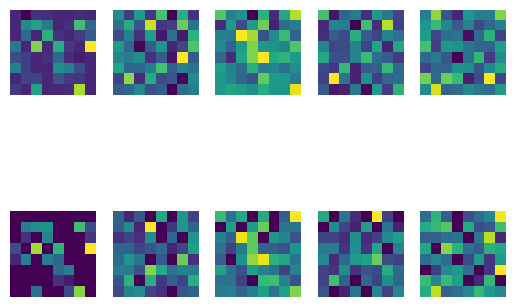

4280 tensor(0.1750, device='cuda:0', grad_fn=<MseLossBackward0>)


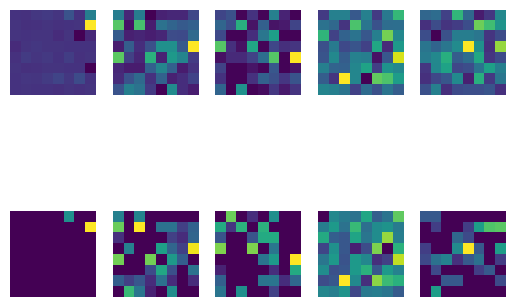

4290 tensor(0.1711, device='cuda:0', grad_fn=<MseLossBackward0>)


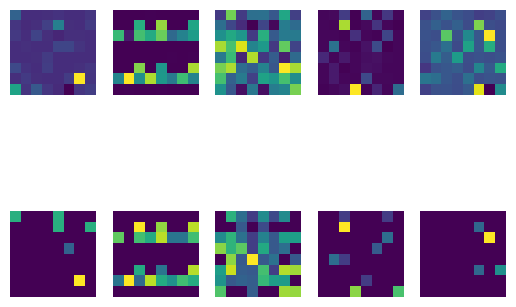

4300 tensor(0.1531, device='cuda:0', grad_fn=<MseLossBackward0>)


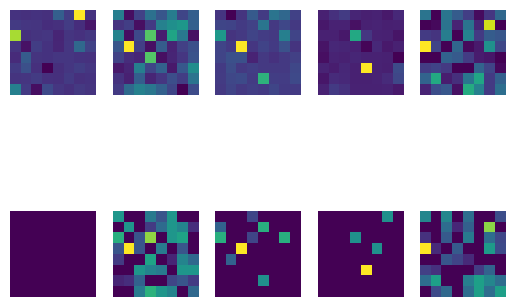

4310 tensor(0.1954, device='cuda:0', grad_fn=<MseLossBackward0>)


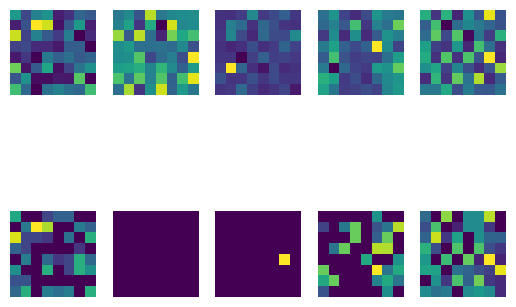

4320 tensor(0.1843, device='cuda:0', grad_fn=<MseLossBackward0>)


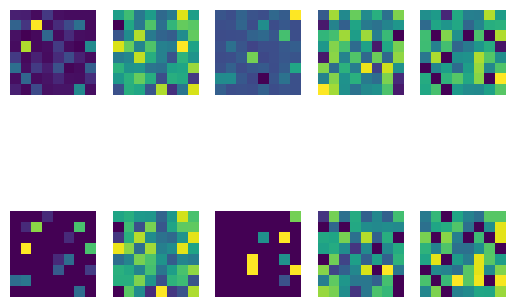

4330 tensor(0.1928, device='cuda:0', grad_fn=<MseLossBackward0>)


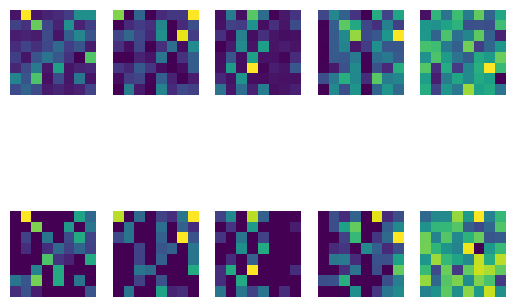

4340 tensor(0.1771, device='cuda:0', grad_fn=<MseLossBackward0>)


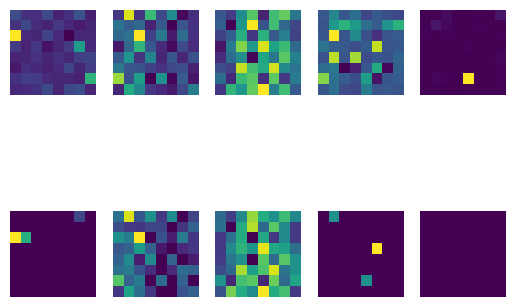

4350 tensor(0.1765, device='cuda:0', grad_fn=<MseLossBackward0>)


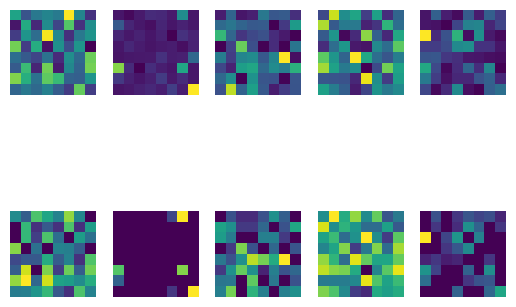

4360 tensor(0.1662, device='cuda:0', grad_fn=<MseLossBackward0>)


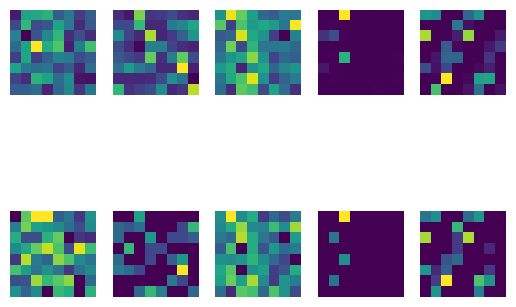

4370 tensor(0.1605, device='cuda:0', grad_fn=<MseLossBackward0>)


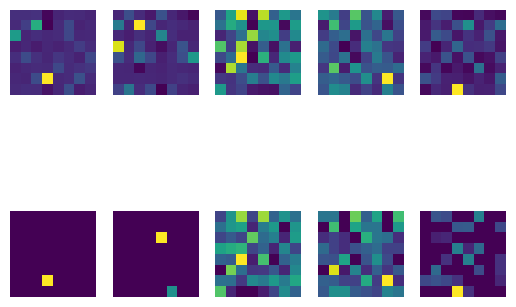

4380 tensor(0.1787, device='cuda:0', grad_fn=<MseLossBackward0>)


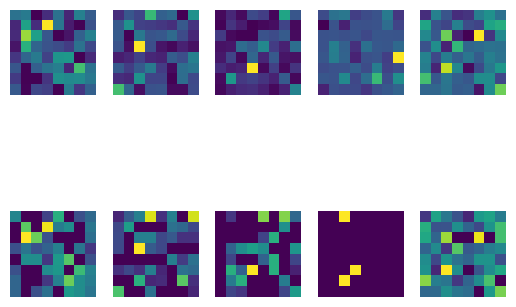

4390 tensor(0.1966, device='cuda:0', grad_fn=<MseLossBackward0>)


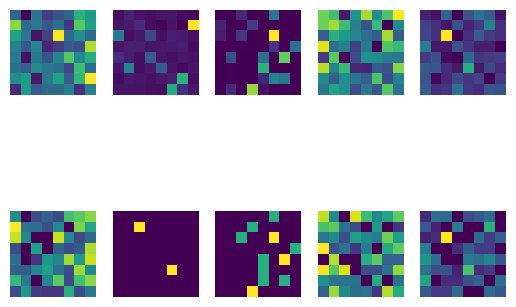

4400 tensor(0.1680, device='cuda:0', grad_fn=<MseLossBackward0>)


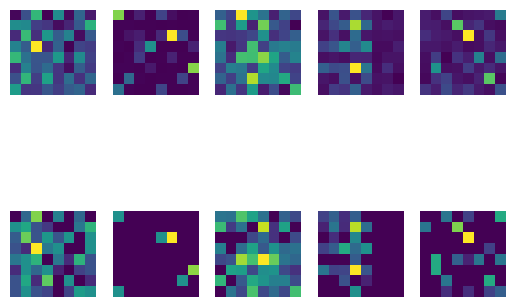

4410 tensor(0.1837, device='cuda:0', grad_fn=<MseLossBackward0>)


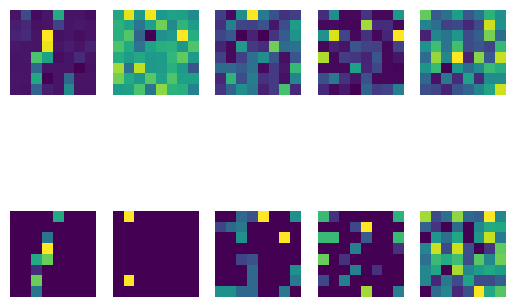

4420 tensor(0.1896, device='cuda:0', grad_fn=<MseLossBackward0>)


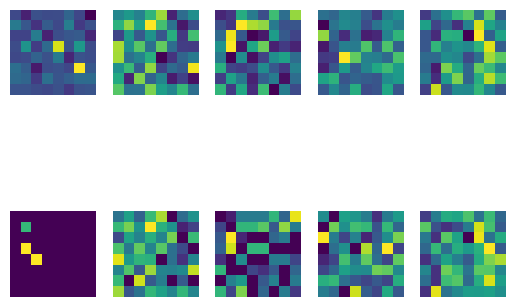

4430 tensor(0.1741, device='cuda:0', grad_fn=<MseLossBackward0>)


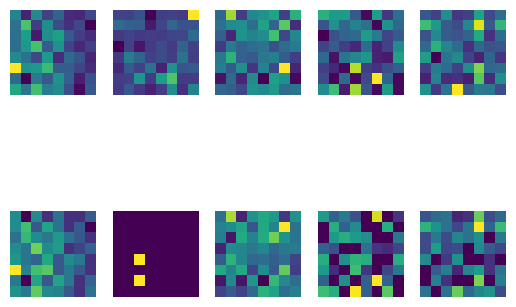

4440 tensor(0.1688, device='cuda:0', grad_fn=<MseLossBackward0>)


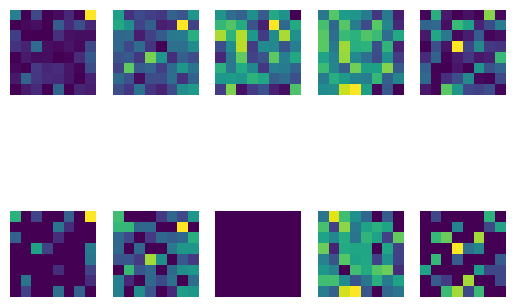

4450 tensor(0.1572, device='cuda:0', grad_fn=<MseLossBackward0>)


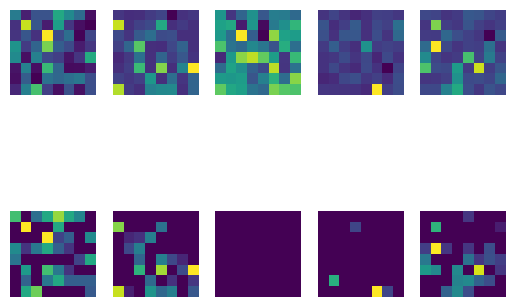

4460 tensor(0.1816, device='cuda:0', grad_fn=<MseLossBackward0>)


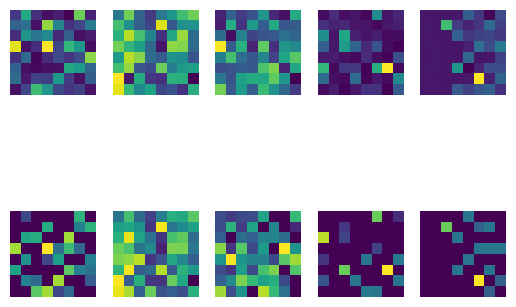

4470 tensor(0.1988, device='cuda:0', grad_fn=<MseLossBackward0>)


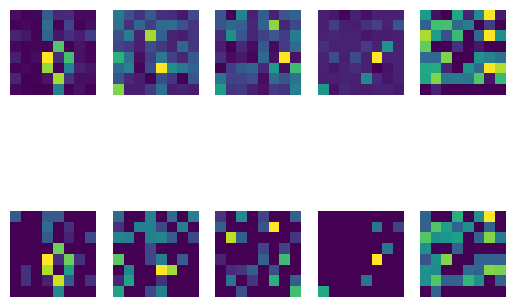

4480 tensor(0.1913, device='cuda:0', grad_fn=<MseLossBackward0>)


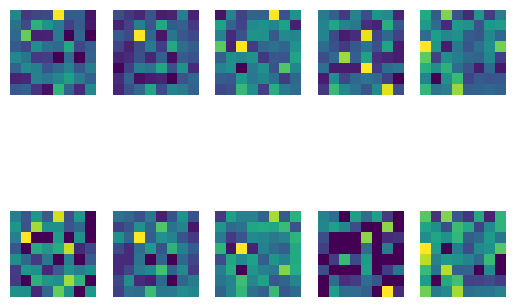

4490 tensor(0.1873, device='cuda:0', grad_fn=<MseLossBackward0>)


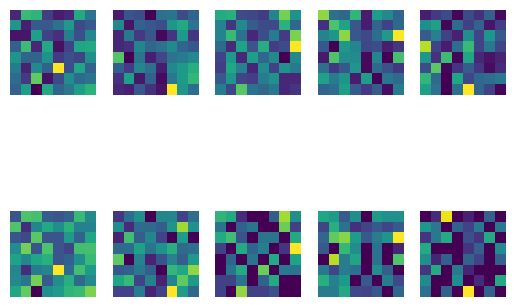

4500 tensor(0.1743, device='cuda:0', grad_fn=<MseLossBackward0>)


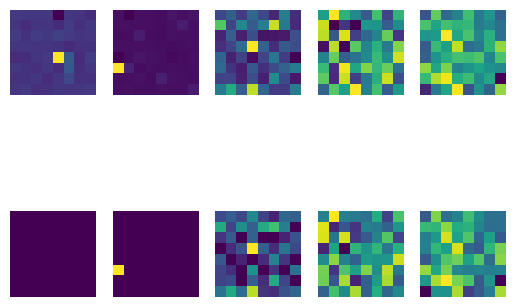

4510 tensor(0.1664, device='cuda:0', grad_fn=<MseLossBackward0>)


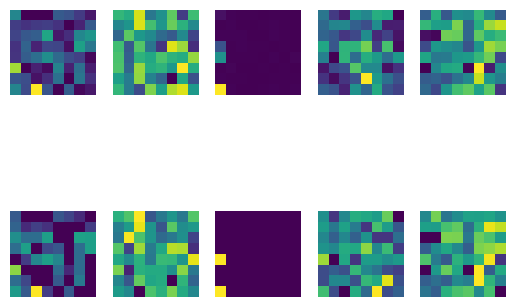

4520 tensor(0.2095, device='cuda:0', grad_fn=<MseLossBackward0>)


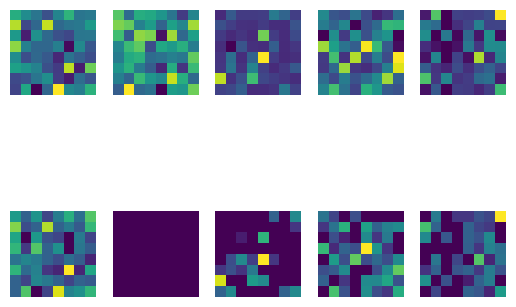

4530 tensor(0.1818, device='cuda:0', grad_fn=<MseLossBackward0>)


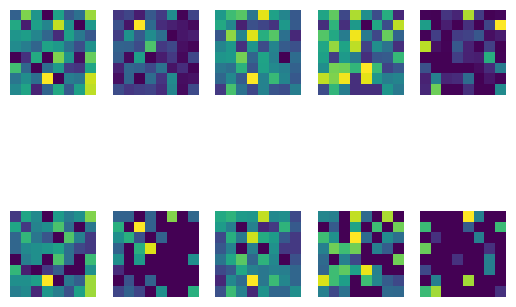

4540 tensor(0.1844, device='cuda:0', grad_fn=<MseLossBackward0>)


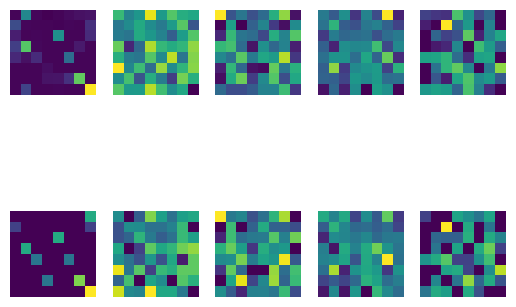

4550 tensor(0.1765, device='cuda:0', grad_fn=<MseLossBackward0>)


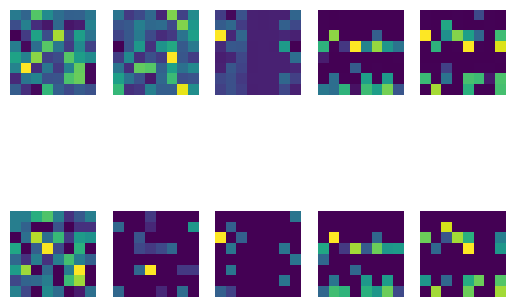

4560 tensor(0.1670, device='cuda:0', grad_fn=<MseLossBackward0>)


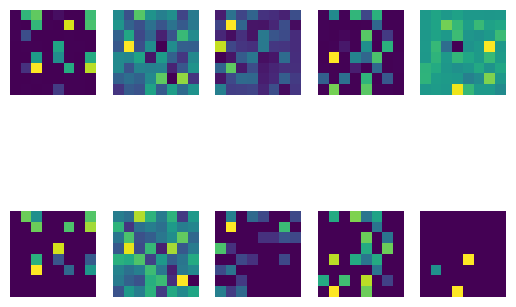

4570 tensor(0.1685, device='cuda:0', grad_fn=<MseLossBackward0>)


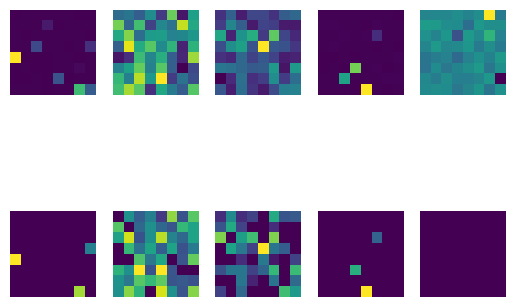

4580 tensor(0.1792, device='cuda:0', grad_fn=<MseLossBackward0>)


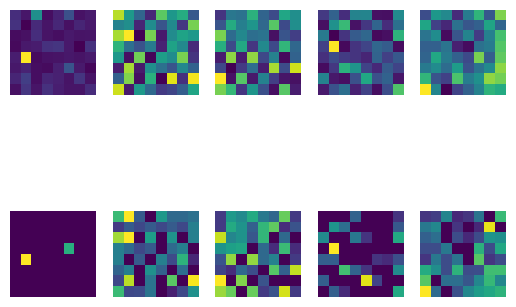

4590 tensor(0.1790, device='cuda:0', grad_fn=<MseLossBackward0>)


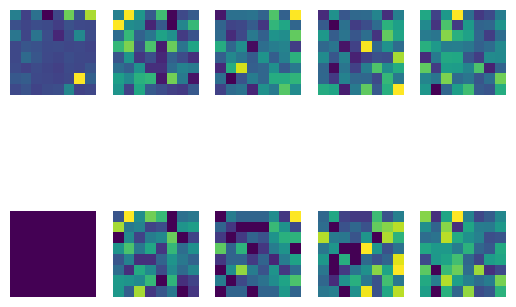

4600 tensor(0.1792, device='cuda:0', grad_fn=<MseLossBackward0>)


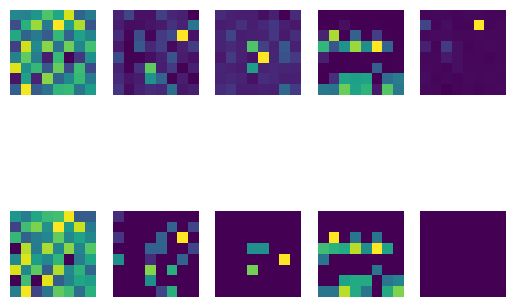

4610 tensor(0.2001, device='cuda:0', grad_fn=<MseLossBackward0>)


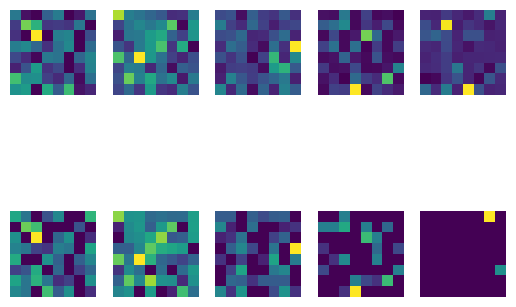

4620 tensor(0.1713, device='cuda:0', grad_fn=<MseLossBackward0>)


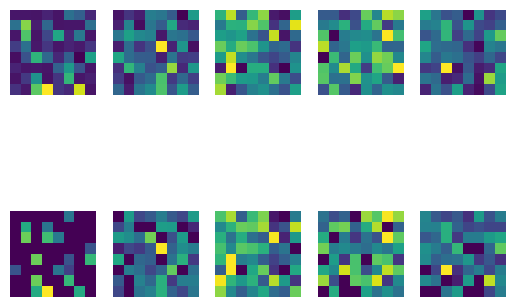

4630 tensor(0.1776, device='cuda:0', grad_fn=<MseLossBackward0>)


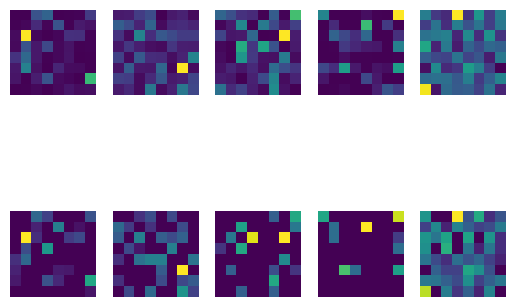

4640 tensor(0.1627, device='cuda:0', grad_fn=<MseLossBackward0>)


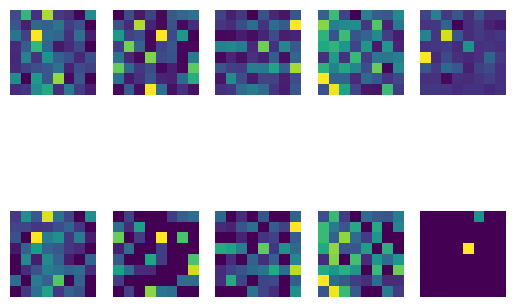

4650 tensor(0.1897, device='cuda:0', grad_fn=<MseLossBackward0>)


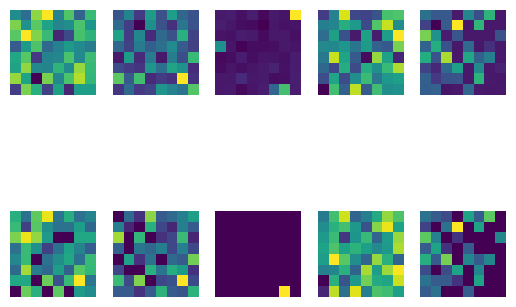

4660 tensor(0.1884, device='cuda:0', grad_fn=<MseLossBackward0>)


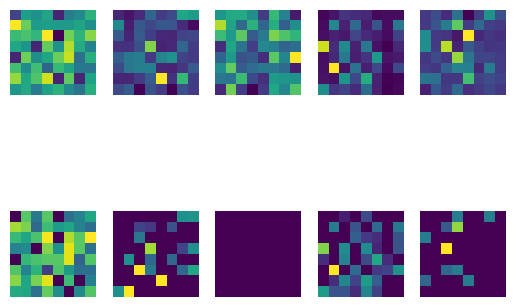

4670 tensor(0.1773, device='cuda:0', grad_fn=<MseLossBackward0>)


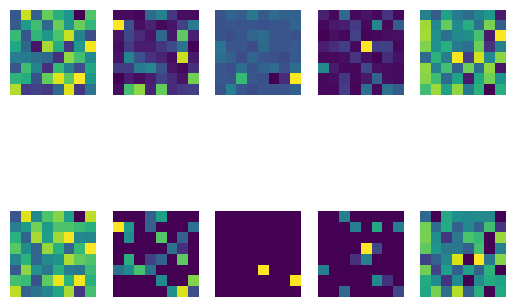

4680 tensor(0.1734, device='cuda:0', grad_fn=<MseLossBackward0>)


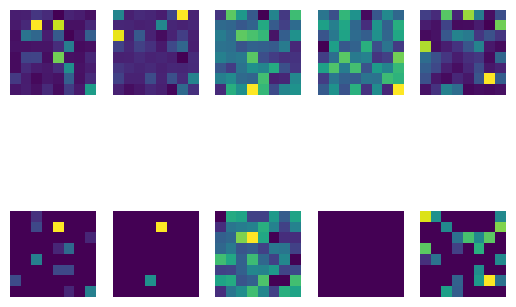

4690 tensor(0.1880, device='cuda:0', grad_fn=<MseLossBackward0>)


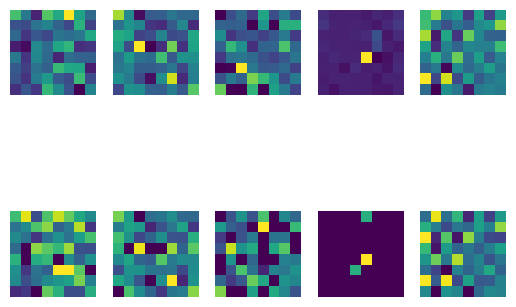

4700 tensor(0.1733, device='cuda:0', grad_fn=<MseLossBackward0>)


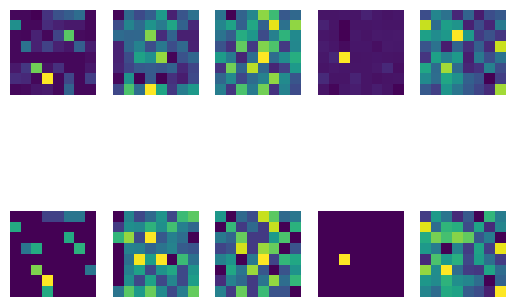

4710 tensor(0.1699, device='cuda:0', grad_fn=<MseLossBackward0>)


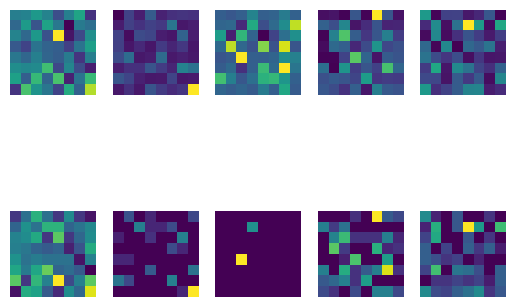

4720 tensor(0.1950, device='cuda:0', grad_fn=<MseLossBackward0>)


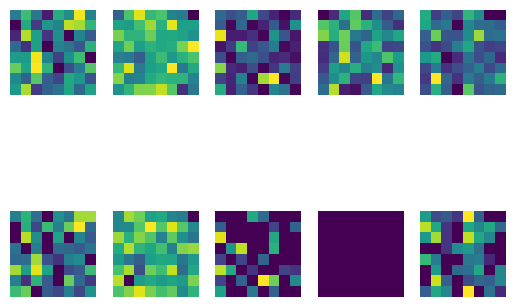

4730 tensor(0.1651, device='cuda:0', grad_fn=<MseLossBackward0>)


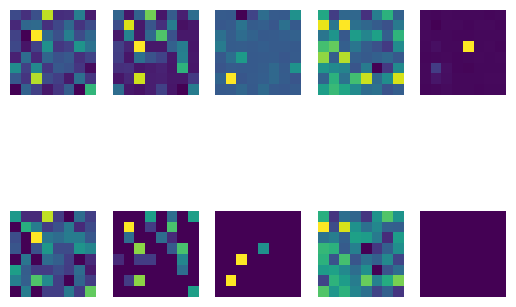

4740 tensor(0.1881, device='cuda:0', grad_fn=<MseLossBackward0>)


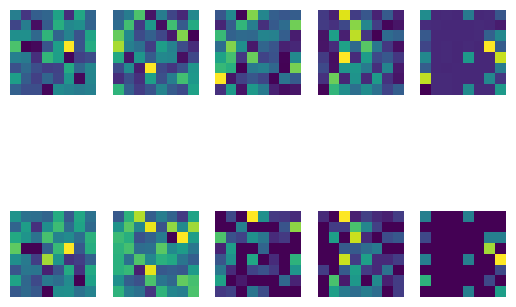

4750 tensor(0.2004, device='cuda:0', grad_fn=<MseLossBackward0>)


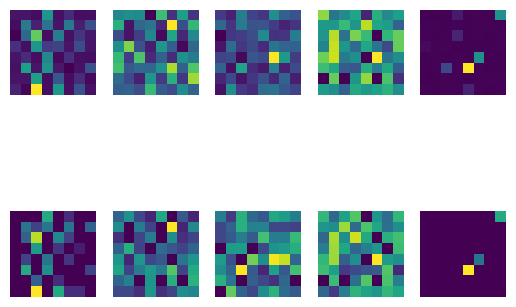

4760 tensor(0.1834, device='cuda:0', grad_fn=<MseLossBackward0>)


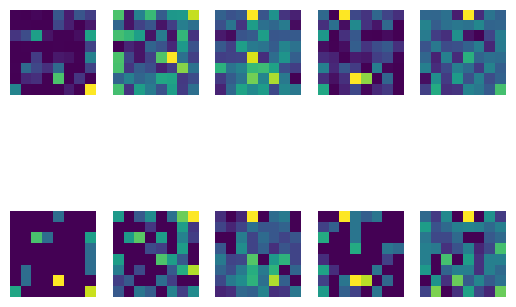

4770 tensor(0.1768, device='cuda:0', grad_fn=<MseLossBackward0>)


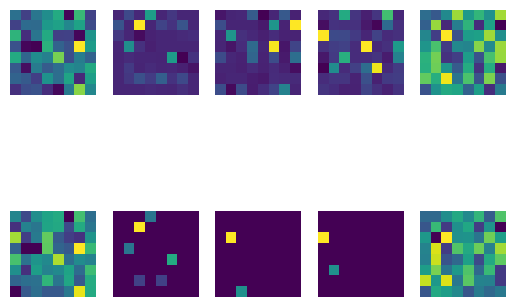

4780 tensor(0.1715, device='cuda:0', grad_fn=<MseLossBackward0>)


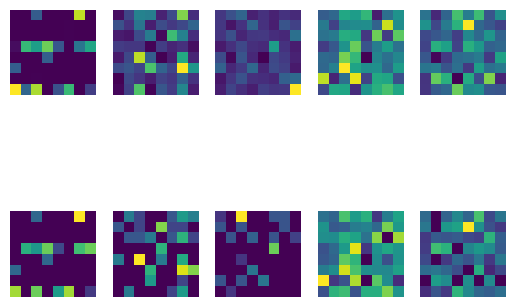

4790 tensor(0.2037, device='cuda:0', grad_fn=<MseLossBackward0>)


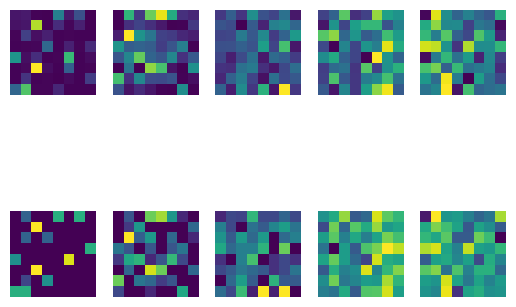

4800 tensor(0.1832, device='cuda:0', grad_fn=<MseLossBackward0>)


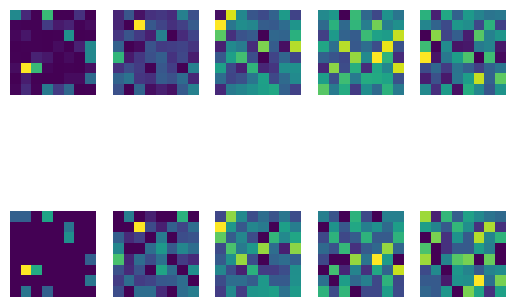

4810 tensor(0.1813, device='cuda:0', grad_fn=<MseLossBackward0>)


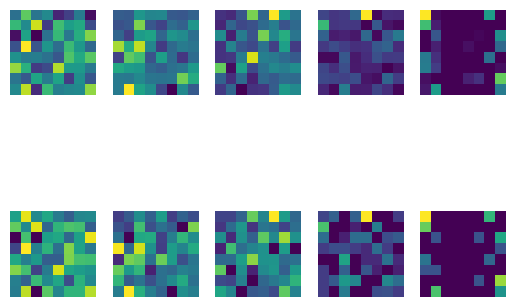

4820 tensor(0.1730, device='cuda:0', grad_fn=<MseLossBackward0>)


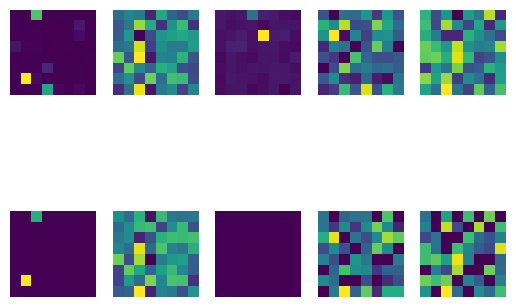

4830 tensor(0.1560, device='cuda:0', grad_fn=<MseLossBackward0>)


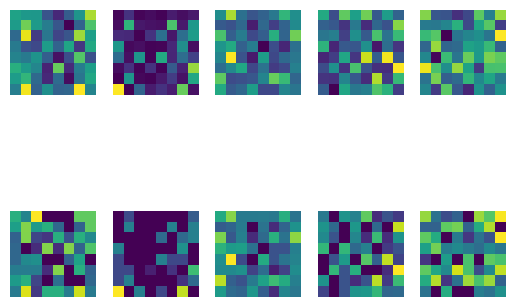

4840 tensor(0.1842, device='cuda:0', grad_fn=<MseLossBackward0>)


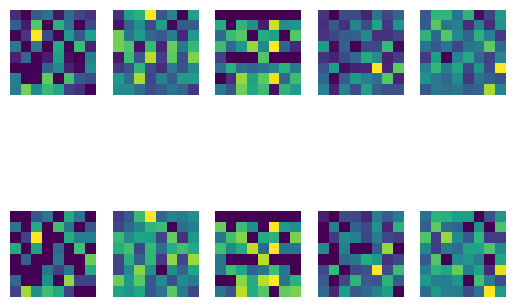

4850 tensor(0.1856, device='cuda:0', grad_fn=<MseLossBackward0>)


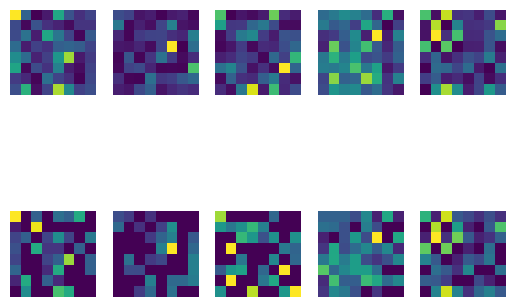

4860 tensor(0.1812, device='cuda:0', grad_fn=<MseLossBackward0>)


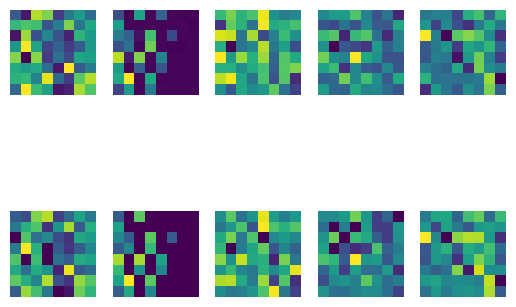

4870 tensor(0.1922, device='cuda:0', grad_fn=<MseLossBackward0>)


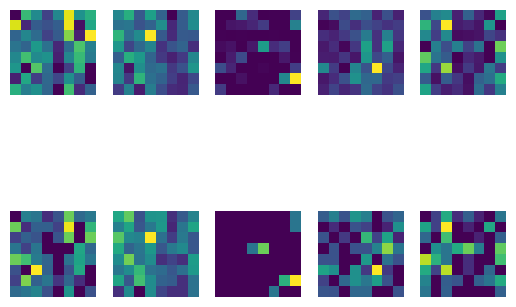

4880 tensor(0.1963, device='cuda:0', grad_fn=<MseLossBackward0>)


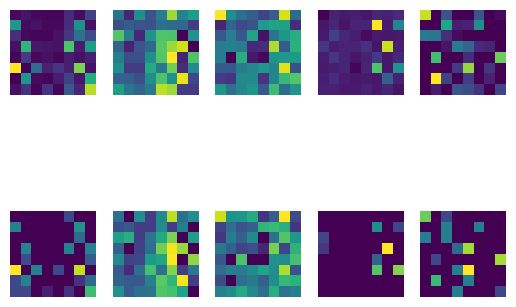

4890 tensor(0.1673, device='cuda:0', grad_fn=<MseLossBackward0>)


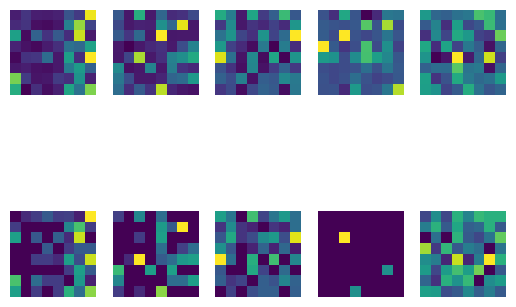

4900 tensor(0.1622, device='cuda:0', grad_fn=<MseLossBackward0>)


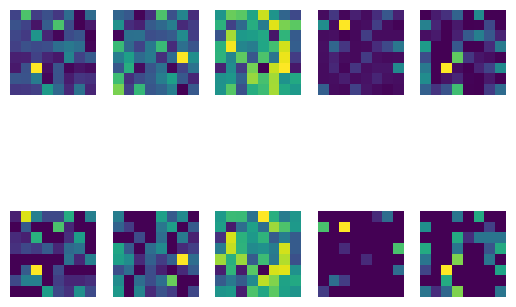

4910 tensor(0.1720, device='cuda:0', grad_fn=<MseLossBackward0>)


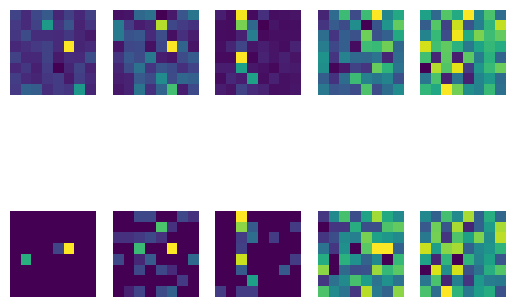

4920 tensor(0.1738, device='cuda:0', grad_fn=<MseLossBackward0>)


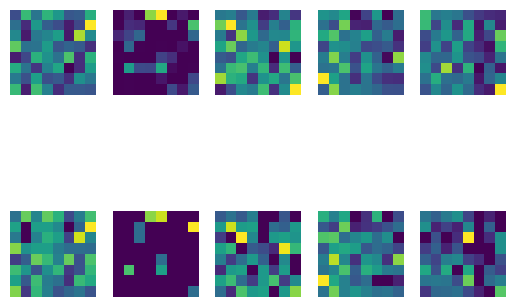

4930 tensor(0.1607, device='cuda:0', grad_fn=<MseLossBackward0>)


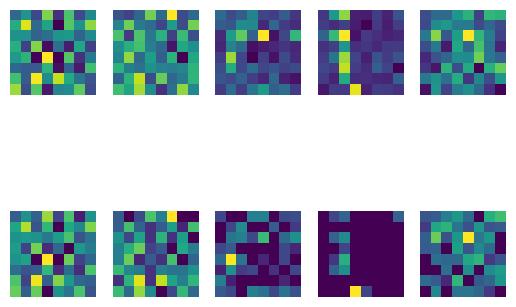

4940 tensor(0.1620, device='cuda:0', grad_fn=<MseLossBackward0>)


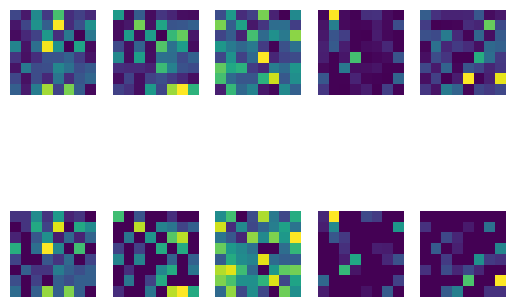

4950 tensor(0.1569, device='cuda:0', grad_fn=<MseLossBackward0>)


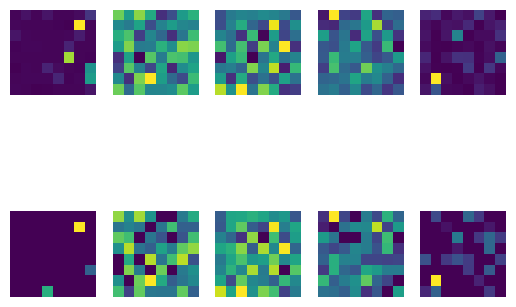

4960 tensor(0.1717, device='cuda:0', grad_fn=<MseLossBackward0>)


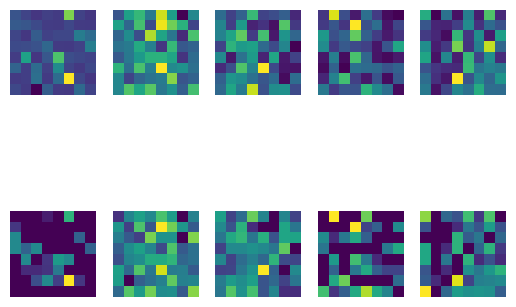

4970 tensor(0.1737, device='cuda:0', grad_fn=<MseLossBackward0>)


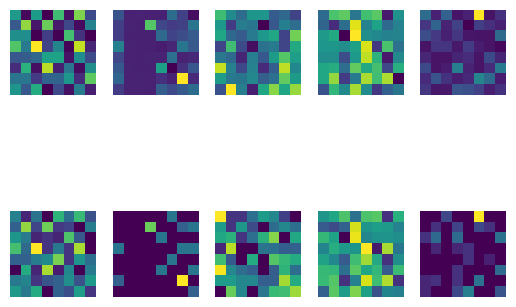

4980 tensor(0.1666, device='cuda:0', grad_fn=<MseLossBackward0>)


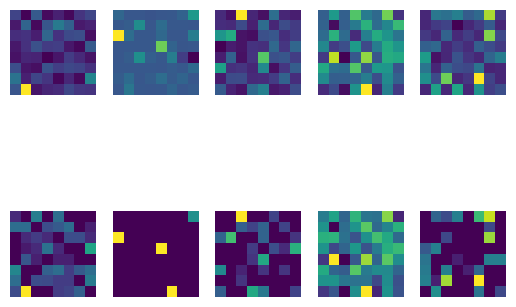

4990 tensor(0.1896, device='cuda:0', grad_fn=<MseLossBackward0>)


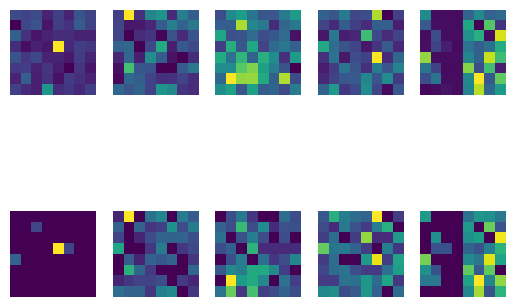

5000 tensor(0.1895, device='cuda:0', grad_fn=<MseLossBackward0>)


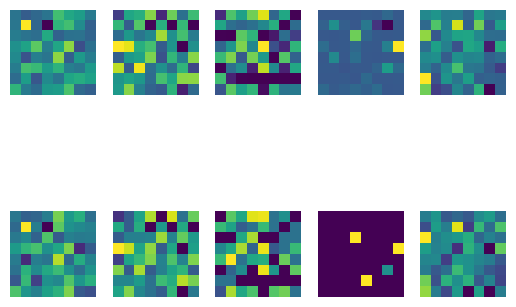

5010 tensor(0.1614, device='cuda:0', grad_fn=<MseLossBackward0>)


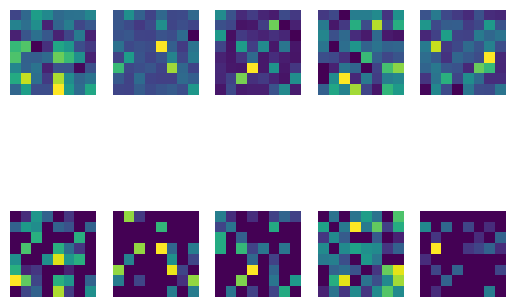

5020 tensor(0.1475, device='cuda:0', grad_fn=<MseLossBackward0>)


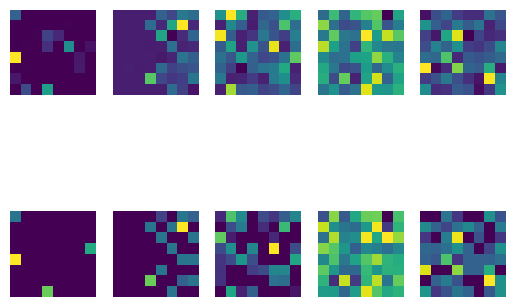

5030 tensor(0.1717, device='cuda:0', grad_fn=<MseLossBackward0>)


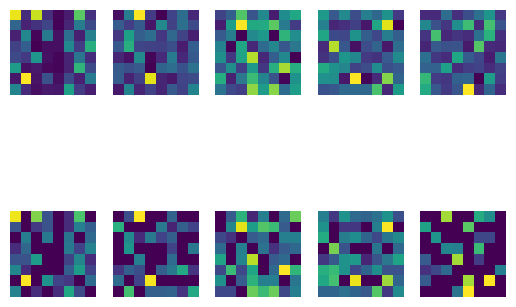

5040 tensor(0.1510, device='cuda:0', grad_fn=<MseLossBackward0>)


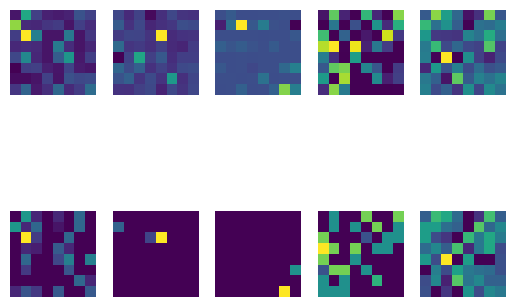

5050 tensor(0.2003, device='cuda:0', grad_fn=<MseLossBackward0>)


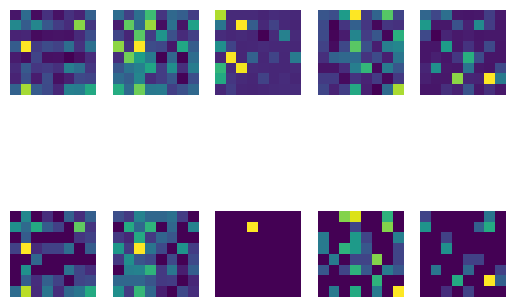

5060 tensor(0.1930, device='cuda:0', grad_fn=<MseLossBackward0>)


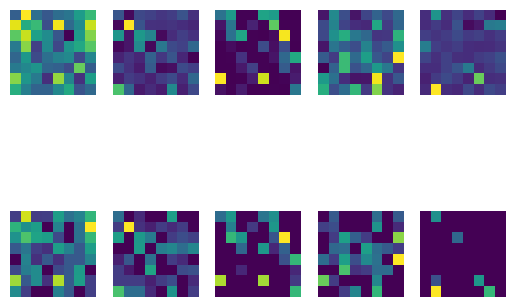

5070 tensor(0.1780, device='cuda:0', grad_fn=<MseLossBackward0>)


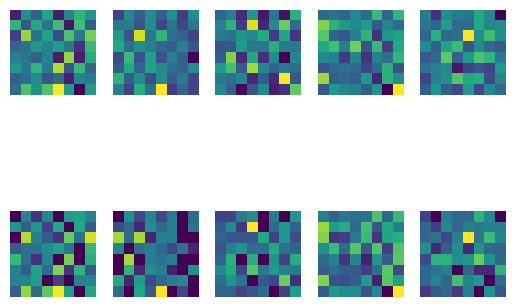

5080 tensor(0.1786, device='cuda:0', grad_fn=<MseLossBackward0>)


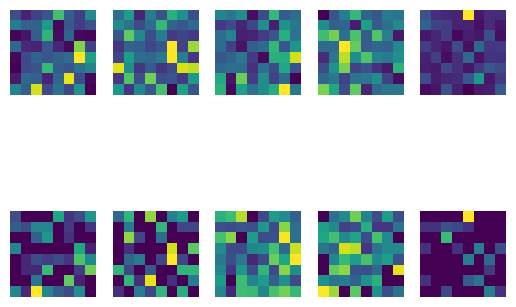

5090 tensor(0.1837, device='cuda:0', grad_fn=<MseLossBackward0>)


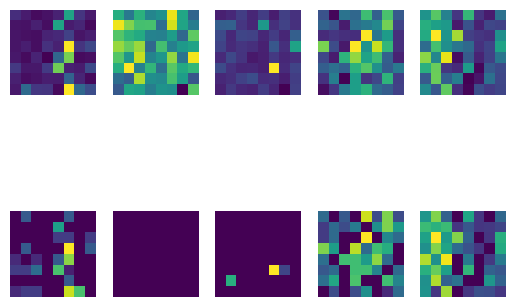

5100 tensor(0.1814, device='cuda:0', grad_fn=<MseLossBackward0>)


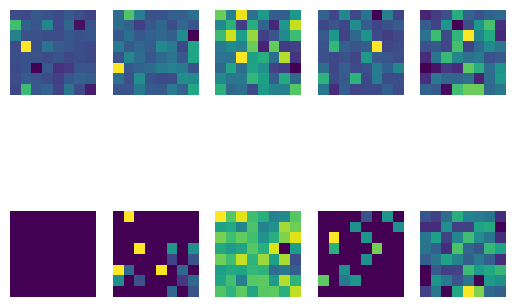

5110 tensor(0.1706, device='cuda:0', grad_fn=<MseLossBackward0>)


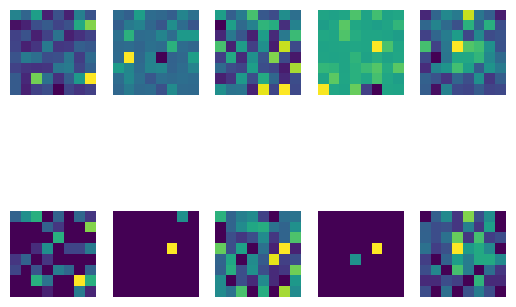

5120 tensor(0.1714, device='cuda:0', grad_fn=<MseLossBackward0>)


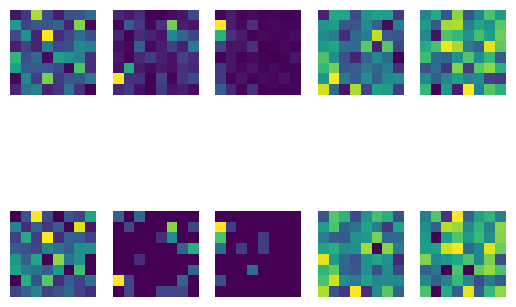

5130 tensor(0.1652, device='cuda:0', grad_fn=<MseLossBackward0>)


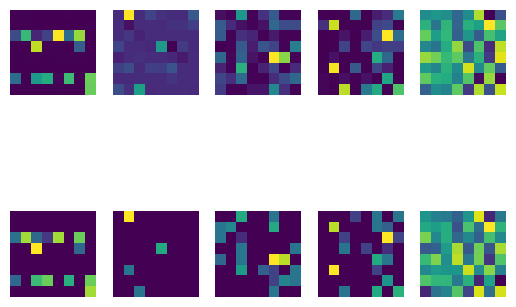

5140 tensor(0.1607, device='cuda:0', grad_fn=<MseLossBackward0>)


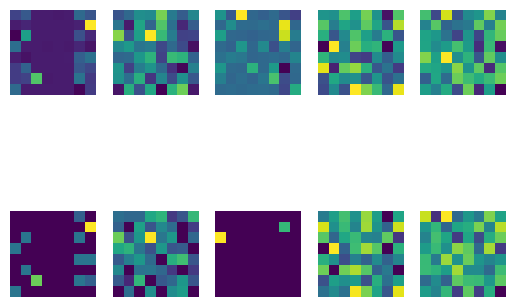

5150 tensor(0.1625, device='cuda:0', grad_fn=<MseLossBackward0>)


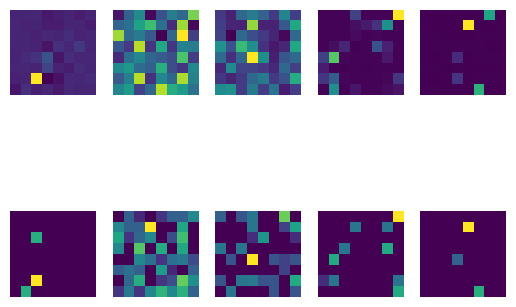

5160 tensor(0.1821, device='cuda:0', grad_fn=<MseLossBackward0>)


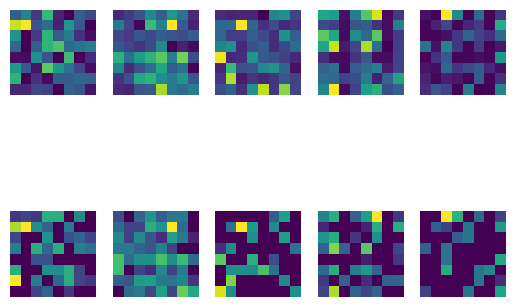

5170 tensor(0.1783, device='cuda:0', grad_fn=<MseLossBackward0>)


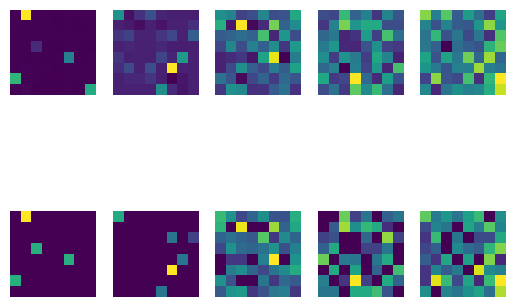

5180 tensor(0.1772, device='cuda:0', grad_fn=<MseLossBackward0>)


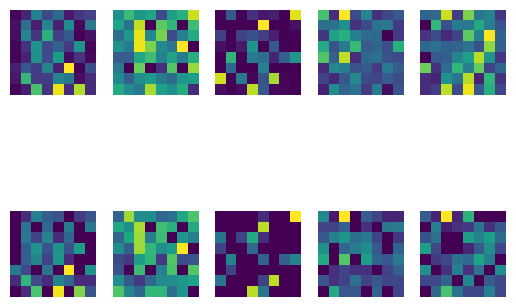

5190 tensor(0.1877, device='cuda:0', grad_fn=<MseLossBackward0>)


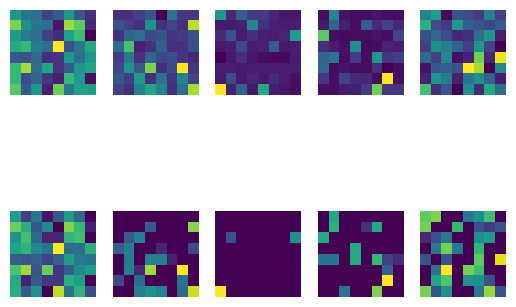

5200 tensor(0.1686, device='cuda:0', grad_fn=<MseLossBackward0>)


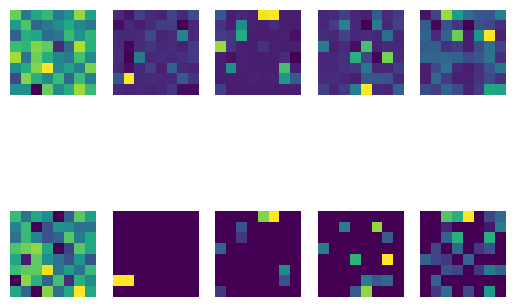

5210 tensor(0.1753, device='cuda:0', grad_fn=<MseLossBackward0>)


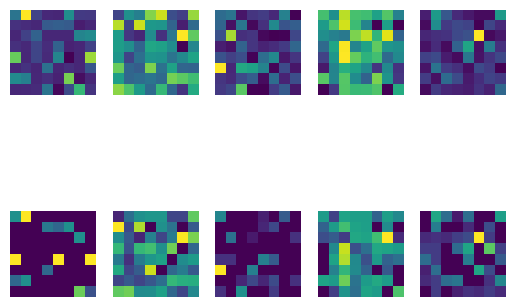

5220 tensor(0.1623, device='cuda:0', grad_fn=<MseLossBackward0>)


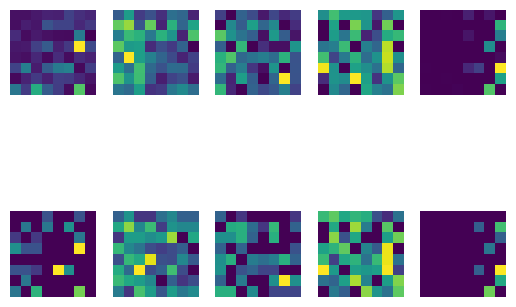

5230 tensor(0.1756, device='cuda:0', grad_fn=<MseLossBackward0>)


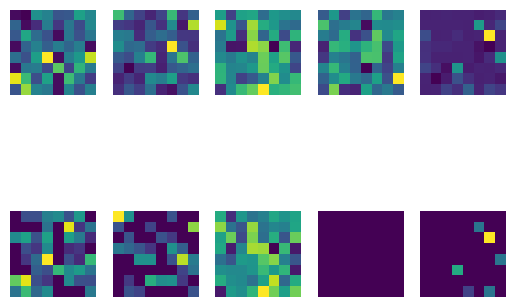

5240 tensor(0.1786, device='cuda:0', grad_fn=<MseLossBackward0>)


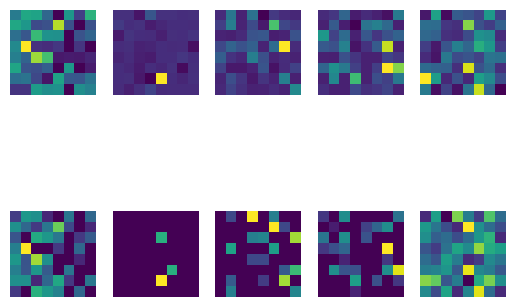

5250 tensor(0.1649, device='cuda:0', grad_fn=<MseLossBackward0>)


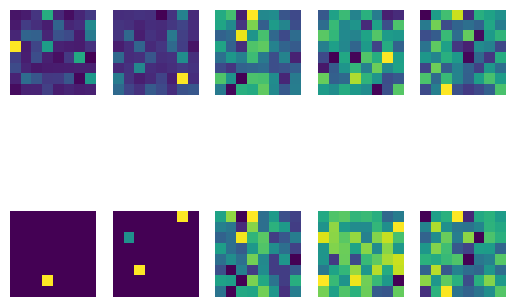

5260 tensor(0.1753, device='cuda:0', grad_fn=<MseLossBackward0>)


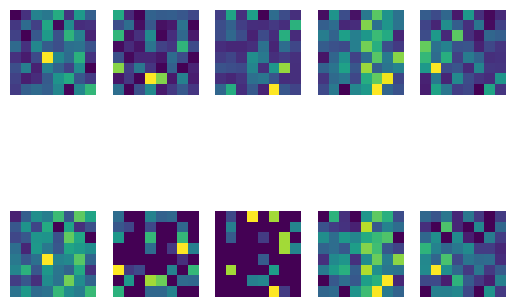

5270 tensor(0.1615, device='cuda:0', grad_fn=<MseLossBackward0>)


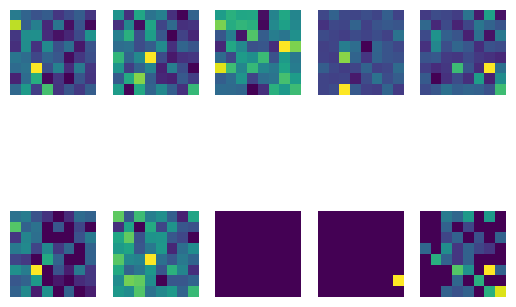

5280 tensor(0.1682, device='cuda:0', grad_fn=<MseLossBackward0>)


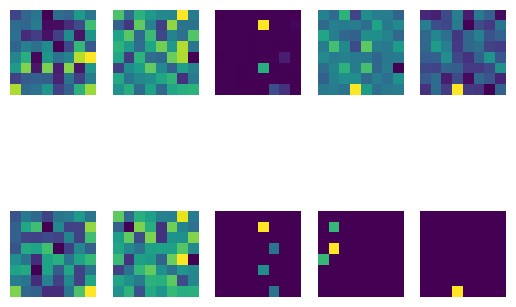

5290 tensor(0.1690, device='cuda:0', grad_fn=<MseLossBackward0>)


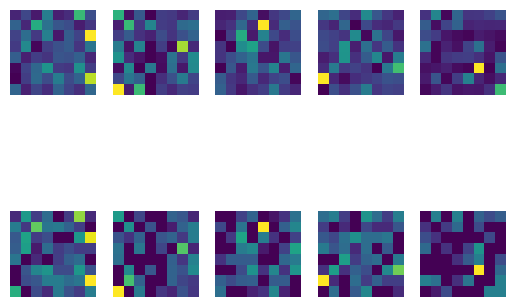

5300 tensor(0.1723, device='cuda:0', grad_fn=<MseLossBackward0>)


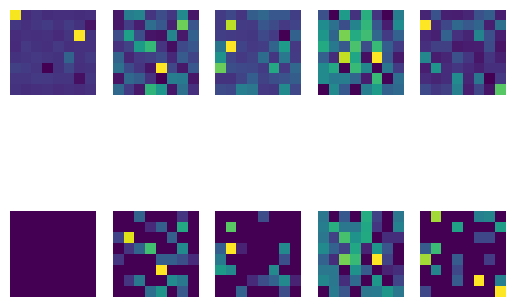

5310 tensor(0.1892, device='cuda:0', grad_fn=<MseLossBackward0>)


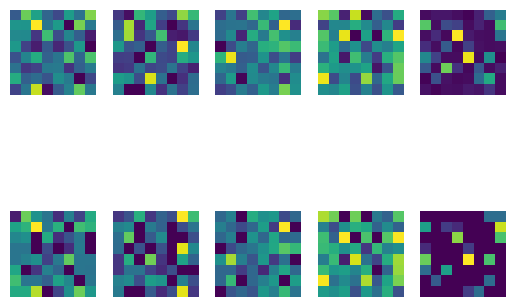

5320 tensor(0.1861, device='cuda:0', grad_fn=<MseLossBackward0>)


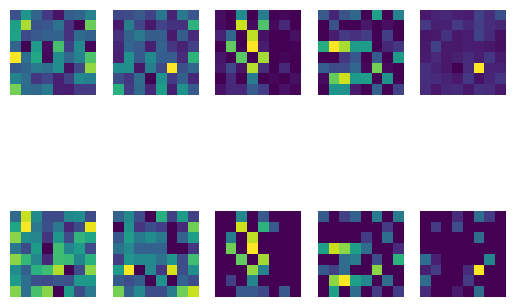

5330 tensor(0.1704, device='cuda:0', grad_fn=<MseLossBackward0>)


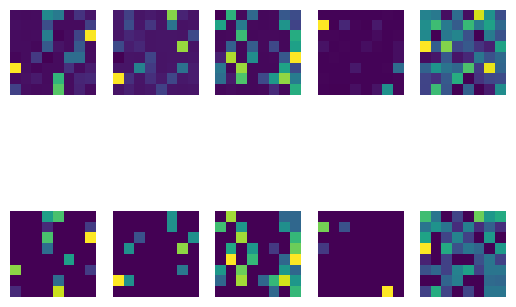

5340 tensor(0.1544, device='cuda:0', grad_fn=<MseLossBackward0>)


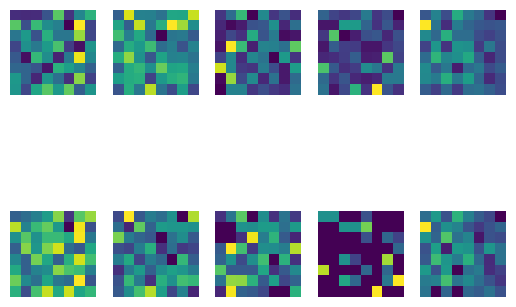

5350 tensor(0.1776, device='cuda:0', grad_fn=<MseLossBackward0>)


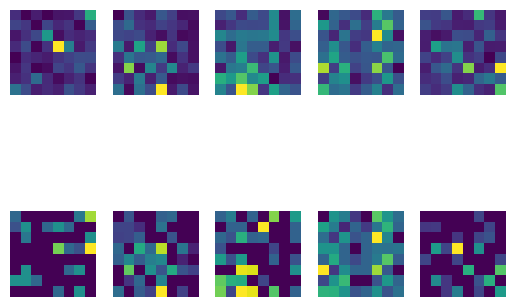

5360 tensor(0.1779, device='cuda:0', grad_fn=<MseLossBackward0>)


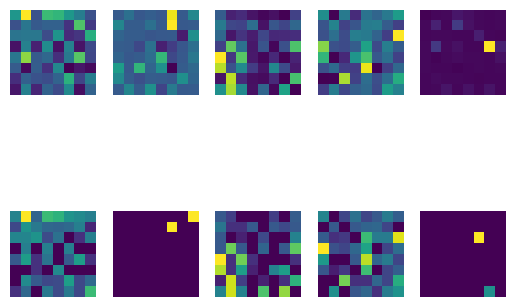

5370 tensor(0.1675, device='cuda:0', grad_fn=<MseLossBackward0>)


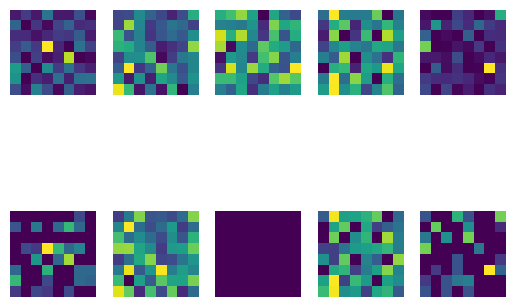

5380 tensor(0.1760, device='cuda:0', grad_fn=<MseLossBackward0>)


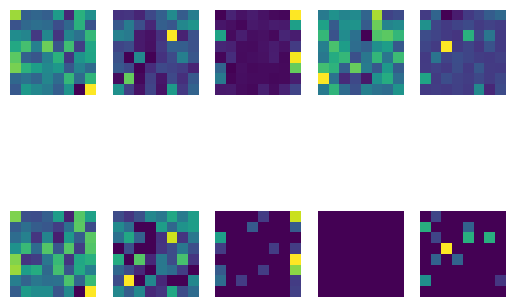

5390 tensor(0.2028, device='cuda:0', grad_fn=<MseLossBackward0>)


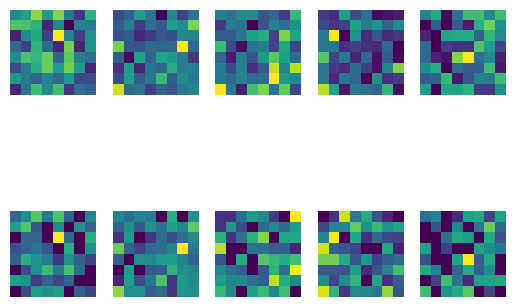

5400 tensor(0.1592, device='cuda:0', grad_fn=<MseLossBackward0>)


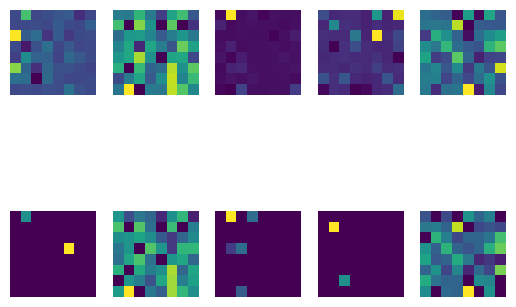

5410 tensor(0.1744, device='cuda:0', grad_fn=<MseLossBackward0>)


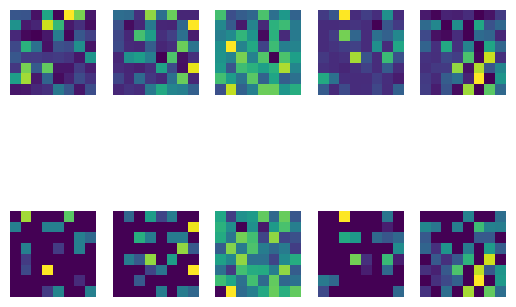

5420 tensor(0.1875, device='cuda:0', grad_fn=<MseLossBackward0>)


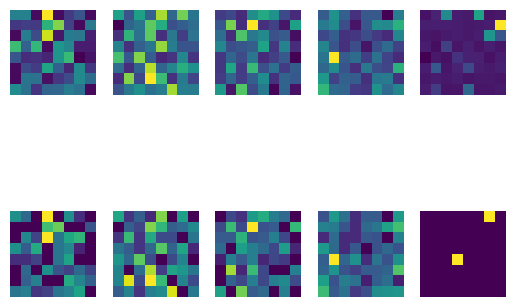

5430 tensor(0.1702, device='cuda:0', grad_fn=<MseLossBackward0>)


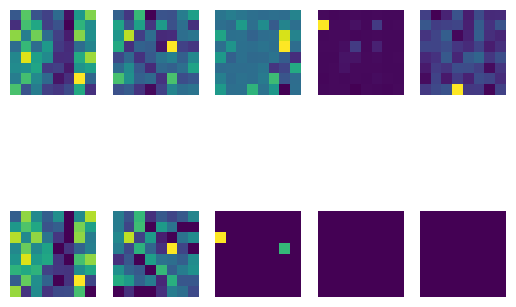

5440 tensor(0.1901, device='cuda:0', grad_fn=<MseLossBackward0>)


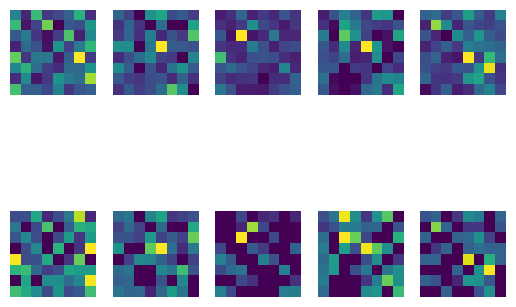

5450 tensor(0.1721, device='cuda:0', grad_fn=<MseLossBackward0>)


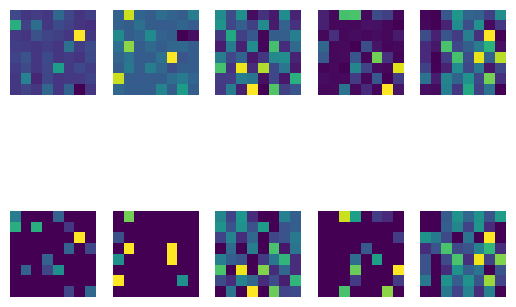

5460 tensor(0.1681, device='cuda:0', grad_fn=<MseLossBackward0>)


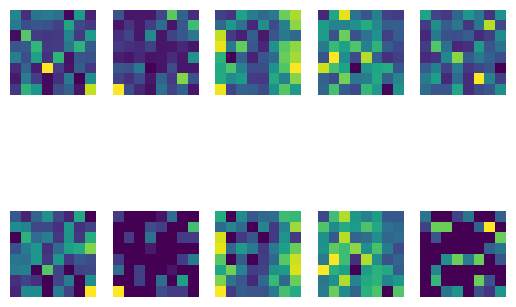

5470 tensor(0.1949, device='cuda:0', grad_fn=<MseLossBackward0>)


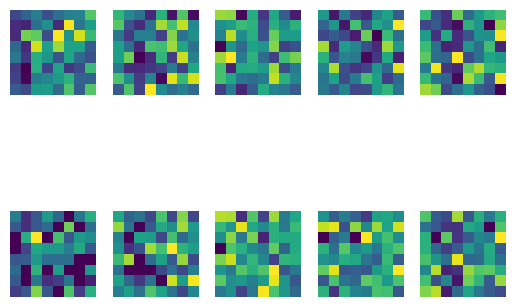

5480 tensor(0.1645, device='cuda:0', grad_fn=<MseLossBackward0>)


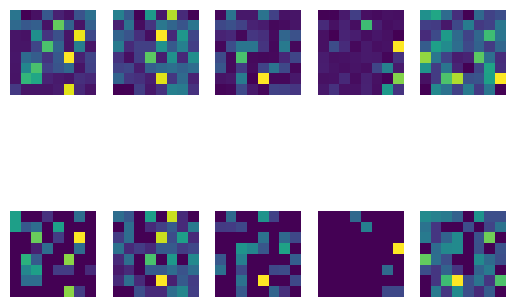

5490 tensor(0.1581, device='cuda:0', grad_fn=<MseLossBackward0>)


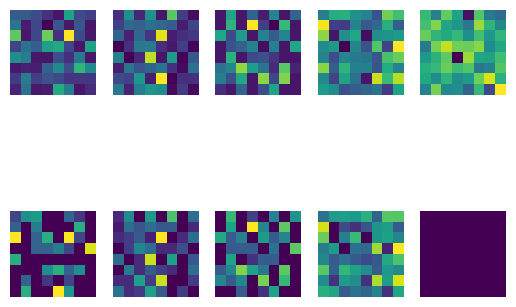

5500 tensor(0.1875, device='cuda:0', grad_fn=<MseLossBackward0>)


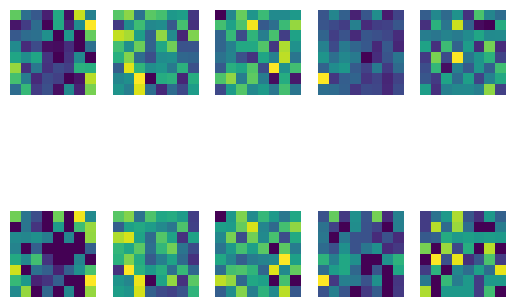

5510 tensor(0.1842, device='cuda:0', grad_fn=<MseLossBackward0>)


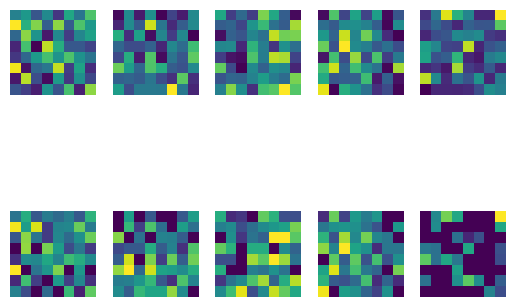

5520 tensor(0.1366, device='cuda:0', grad_fn=<MseLossBackward0>)


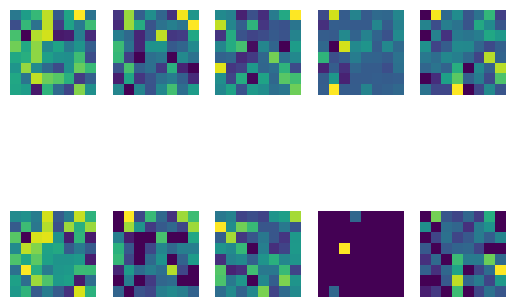

5530 tensor(0.1648, device='cuda:0', grad_fn=<MseLossBackward0>)


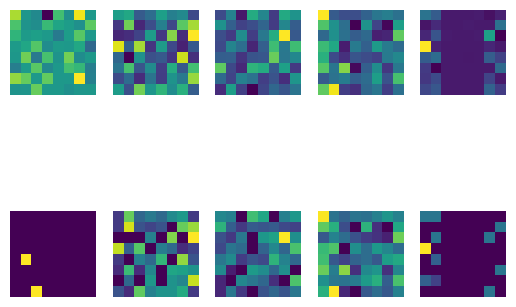

5540 tensor(0.1245, device='cuda:0', grad_fn=<MseLossBackward0>)


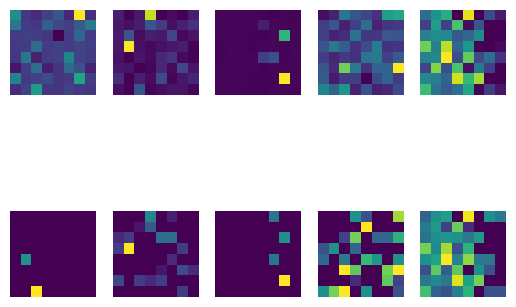

5550 tensor(0.1646, device='cuda:0', grad_fn=<MseLossBackward0>)


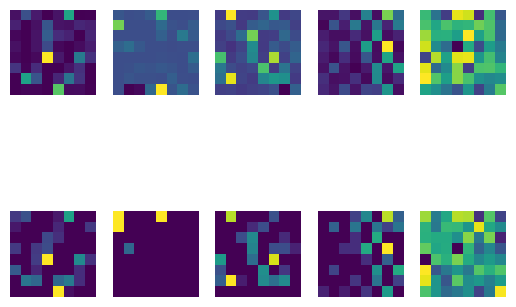

5560 tensor(0.1827, device='cuda:0', grad_fn=<MseLossBackward0>)


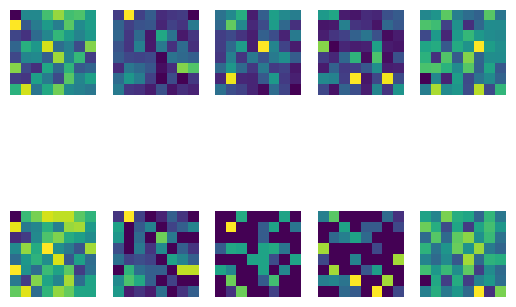

5570 tensor(0.1812, device='cuda:0', grad_fn=<MseLossBackward0>)


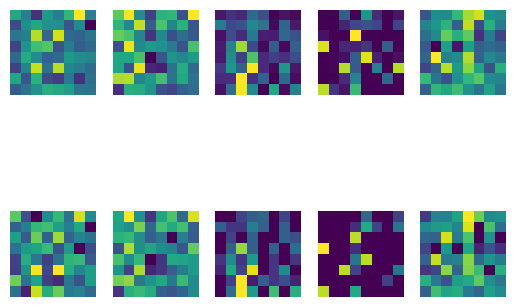

5580 tensor(0.1673, device='cuda:0', grad_fn=<MseLossBackward0>)


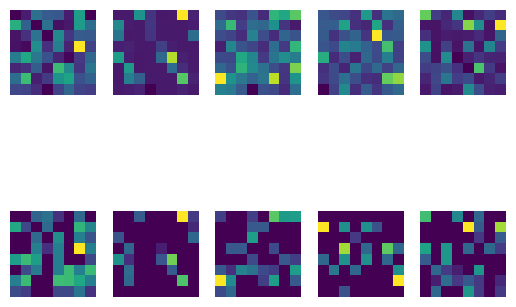

5590 tensor(0.1699, device='cuda:0', grad_fn=<MseLossBackward0>)


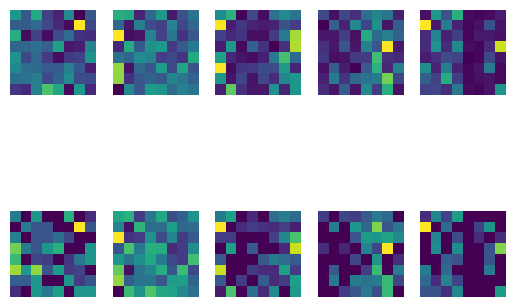

5600 tensor(0.1544, device='cuda:0', grad_fn=<MseLossBackward0>)


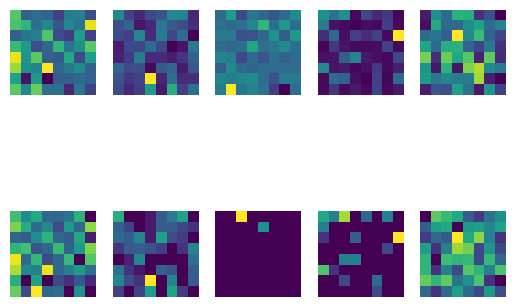

5610 tensor(0.1750, device='cuda:0', grad_fn=<MseLossBackward0>)


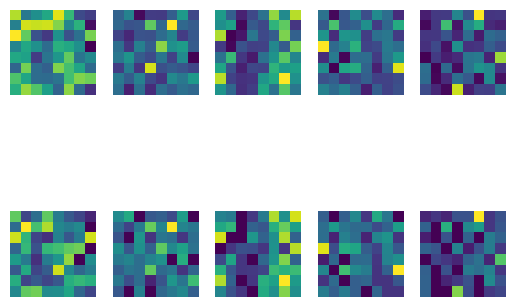

5620 tensor(0.1465, device='cuda:0', grad_fn=<MseLossBackward0>)


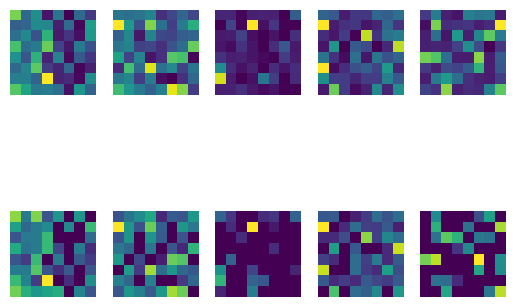

5630 tensor(0.2080, device='cuda:0', grad_fn=<MseLossBackward0>)


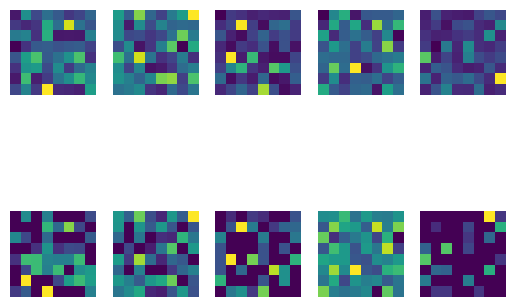

5640 tensor(0.1506, device='cuda:0', grad_fn=<MseLossBackward0>)


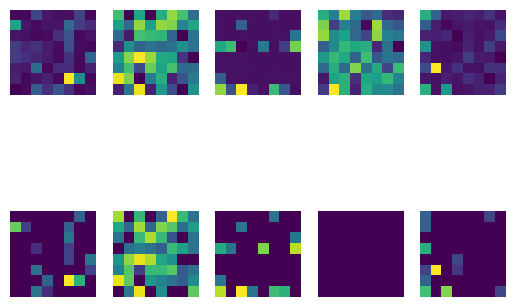

5650 tensor(0.1699, device='cuda:0', grad_fn=<MseLossBackward0>)


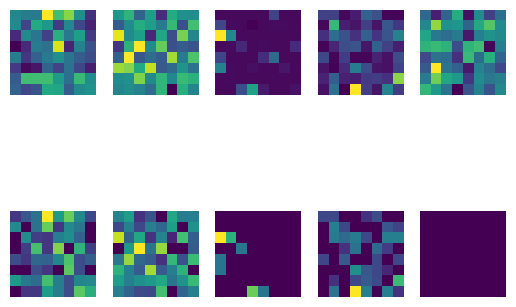

5660 tensor(0.1721, device='cuda:0', grad_fn=<MseLossBackward0>)


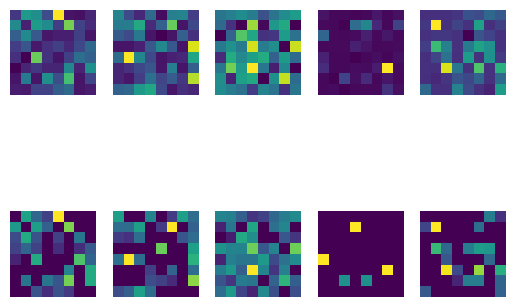

5670 tensor(0.1930, device='cuda:0', grad_fn=<MseLossBackward0>)


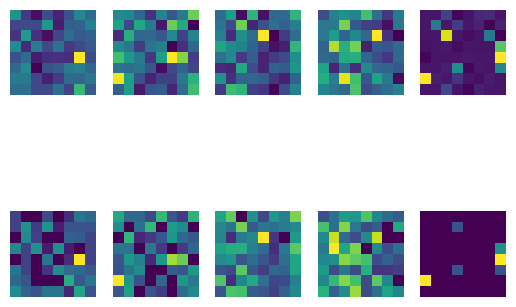

5680 tensor(0.1828, device='cuda:0', grad_fn=<MseLossBackward0>)


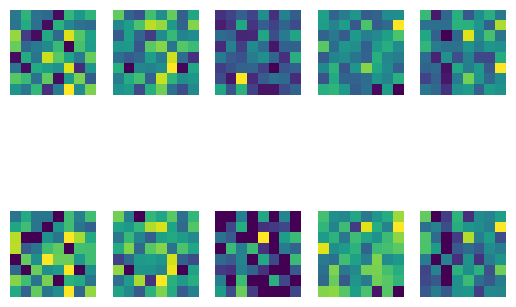

5690 tensor(0.1897, device='cuda:0', grad_fn=<MseLossBackward0>)


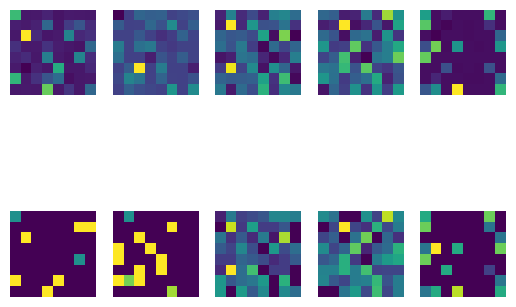

5700 tensor(0.1618, device='cuda:0', grad_fn=<MseLossBackward0>)


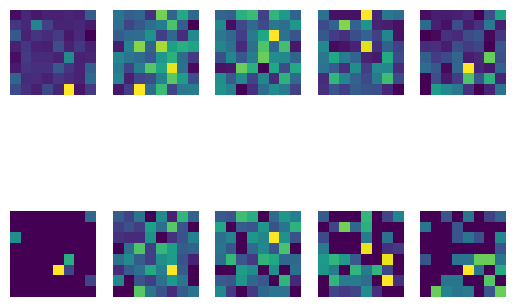

5710 tensor(0.1880, device='cuda:0', grad_fn=<MseLossBackward0>)


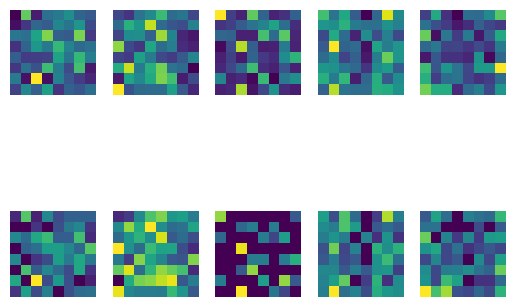

5720 tensor(0.1890, device='cuda:0', grad_fn=<MseLossBackward0>)


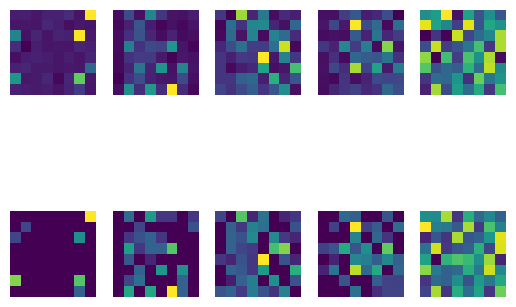

5730 tensor(0.1728, device='cuda:0', grad_fn=<MseLossBackward0>)


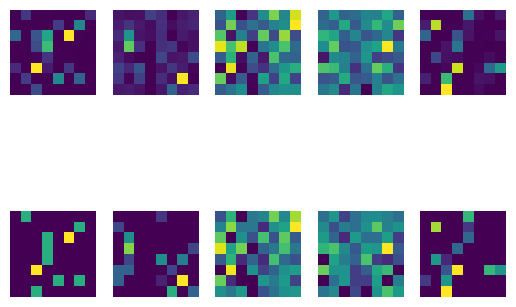

5740 tensor(0.1841, device='cuda:0', grad_fn=<MseLossBackward0>)


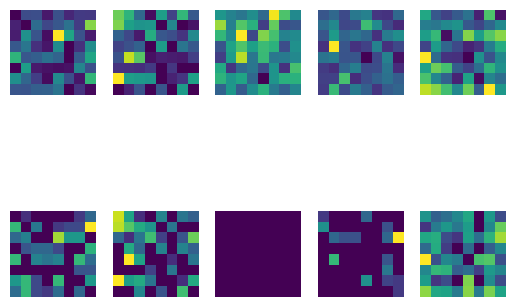

5750 tensor(0.1664, device='cuda:0', grad_fn=<MseLossBackward0>)


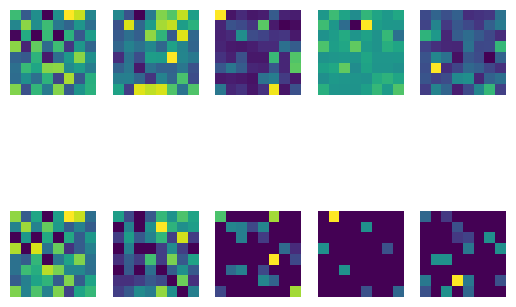

5760 tensor(0.1633, device='cuda:0', grad_fn=<MseLossBackward0>)


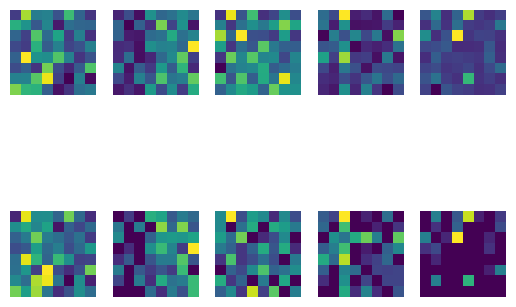

5770 tensor(0.1570, device='cuda:0', grad_fn=<MseLossBackward0>)


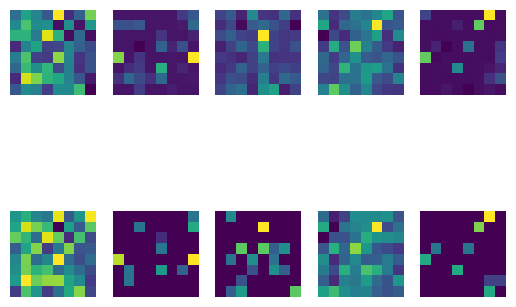

5780 tensor(0.1849, device='cuda:0', grad_fn=<MseLossBackward0>)


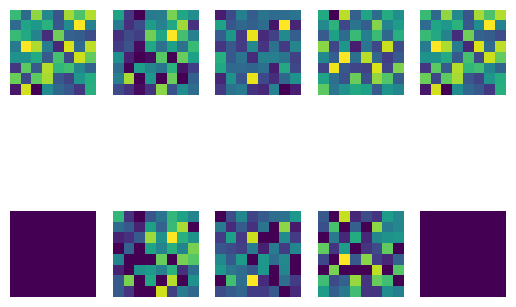

5790 tensor(0.1720, device='cuda:0', grad_fn=<MseLossBackward0>)


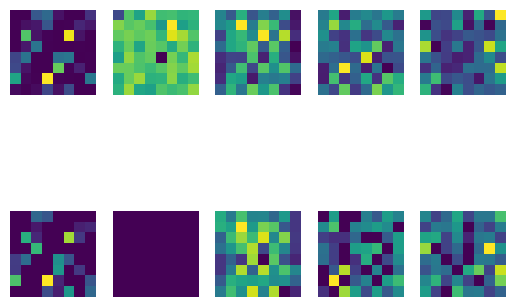

5800 tensor(0.1407, device='cuda:0', grad_fn=<MseLossBackward0>)


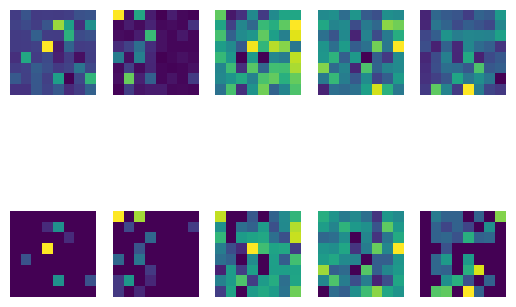

5810 tensor(0.1658, device='cuda:0', grad_fn=<MseLossBackward0>)


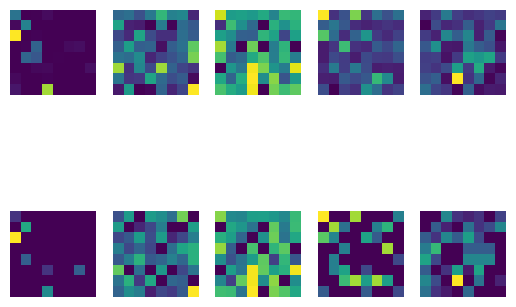

5820 tensor(0.1572, device='cuda:0', grad_fn=<MseLossBackward0>)


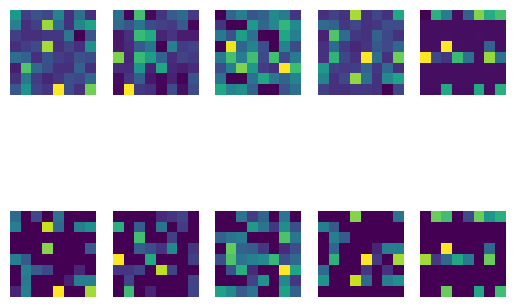

5830 tensor(0.1867, device='cuda:0', grad_fn=<MseLossBackward0>)


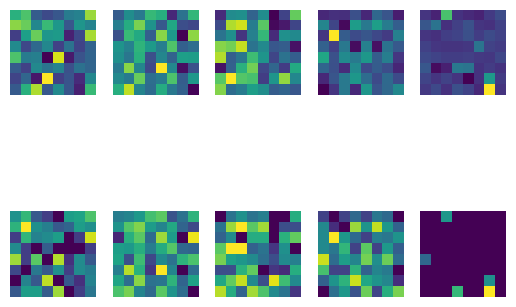

5840 tensor(0.1840, device='cuda:0', grad_fn=<MseLossBackward0>)


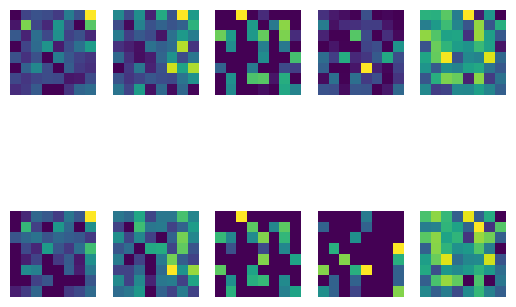

5850 tensor(0.1949, device='cuda:0', grad_fn=<MseLossBackward0>)


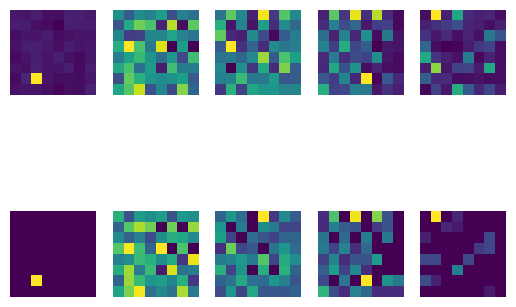

5860 tensor(0.1829, device='cuda:0', grad_fn=<MseLossBackward0>)


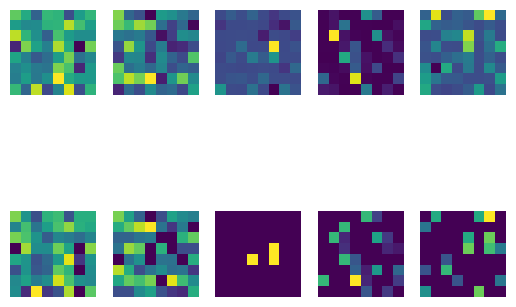

5870 tensor(0.2014, device='cuda:0', grad_fn=<MseLossBackward0>)


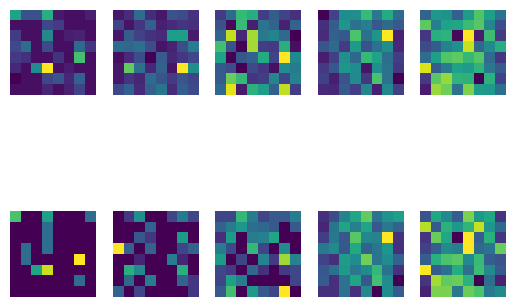

5880 tensor(0.1863, device='cuda:0', grad_fn=<MseLossBackward0>)


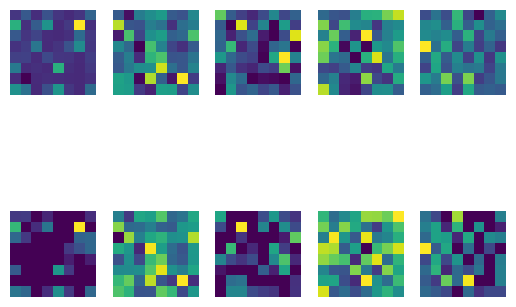

5890 tensor(0.1815, device='cuda:0', grad_fn=<MseLossBackward0>)


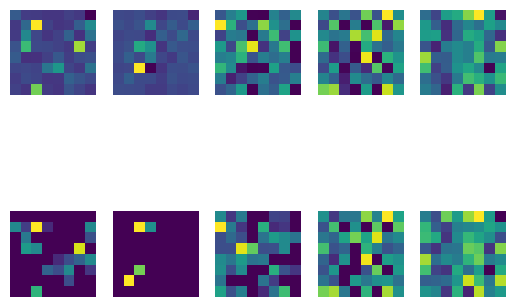

5900 tensor(0.1746, device='cuda:0', grad_fn=<MseLossBackward0>)


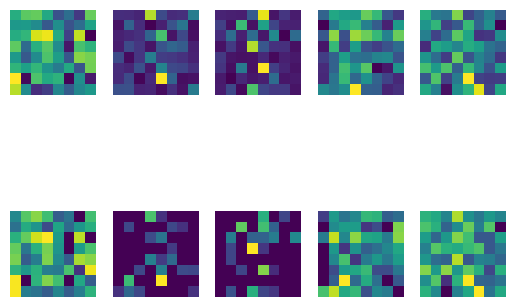

5910 tensor(0.1876, device='cuda:0', grad_fn=<MseLossBackward0>)


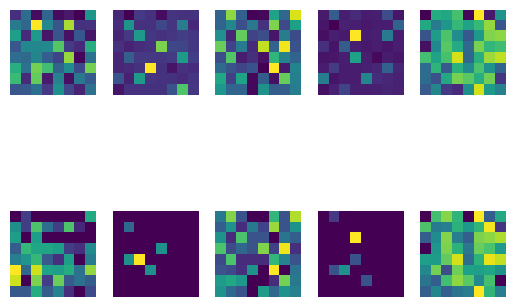

5920 tensor(0.2026, device='cuda:0', grad_fn=<MseLossBackward0>)


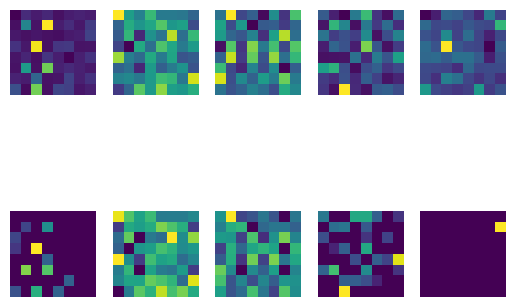

5930 tensor(0.1643, device='cuda:0', grad_fn=<MseLossBackward0>)


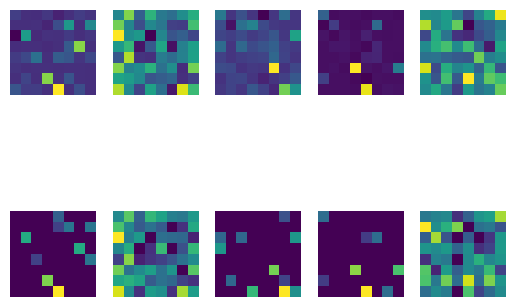

5940 tensor(0.1714, device='cuda:0', grad_fn=<MseLossBackward0>)


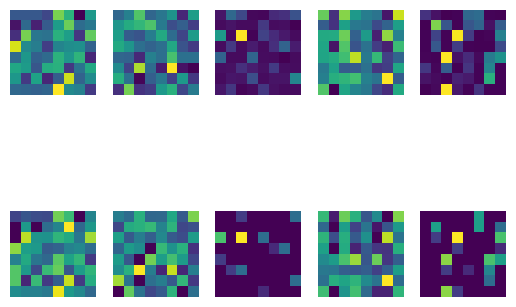

5950 tensor(0.1888, device='cuda:0', grad_fn=<MseLossBackward0>)


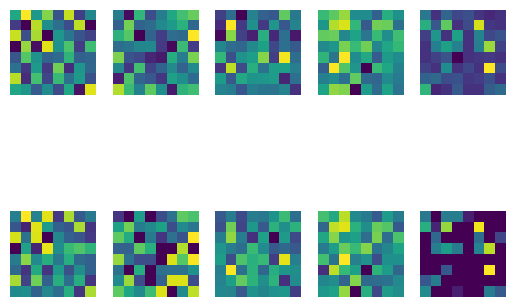

5960 tensor(0.1887, device='cuda:0', grad_fn=<MseLossBackward0>)


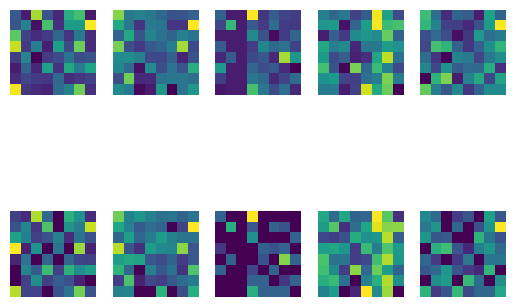

5970 tensor(0.1764, device='cuda:0', grad_fn=<MseLossBackward0>)


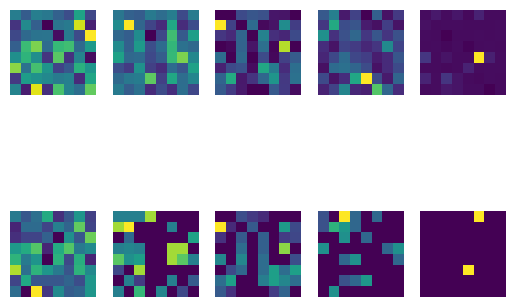

5980 tensor(0.1770, device='cuda:0', grad_fn=<MseLossBackward0>)


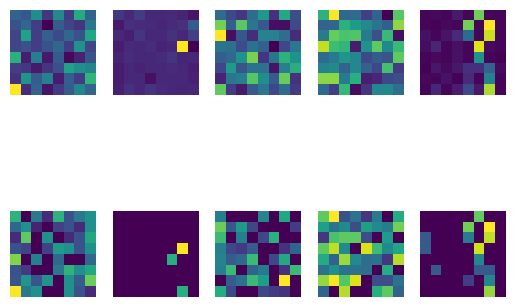

5990 tensor(0.1336, device='cuda:0', grad_fn=<MseLossBackward0>)


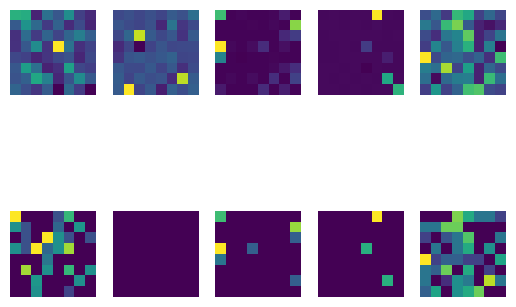

6000 tensor(0.2064, device='cuda:0', grad_fn=<MseLossBackward0>)


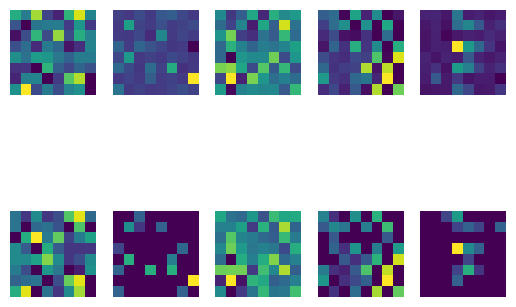

6010 tensor(0.1679, device='cuda:0', grad_fn=<MseLossBackward0>)


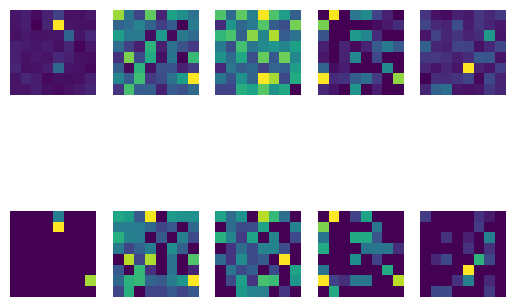

6020 tensor(0.1766, device='cuda:0', grad_fn=<MseLossBackward0>)


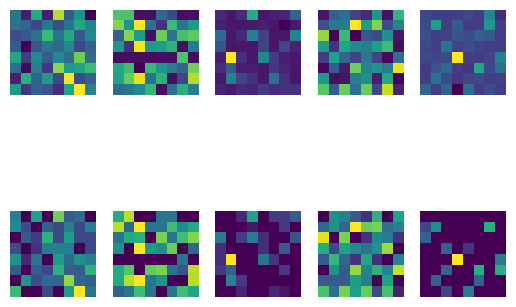

6030 tensor(0.1705, device='cuda:0', grad_fn=<MseLossBackward0>)


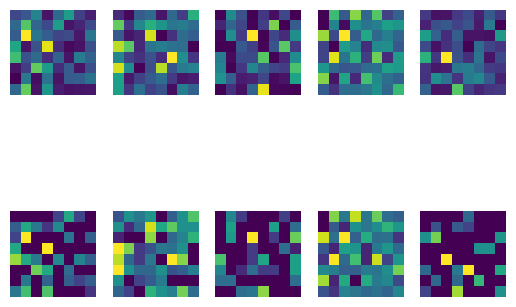

6040 tensor(0.1797, device='cuda:0', grad_fn=<MseLossBackward0>)


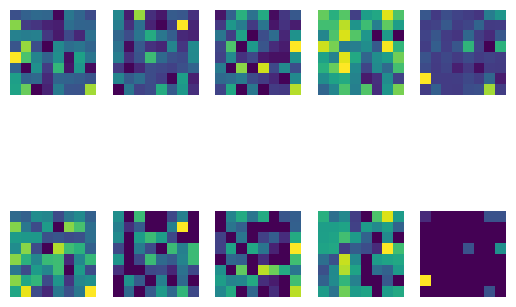

6050 tensor(0.1663, device='cuda:0', grad_fn=<MseLossBackward0>)


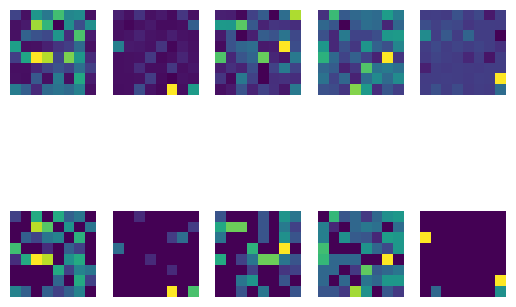

6060 tensor(0.1804, device='cuda:0', grad_fn=<MseLossBackward0>)


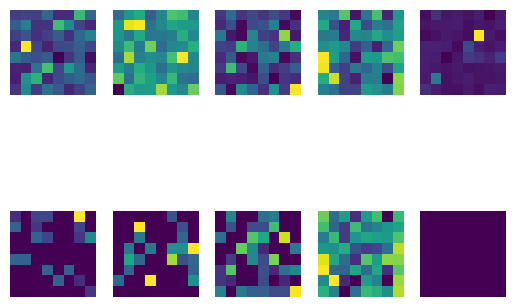

6070 tensor(0.1884, device='cuda:0', grad_fn=<MseLossBackward0>)


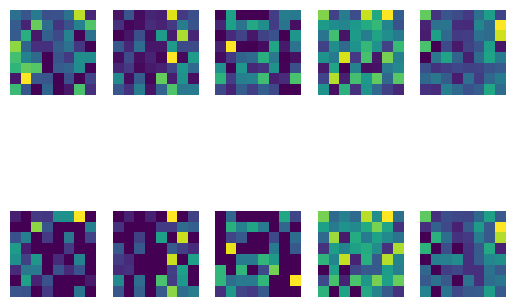

6080 tensor(0.1702, device='cuda:0', grad_fn=<MseLossBackward0>)


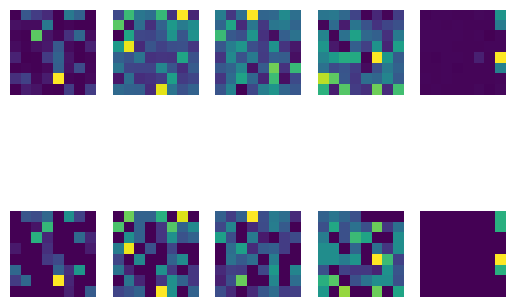

6090 tensor(0.1710, device='cuda:0', grad_fn=<MseLossBackward0>)


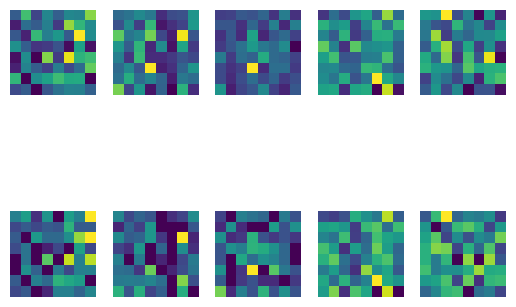

6100 tensor(0.1581, device='cuda:0', grad_fn=<MseLossBackward0>)


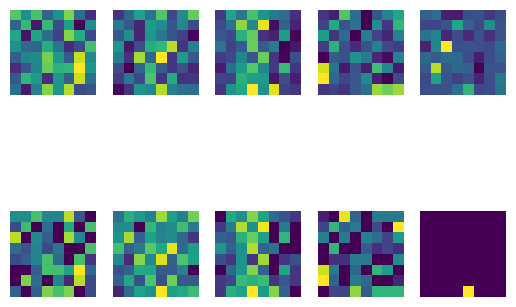

6110 tensor(0.1656, device='cuda:0', grad_fn=<MseLossBackward0>)


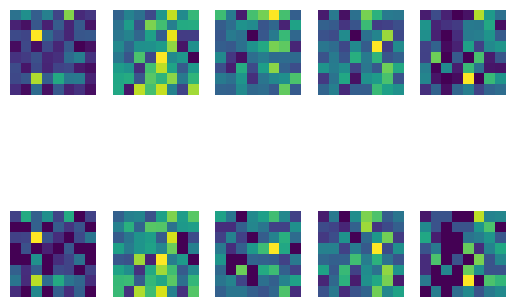

6120 tensor(0.1576, device='cuda:0', grad_fn=<MseLossBackward0>)


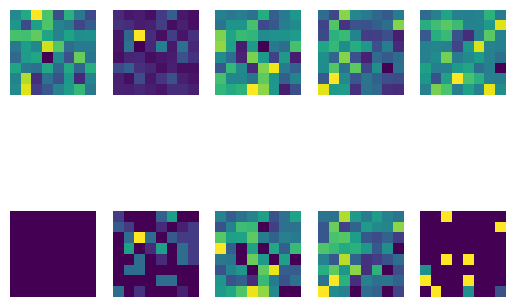

6130 tensor(0.1532, device='cuda:0', grad_fn=<MseLossBackward0>)


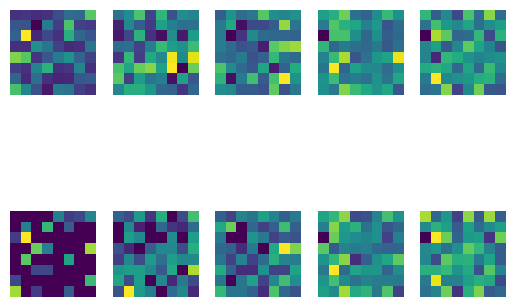

6140 tensor(0.1676, device='cuda:0', grad_fn=<MseLossBackward0>)


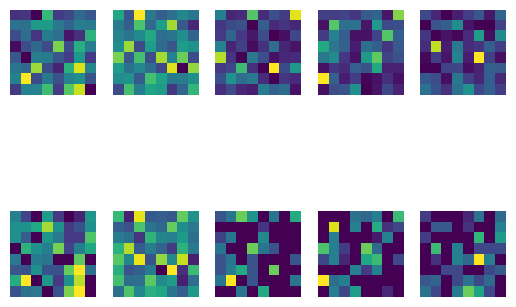

6150 tensor(0.1691, device='cuda:0', grad_fn=<MseLossBackward0>)


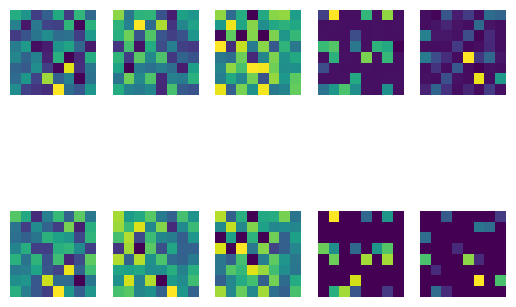

6160 tensor(0.1727, device='cuda:0', grad_fn=<MseLossBackward0>)


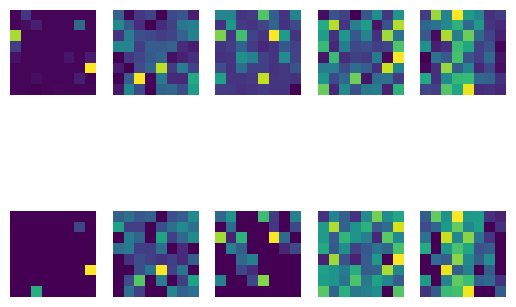

6170 tensor(0.2049, device='cuda:0', grad_fn=<MseLossBackward0>)


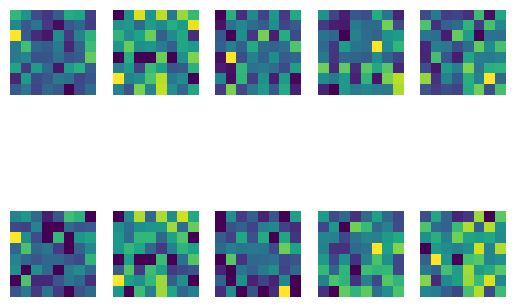

6180 tensor(0.1521, device='cuda:0', grad_fn=<MseLossBackward0>)


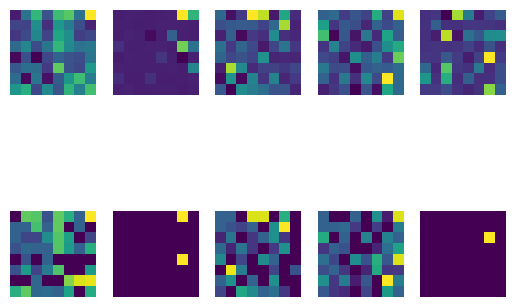

6190 tensor(0.1589, device='cuda:0', grad_fn=<MseLossBackward0>)


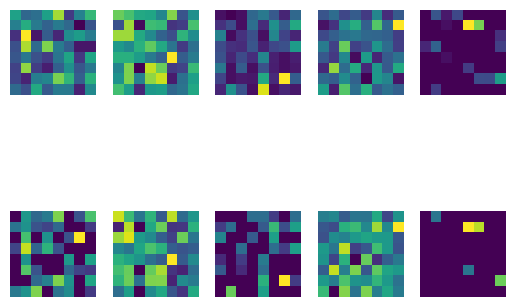

6200 tensor(0.1575, device='cuda:0', grad_fn=<MseLossBackward0>)


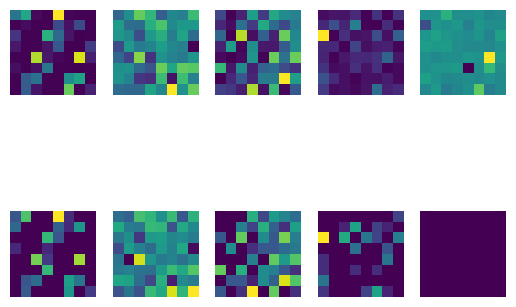

6210 tensor(0.1783, device='cuda:0', grad_fn=<MseLossBackward0>)


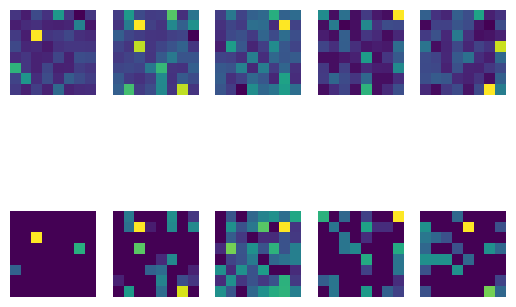

6220 tensor(0.1779, device='cuda:0', grad_fn=<MseLossBackward0>)


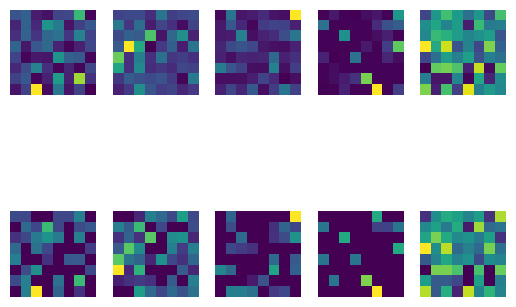

6230 tensor(0.1613, device='cuda:0', grad_fn=<MseLossBackward0>)


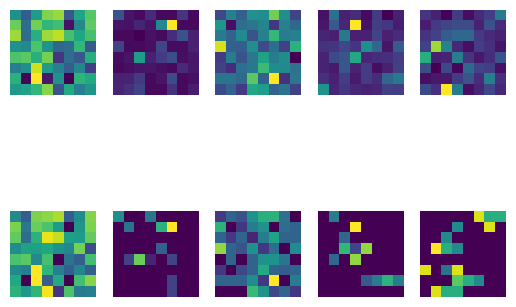

6240 tensor(0.1870, device='cuda:0', grad_fn=<MseLossBackward0>)


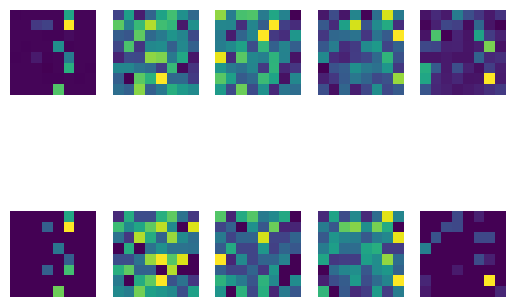

6250 tensor(0.1331, device='cuda:0', grad_fn=<MseLossBackward0>)


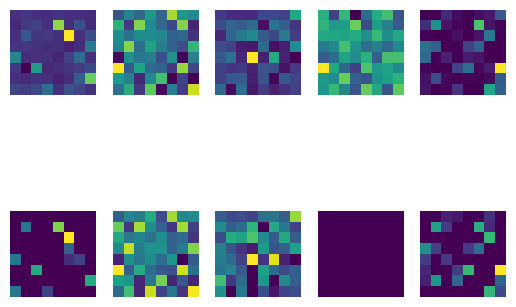

6260 tensor(0.1935, device='cuda:0', grad_fn=<MseLossBackward0>)


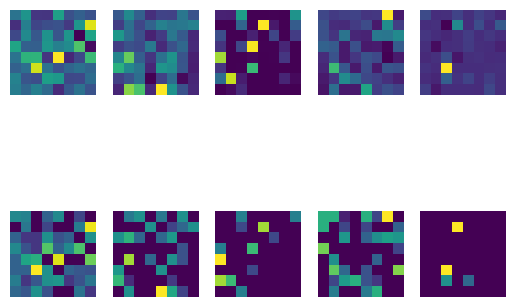

6270 tensor(0.1713, device='cuda:0', grad_fn=<MseLossBackward0>)


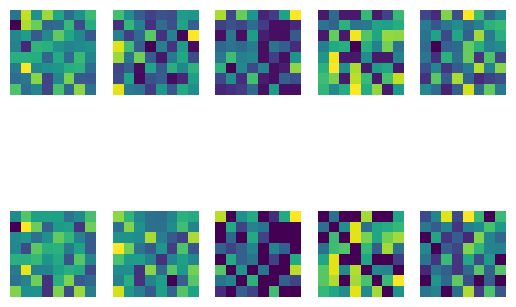

6280 tensor(0.1724, device='cuda:0', grad_fn=<MseLossBackward0>)


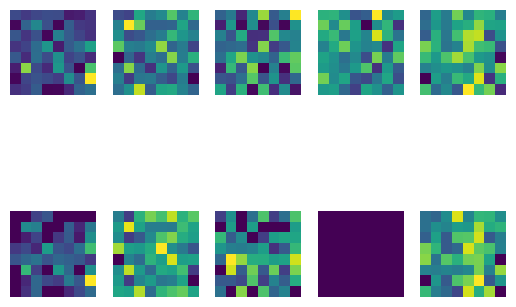

6290 tensor(0.1880, device='cuda:0', grad_fn=<MseLossBackward0>)


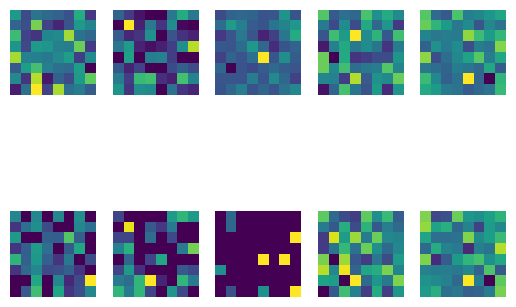

6300 tensor(0.1793, device='cuda:0', grad_fn=<MseLossBackward0>)


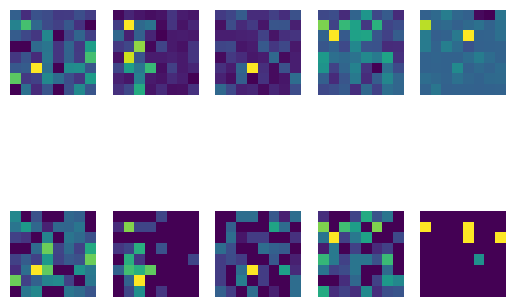

6310 tensor(0.1854, device='cuda:0', grad_fn=<MseLossBackward0>)


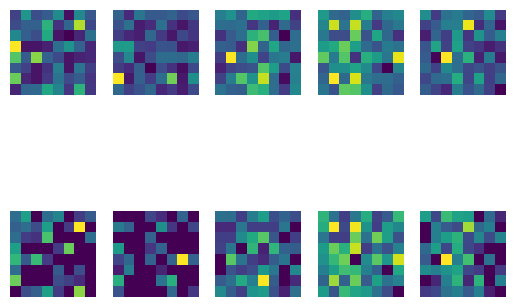

6320 tensor(0.1958, device='cuda:0', grad_fn=<MseLossBackward0>)


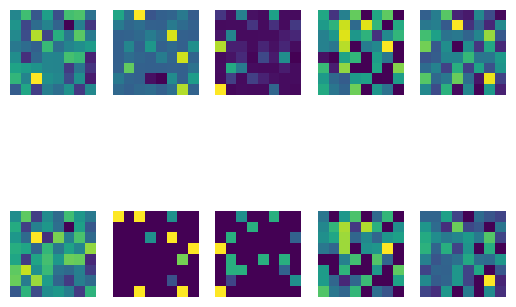

6330 tensor(0.1755, device='cuda:0', grad_fn=<MseLossBackward0>)


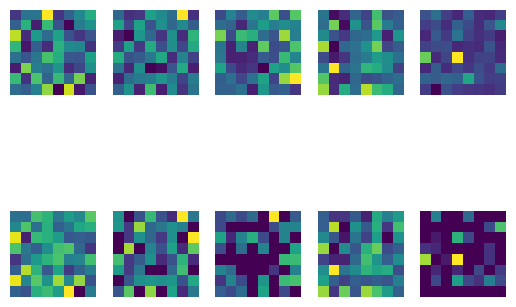

6340 tensor(0.1777, device='cuda:0', grad_fn=<MseLossBackward0>)


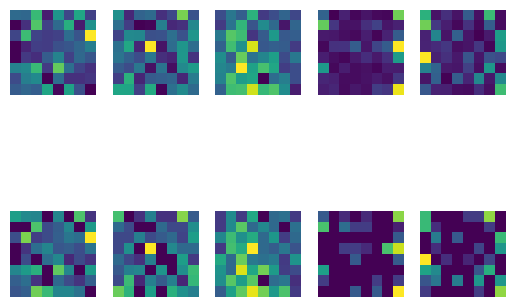

6350 tensor(0.1918, device='cuda:0', grad_fn=<MseLossBackward0>)


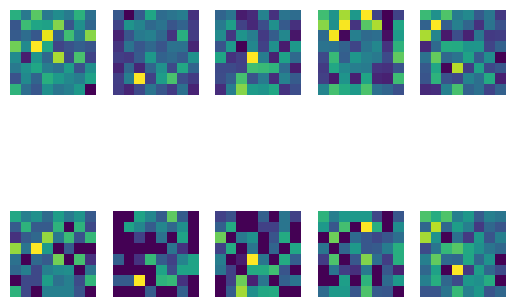

6360 tensor(0.1647, device='cuda:0', grad_fn=<MseLossBackward0>)


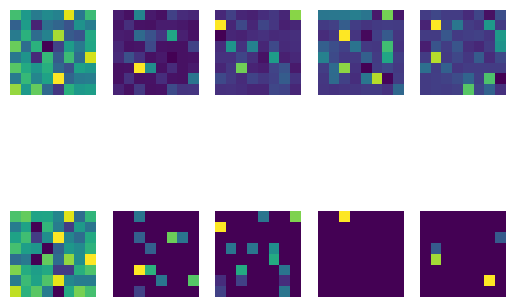

6370 tensor(0.1655, device='cuda:0', grad_fn=<MseLossBackward0>)


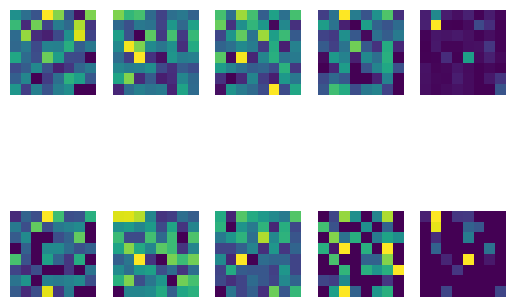

6380 tensor(0.1747, device='cuda:0', grad_fn=<MseLossBackward0>)


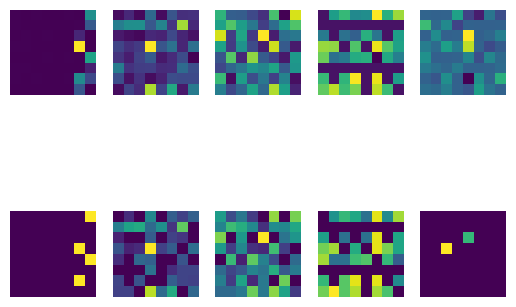

6390 tensor(0.1886, device='cuda:0', grad_fn=<MseLossBackward0>)


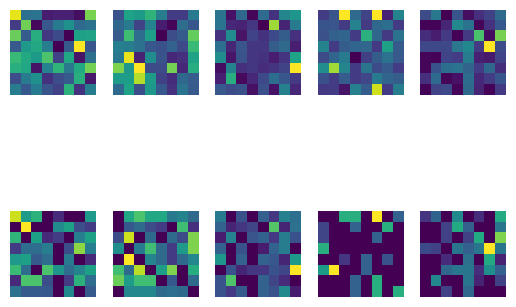

6400 tensor(0.1783, device='cuda:0', grad_fn=<MseLossBackward0>)


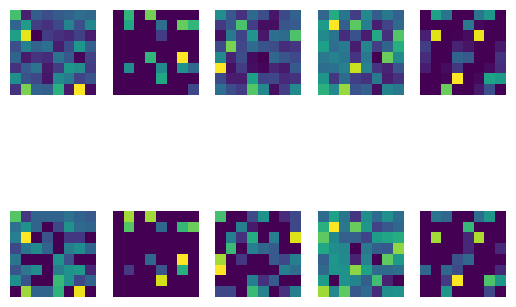

6410 tensor(0.1639, device='cuda:0', grad_fn=<MseLossBackward0>)


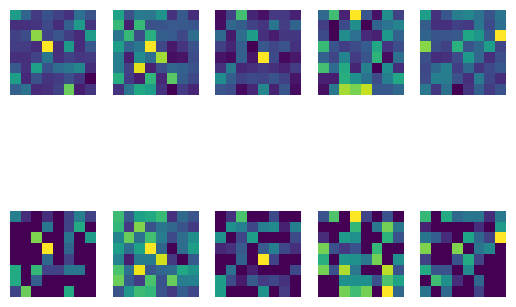

6420 tensor(0.2067, device='cuda:0', grad_fn=<MseLossBackward0>)


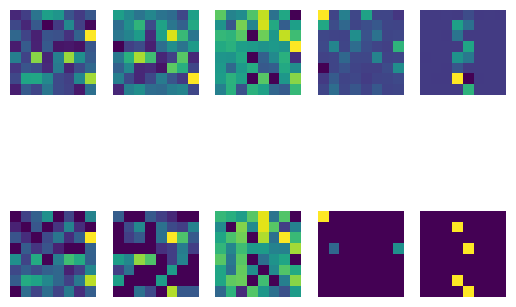

6430 tensor(0.1656, device='cuda:0', grad_fn=<MseLossBackward0>)


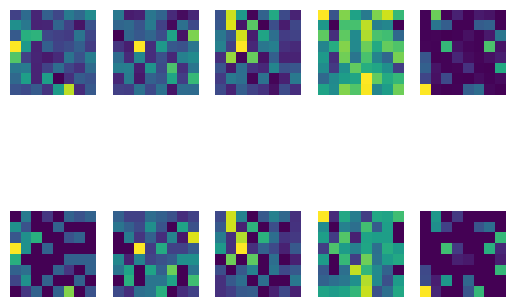

6440 tensor(0.1597, device='cuda:0', grad_fn=<MseLossBackward0>)


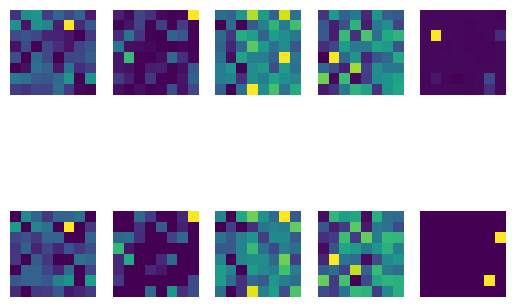

6450 tensor(0.1839, device='cuda:0', grad_fn=<MseLossBackward0>)


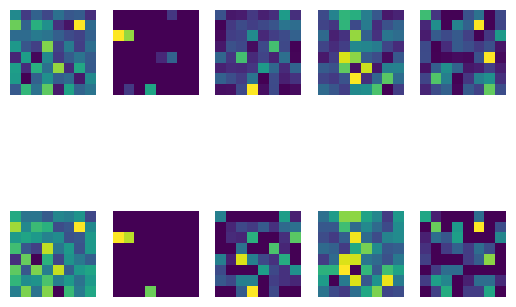

6460 tensor(0.1927, device='cuda:0', grad_fn=<MseLossBackward0>)


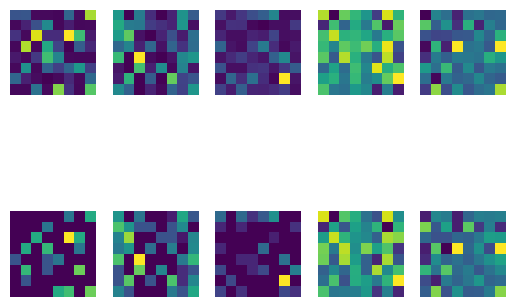

6470 tensor(0.2085, device='cuda:0', grad_fn=<MseLossBackward0>)


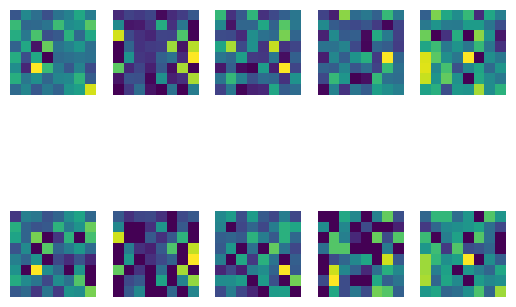

KeyboardInterrupt: 

In [269]:
for i, b in enumerate(dl):
    opt.zero_grad()
    
    slide_idxs, imgs = b['slide_idx'], b['img']
    slide_idxs, imgs = slide_idxs.cuda(), imgs.cuda()
    loss, pred_pixel_values = mae(imgs, slide_idxs)
    loss.backward()
    opt.step()
    
    if i % 10 == 0:
        print(i, loss)
        
        pred_patches = rearrange(
            pred_pixel_values, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=8, w=8, p1=1, p2=1, c=len(channels))
        
        fig, axs = plt.subplots(nrows=2, ncols=5)
        for c in range(axs.shape[1]):
            ax1, ax2 = axs[:, c]
            ax1.imshow(pred_patches[c, channel_idx].cpu().detach())
            ax1.axis('off')
            ax2.imshow(imgs[c, channel_idx].cpu().detach())
            ax2.axis('off')
            if c==0:
                ax1.set_ylabel('pred')
                ax2.set_ylabel('true')
        plt.show()
            
        
    if i % 1000 == 0:
        torch.save(mae.state_dict(), f'../data/mae_v5/{i}iter.pt')
        
    if i == iters:
        break

In [61]:
# torch.save(v.state_dict(), f'../data/mae_v3/1500iter.pt')

In [311]:
size = (256, 256)

normalize = Normalize(means, stds)
transform = InferenceTransformVisium(size=(256, 256), patch_size=32, normalize=normalize)
inference_ds = InferenceSlideDatasetVisium(slide_to_adata, size=(256, 256), transform=transform, crop=False)

In [312]:
inference_dl = DataLoader(inference_ds, batch_size=32, shuffle=False)

In [299]:
x = inference_ds.image_from_tiles(inference_ds.slide_to_tiles[inference_ds.slides[0]],
                                  to_expression=True, adata=inference_ds.slide_to_adata['s0'])
x.shape

torch.Size([11630, 52, 52])

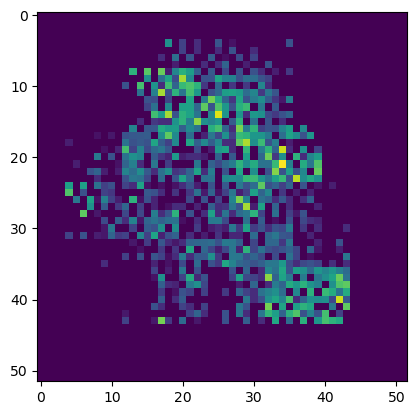

In [301]:
plt.imshow(x[channels.index('EPCAM')])

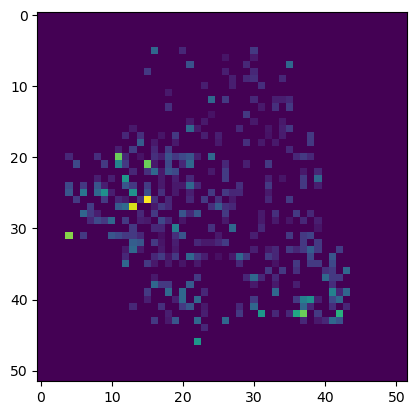

In [302]:
plt.imshow(x[channels.index('IL7R')])

In [315]:
d = inference_ds[0]
d.keys()

dict_keys(['slide_idx', 'row_idx', 'col_idx', 'img'])

In [316]:
d['img'].shape

torch.Size([11630, 8, 8])

In [303]:
v = ViT(
    image_size = 8,
    patch_size = 1,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    channels=len(channels),
)

In [304]:
mae = SlideMAEV2(
    encoder = v,
    n_slides = len(slide_to_adata),
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

In [305]:
mae.load_state_dict(torch.load('../data/mae_v5/6000iter.pt'))

<All keys matched successfully>

In [306]:
mae.eval()

SlideMAEV2(
  (encoder): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=1, p2=1)
      (1): LayerNorm((11630,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=11630, out_features=1024, bias=True)
      (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_qkv): Linear(in_features=1024, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=1024, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
          )
          (1):

In [317]:
all_encoded_tokens = torch.zeros(len(inference_ds), size[0] // 32, size[1] // 32, v.pos_embedding.shape[-1])
all_decoded_tokens = torch.zeros(len(inference_ds), size[0] // 32, size[1] // 32, mae.decoder_dim)
all_pred_patches = torch.zeros(len(inference_ds), len(channels), size[0] // 32, size[1] // 32)
bs = inference_dl.batch_size
with torch.no_grad():
    for i, b in enumerate(inference_dl):
        x, slide_idx = b['img'], b['slide_idx']
        if v.pos_embedding.is_cuda:
            x, slide_idx = x.to(v.pos_embedding.device), slide_idx.to(v.pos_embedding.device)
        
        encoded_tokens = mae.encode(x, slide_idx)
        decoded_tokens = mae.decode(encoded_tokens)
        pred_pixel_values = mae.to_pixels(decoded_tokens[:, 1:])

        encoded_tokens = rearrange(encoded_tokens[:, 1:], 'b (h w) d -> b h w d',
                                  h=size[0] // 32, w=size[1] // 32)
        decoded_tokens = rearrange(decoded_tokens[:, 1:], 'b (h w) d -> b h w d',
                                  h=size[0] // 32, w=size[1] // 32)
        pred_patches = rearrange(
            pred_pixel_values, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=size[0] // 32, w=size[0] // 32, p1=1, p2=1, c=len(channels))
        
        all_encoded_tokens[i * bs:(i + 1) * bs] = encoded_tokens.cpu().detach()
        all_decoded_tokens[i * bs:(i + 1) * bs] = decoded_tokens.cpu().detach()
        all_pred_patches[i * bs:(i + 1) * bs] = pred_patches.cpu().detach()

In [318]:
all_encoded_tokens.shape, all_decoded_tokens.shape, all_pred_patches.shape

(torch.Size([338, 8, 8, 1024]),
 torch.Size([338, 8, 8, 512]),
 torch.Size([338, 11630, 8, 8]))

In [320]:
x = inference_ds.slide_from_tiles(all_pred_patches, 0, size=all_pred_patches.shape[-2:])
x.shape

torch.Size([11630, 52, 52])

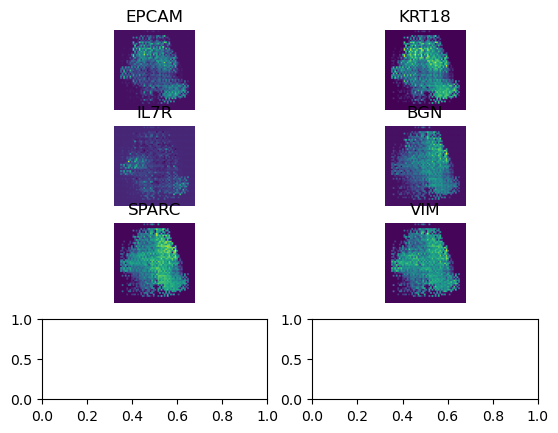

In [322]:
genes = [
    'EPCAM', 'KRT18',
    'IL7R',
    'BGN', 'SPARC', 'VIM',
]
n_cols = 2
n_rows = len(genes) // n_cols + 1
rc = [(i, j) for i in range(n_rows) for j in range(n_cols)]

fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows)
rc = [(i, j) for i in range(n_rows) for j in range(n_cols)]
for (row_idx, col_idx), c in zip(rc, genes):
    ax = axs[row_idx, col_idx]
    ax.imshow(x[channels.index(c)])
    ax.axis('off')
    ax.set_title(c)